# DCGAN

Deep convolutional Geerative Adversial Network

## Data

### Importing liberaries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.15.0'

### load And Preprocess data

In [ ]:
(X_train, y_train), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

### visualizing the images

4


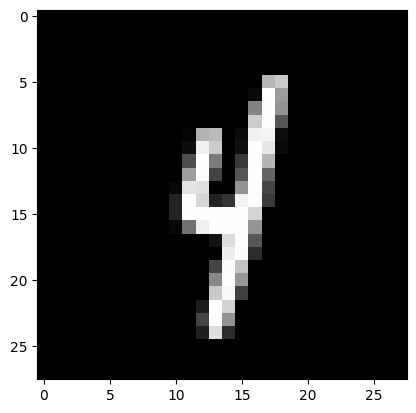

In [ ]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray')

### Data Preprocessing

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

We need to normalize the images to reduce the variation in the data

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

now the data in in range -1 to 1

It is recommended to keep these values while working with DCGANs

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
buffer_size/batch_size

234.375

Now we will divide the data into 256 batches with 234 images in each batch and use mini-batch Gradient Descent algorithm

In [ ]:
type(X_train)

numpy.ndarray

the data is in numpy format so we need to convert it into tensorflow format

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

Now checking the shape of X_train

In [ ]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Building the Generator

making a function that builds the generator

 we do not require bias in the generator since we are actually not training the generator on its own but using the discriminator to do so

In [ ]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape = (100,)))   # we do not require bias
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7*7*128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding ='same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  #14*14*64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding ='same',strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28*28*1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding ='same',strides = (2,2), use_bias = False, activation = 'tanh'))

  network.summary()

  return network

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [ ]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [ ]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.55899   , -1.9114133 , -0.10627472,  0.446036  , -1.0228461 ,
         0.10420503,  1.2441832 , -1.1702244 , -0.0686747 , -0.3497587 ,
         0.42898542, -0.6883625 , -0.09674311,  0.57269466, -1.1733502 ,
        -0.6704671 , -1.0589795 , -1.0933466 , -1.4712738 , -0.9363584 ,
         0.46407023, -0.5230469 ,  0.35888132, -1.1219    ,  0.25274768,
        -1.1687605 , -0.01696954, -2.1238728 , -0.35786405, -1.1486489 ,
        -1.142668  ,  0.02099445,  1.485048  , -0.5131688 , -0.7771032 ,
        -0.02567002, -0.4139557 ,  1.5984133 , -0.68964225,  1.6315438 ,
        -0.1918879 ,  0.31270367, -0.8001068 , -0.10002562,  1.3724283 ,
        -0.16292614, -0.35420164,  1.5438558 , -1.0514169 , -0.49664256,
        -0.6606523 ,  0.42684183,  1.0261275 , -1.34263   ,  0.69451374,
         0.41581315, -2.8852308 ,  2.8434105 ,  0.02736536,  0.8883285 ,
         0.32236788,  0.91653   ,  0.31760463,  1.9802824 ,  0.8368089 ,
 

generating an image using the noise and passing it through our generator network

In [ ]:
generateed_image = generator(noise, training=False)

In [ ]:
generateed_image.shape

TensorShape([1, 28, 28, 1])

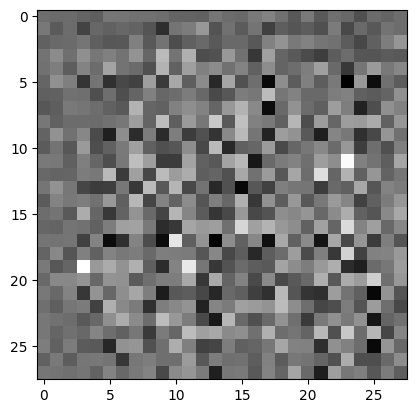

In [ ]:
plt.imshow(generateed_image[0,:,:], cmap = 'gray')

## Building the Discriminator

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14*14*64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  #7*7*128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network


In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [ ]:
discriminator(generateed_image, training = False) #logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00156861]], dtype=float32)>

In [ ]:
tf.sigmoid(-0.00117478)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49970633>

## Error Calculation combining the generator and discriminator

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits= True)

### Discriminator loss

In [ ]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

## Generator loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)


## Training the GAN

In [ ]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [ ]:
batch_size, noise_dimension

(256, 100)

In [ ]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

## Training the model and testing and visualizing the model

In [ ]:
test_images = tf.random.normal([number_of_images, noise_dimension])
test_images.shape

TensorShape([16, 100])

In [ ]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)
    print('Epoch: ' , epoch+1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i,:,:,0]*127.5 +127.5, cmap='gray') #because the result is normalized
      plt.axis('off')
    plt.show()

In [ ]:
tf.config.run_functions_eagerly(True)

Epoch:  1


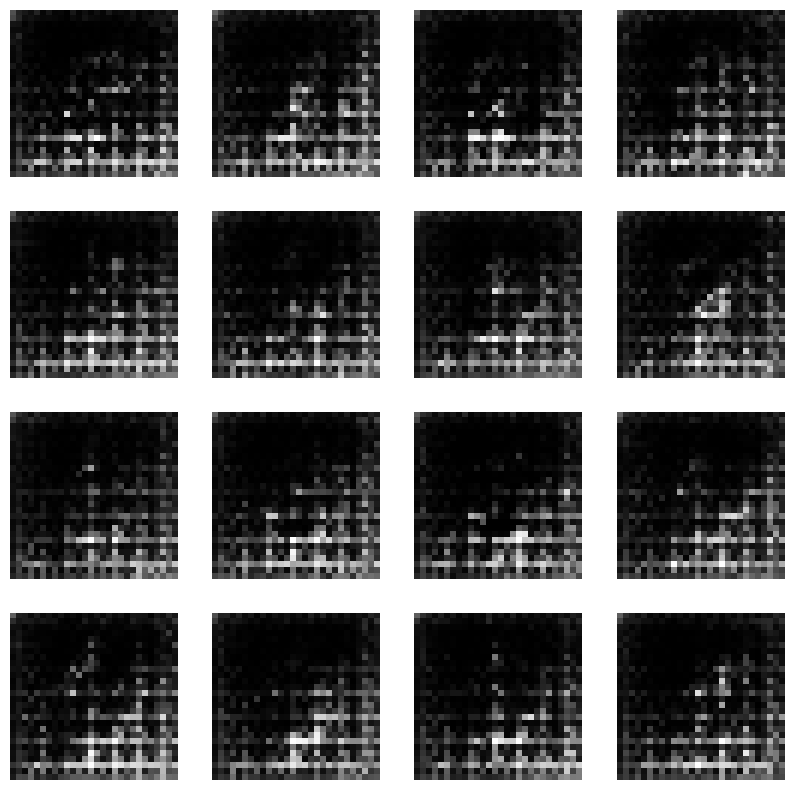

Epoch:  2


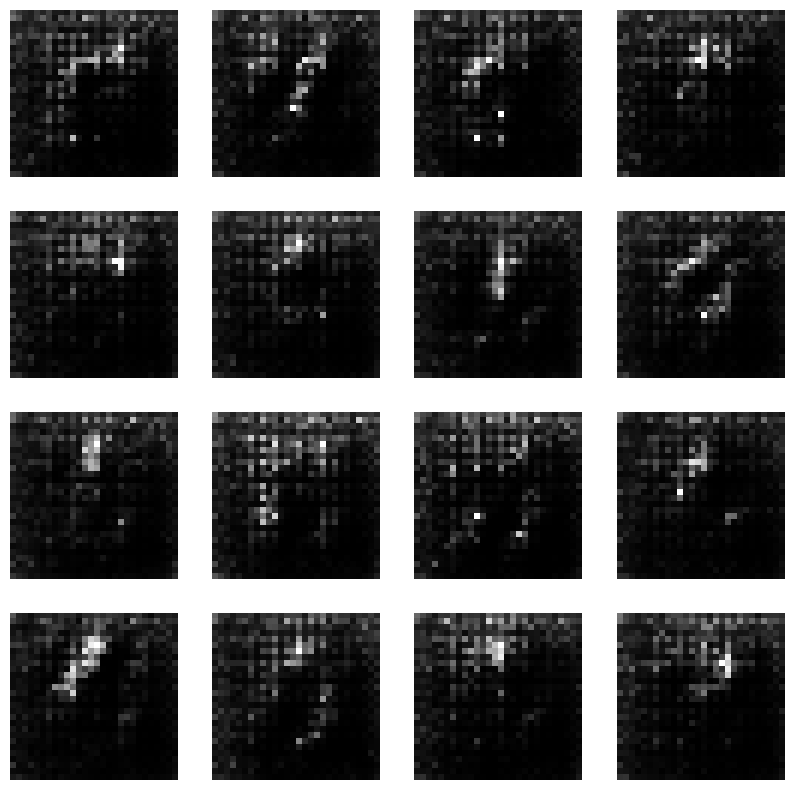

Epoch:  3


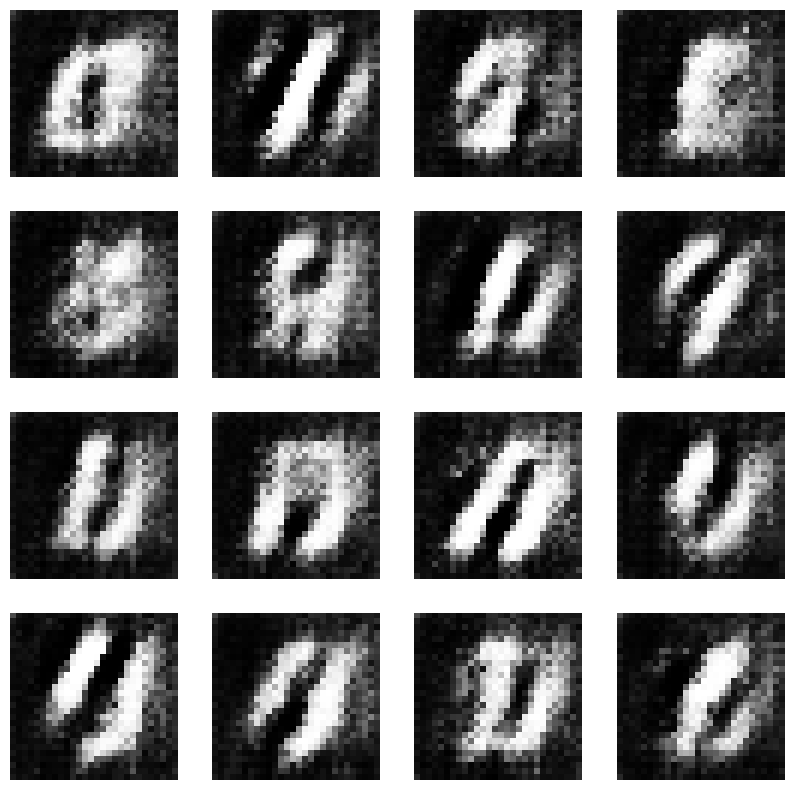

Epoch:  4


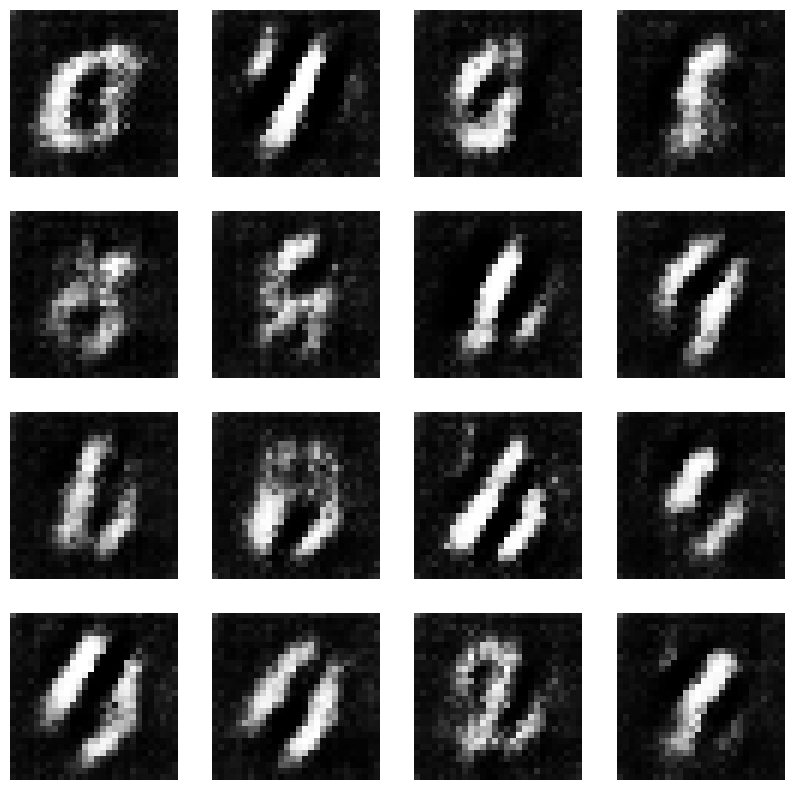

Epoch:  5


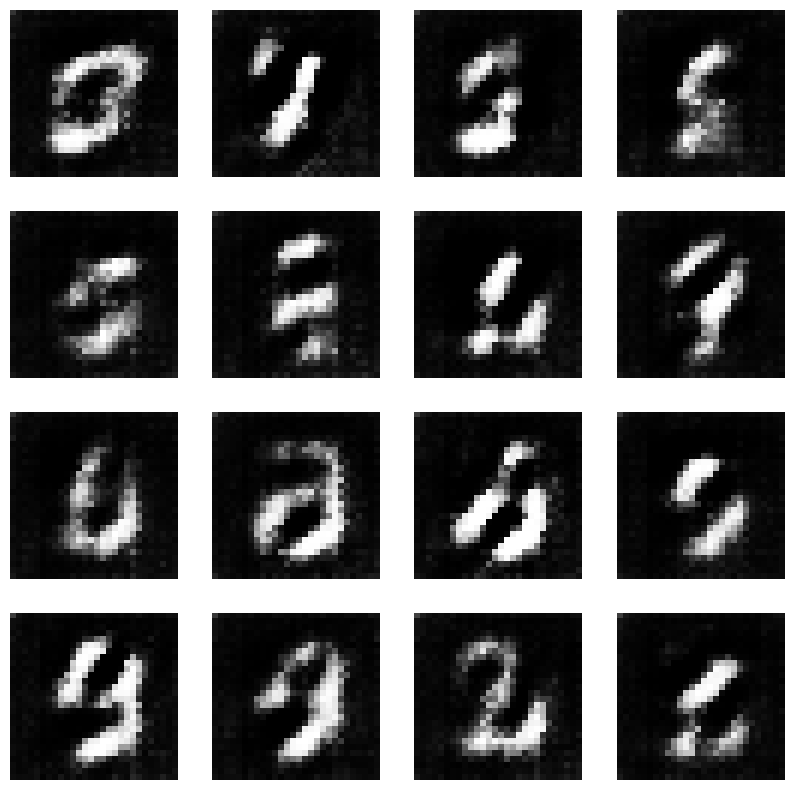

Epoch:  6


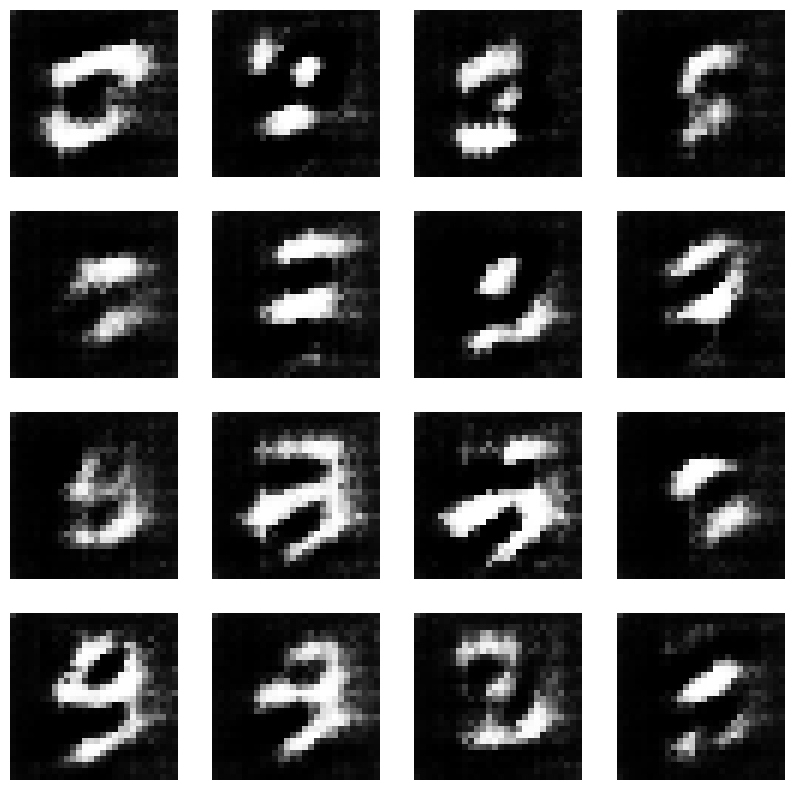

Epoch:  7


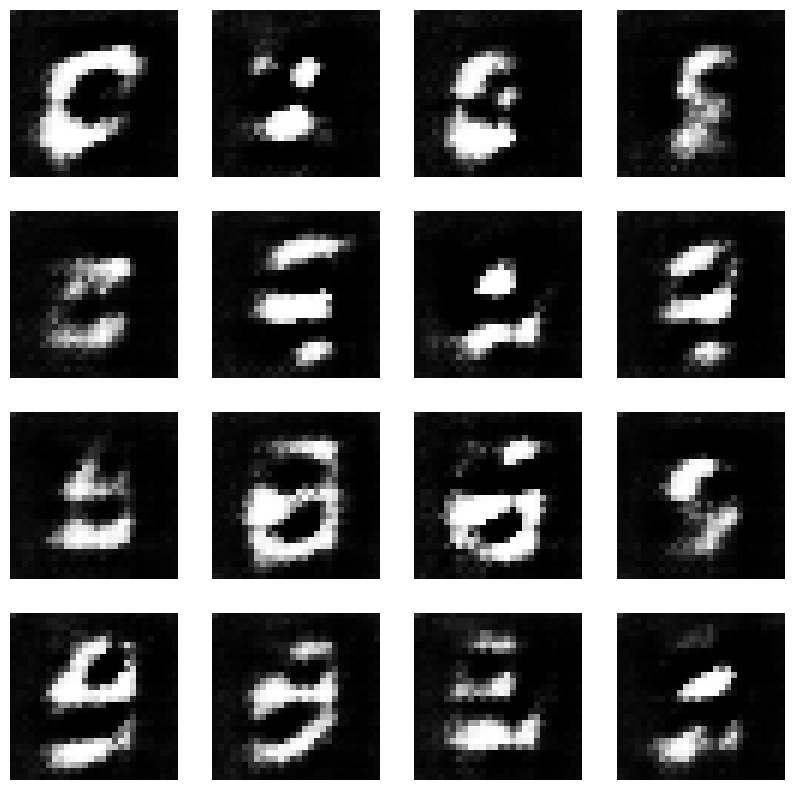

Epoch:  8


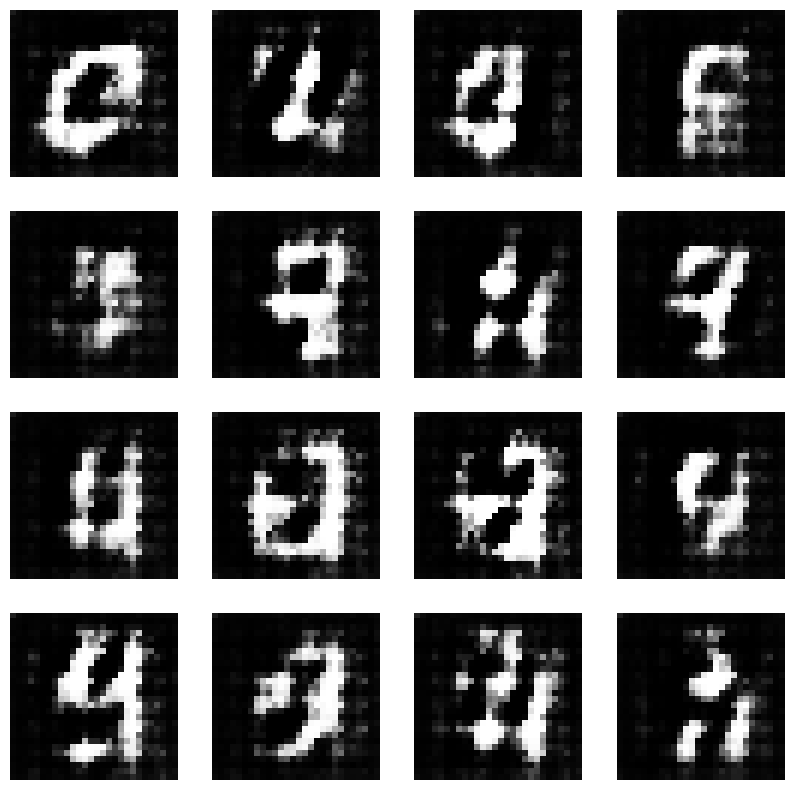

Epoch:  9


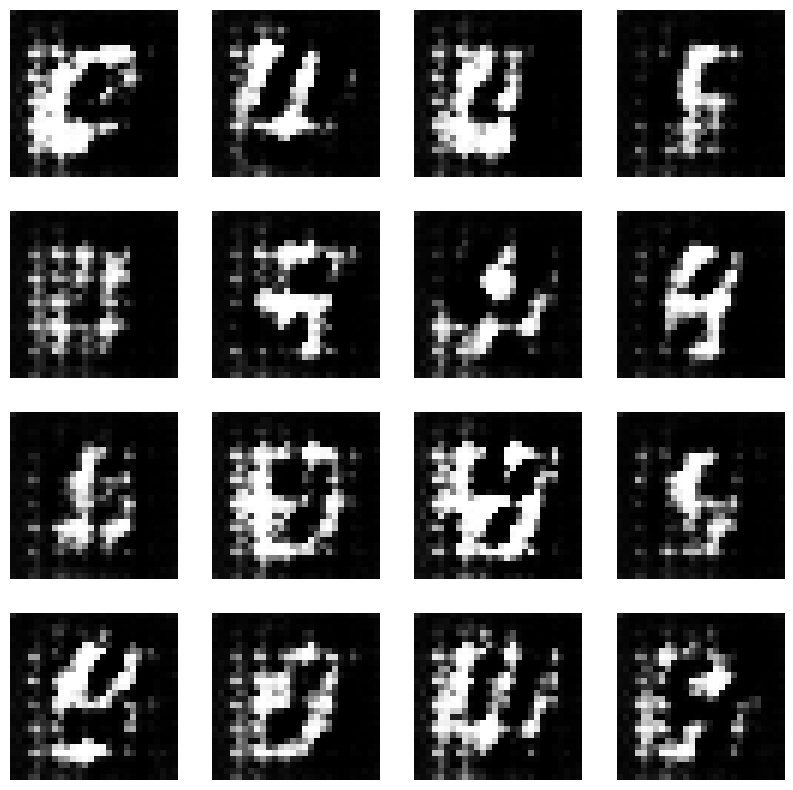

Epoch:  10


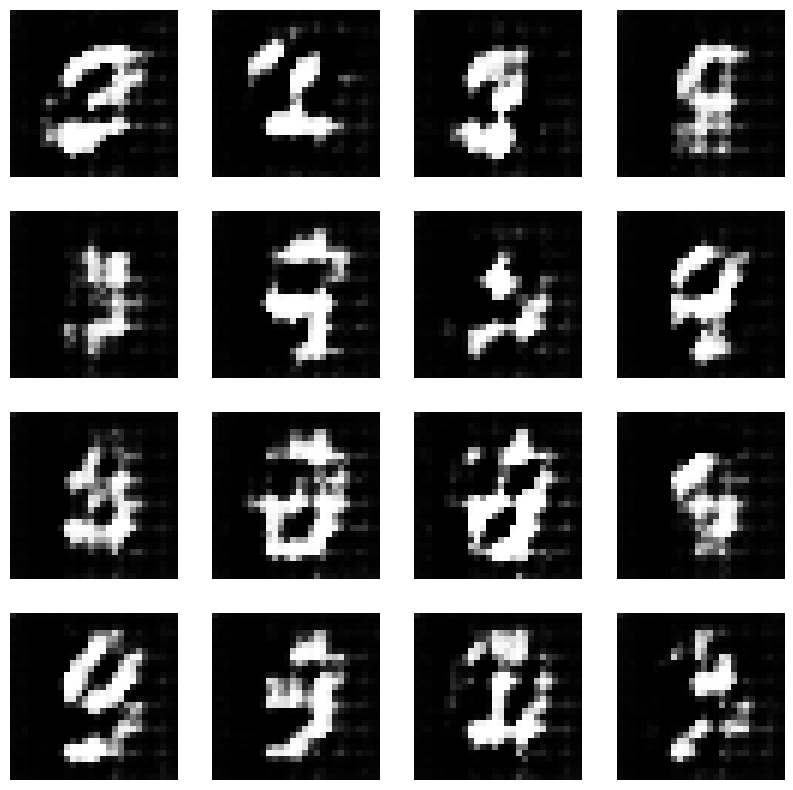

Epoch:  11


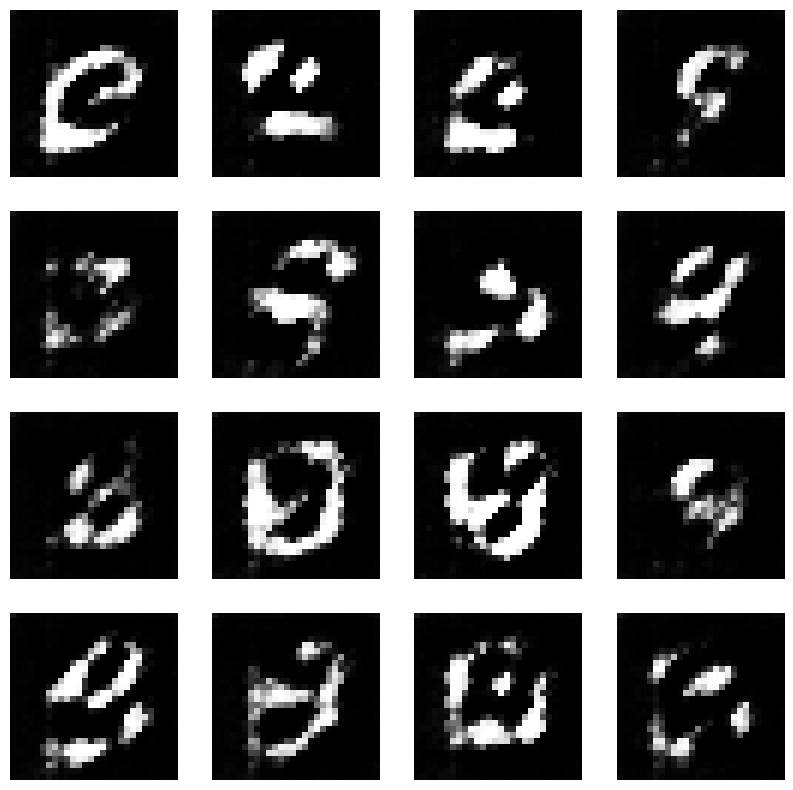

Epoch:  12


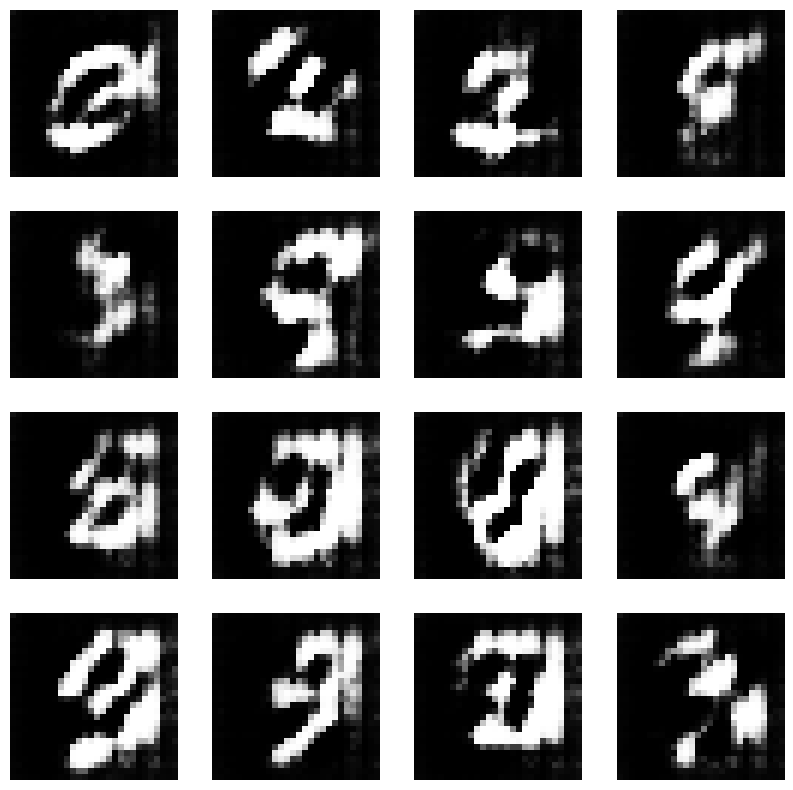

Epoch:  13


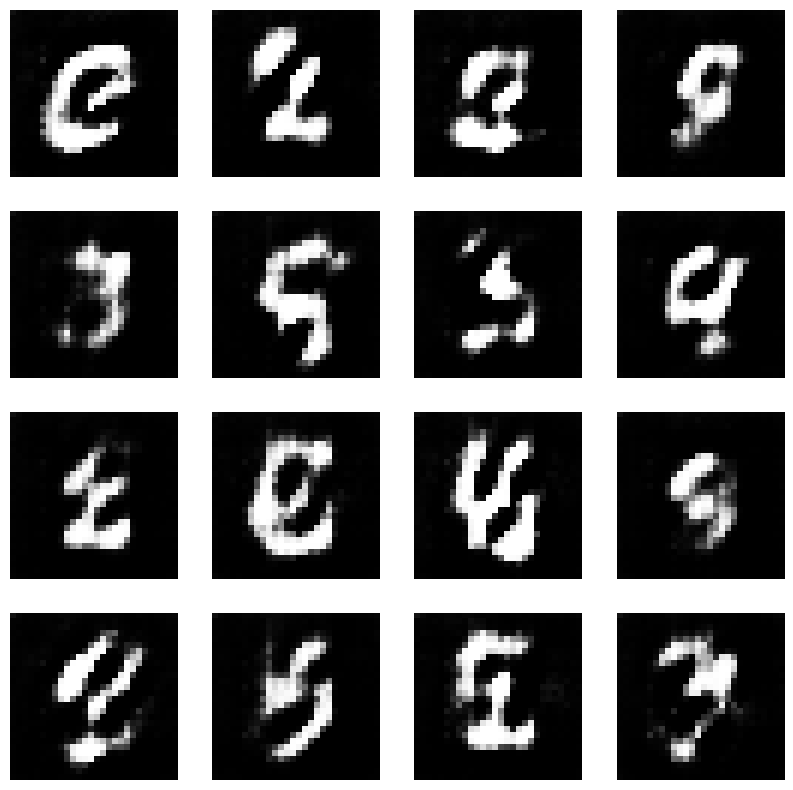

Epoch:  14


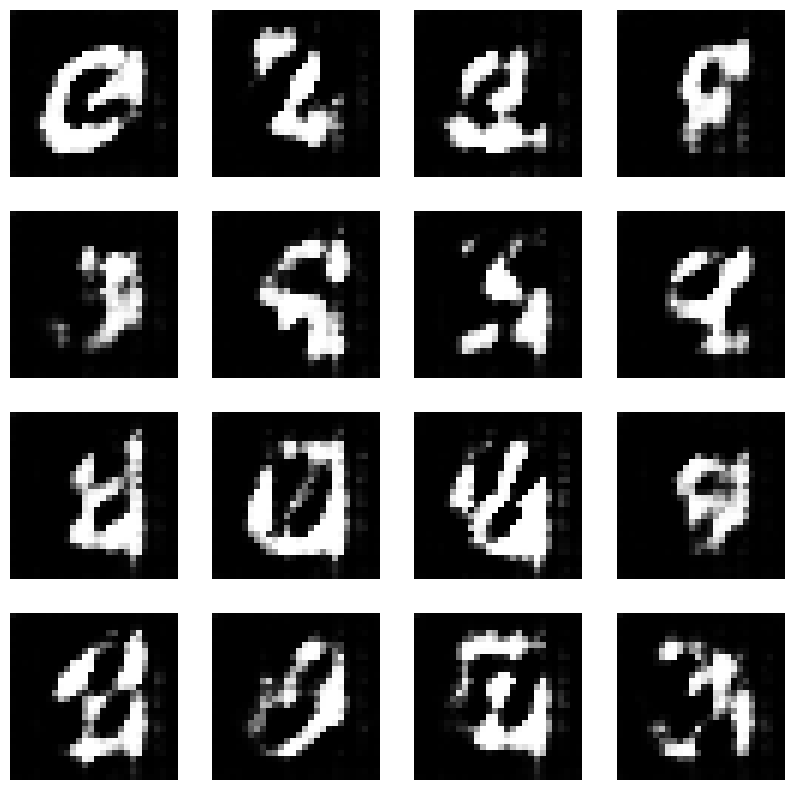

Epoch:  15


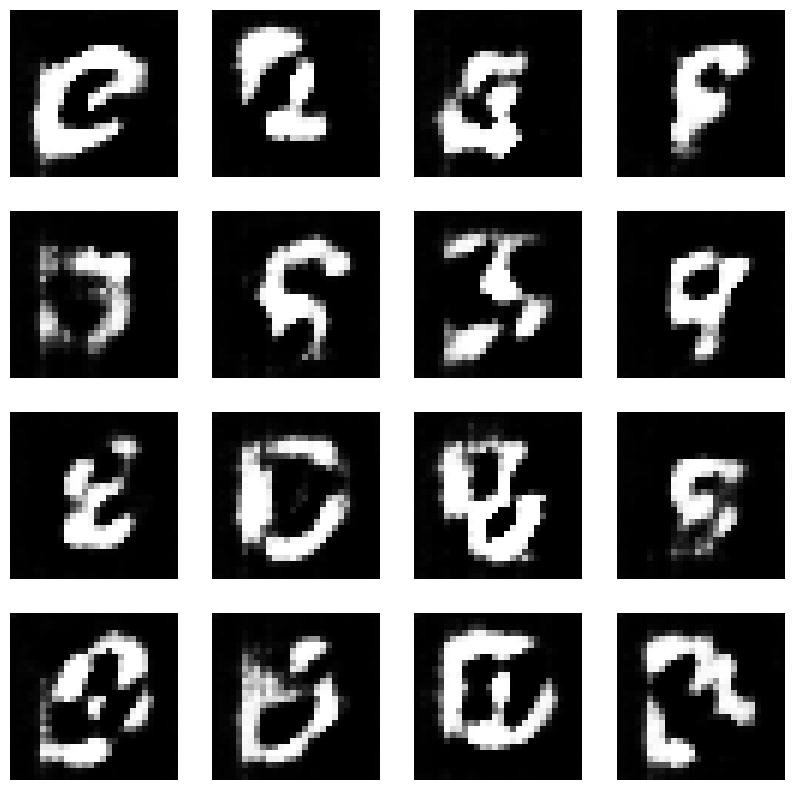

Epoch:  16


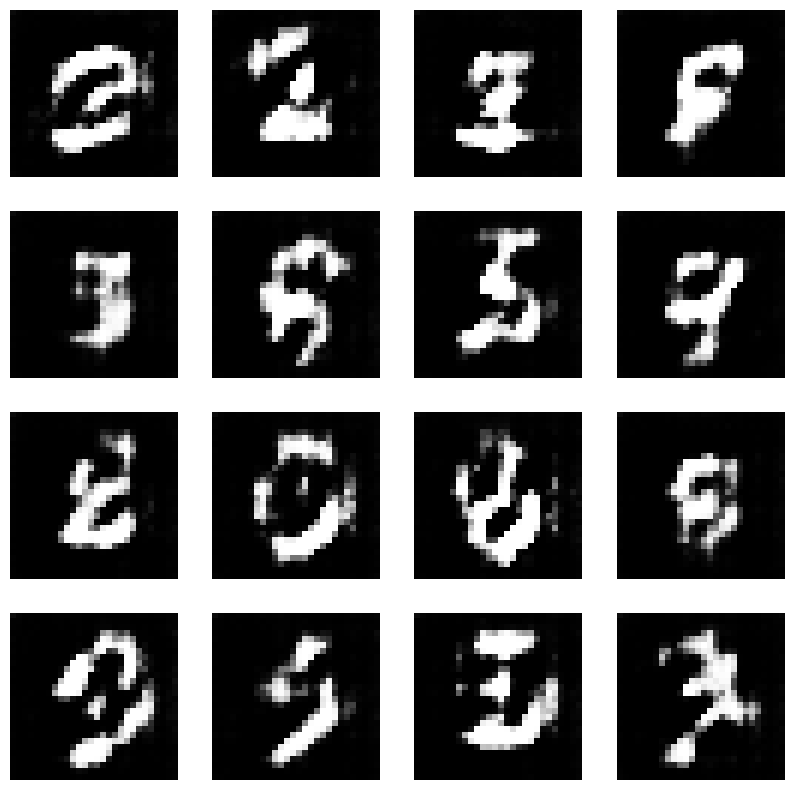

Epoch:  17


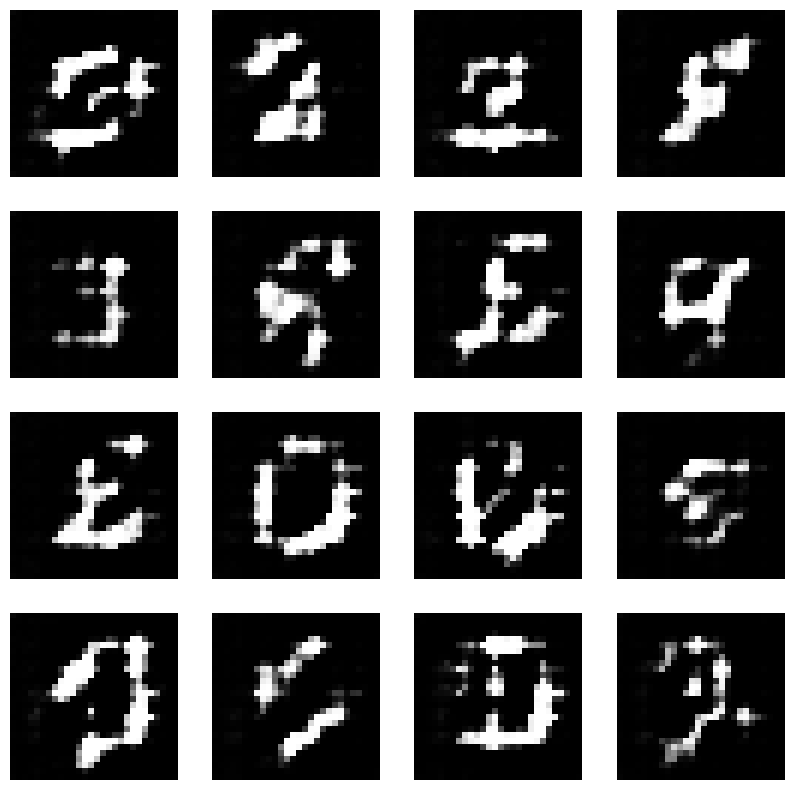

Epoch:  18


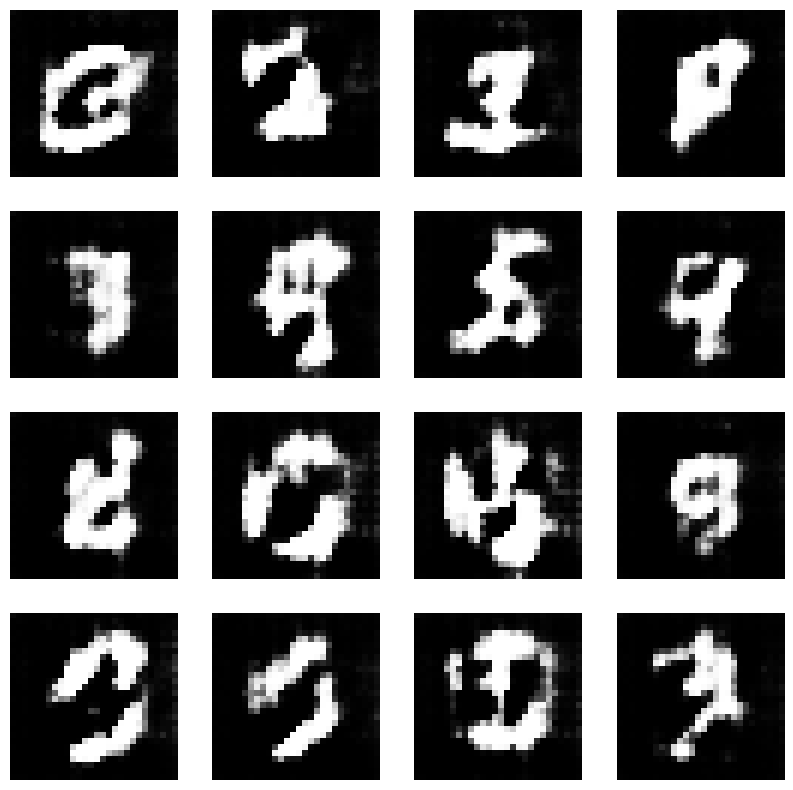

Epoch:  19


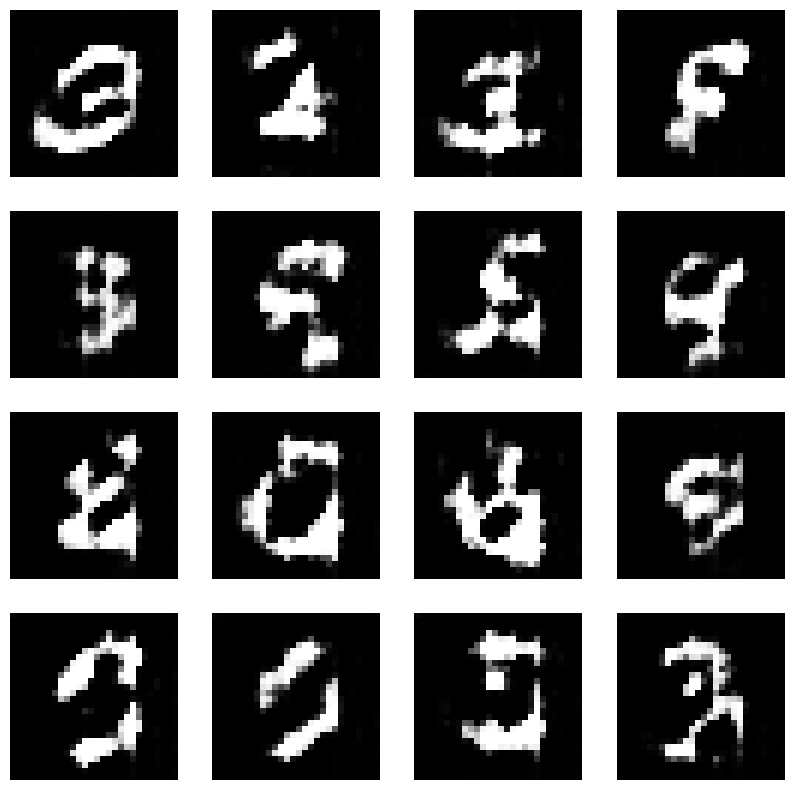

Epoch:  20


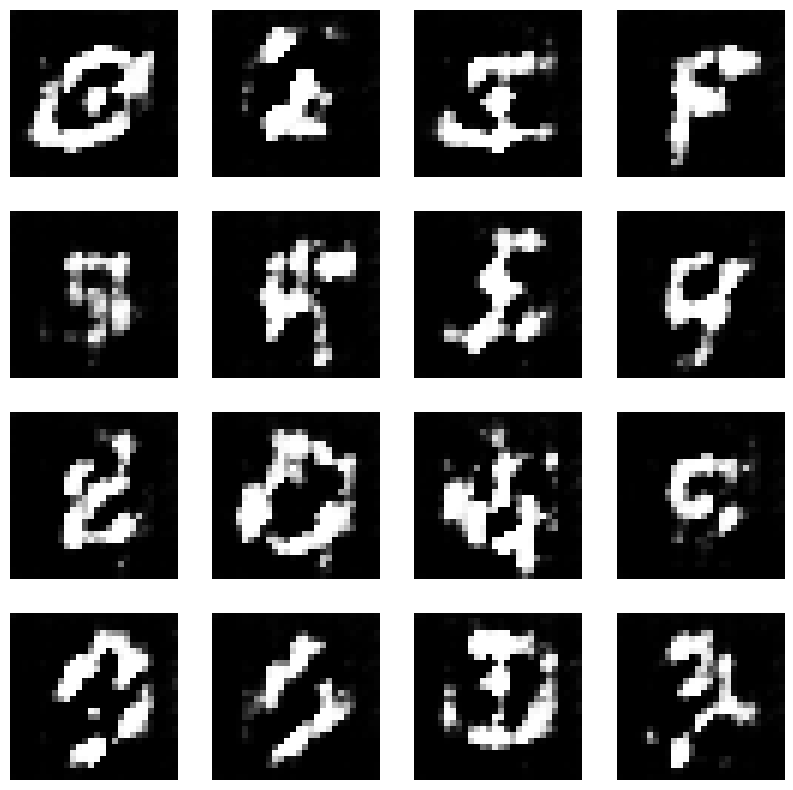

Epoch:  21


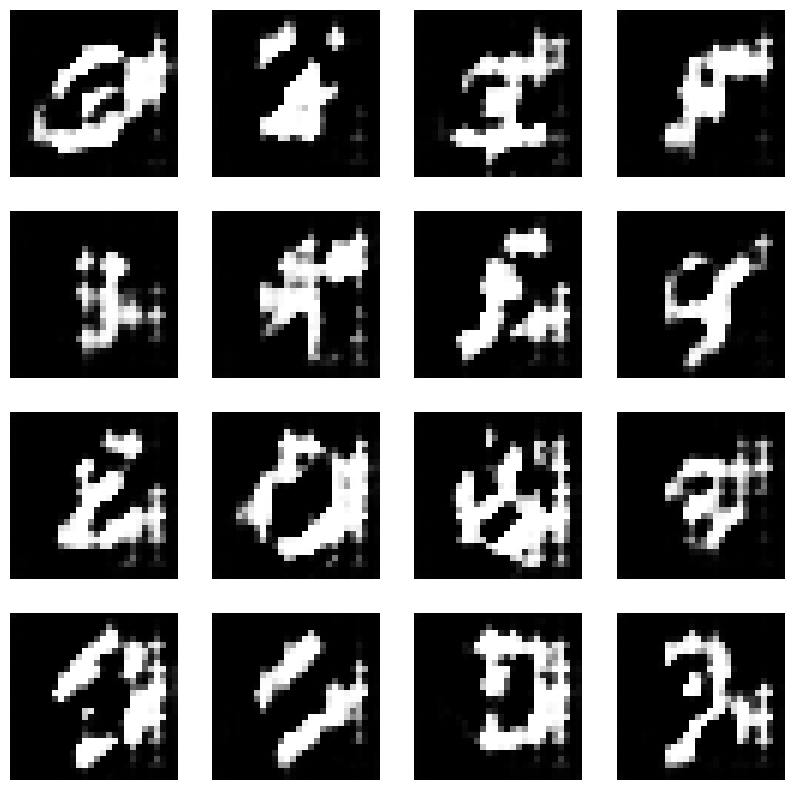

Epoch:  22


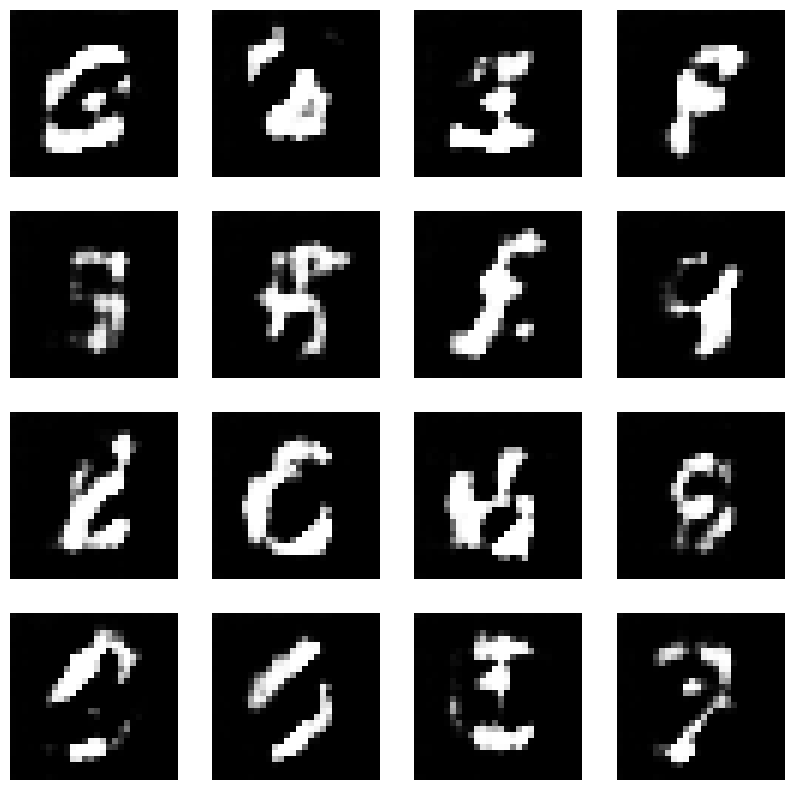

Epoch:  23


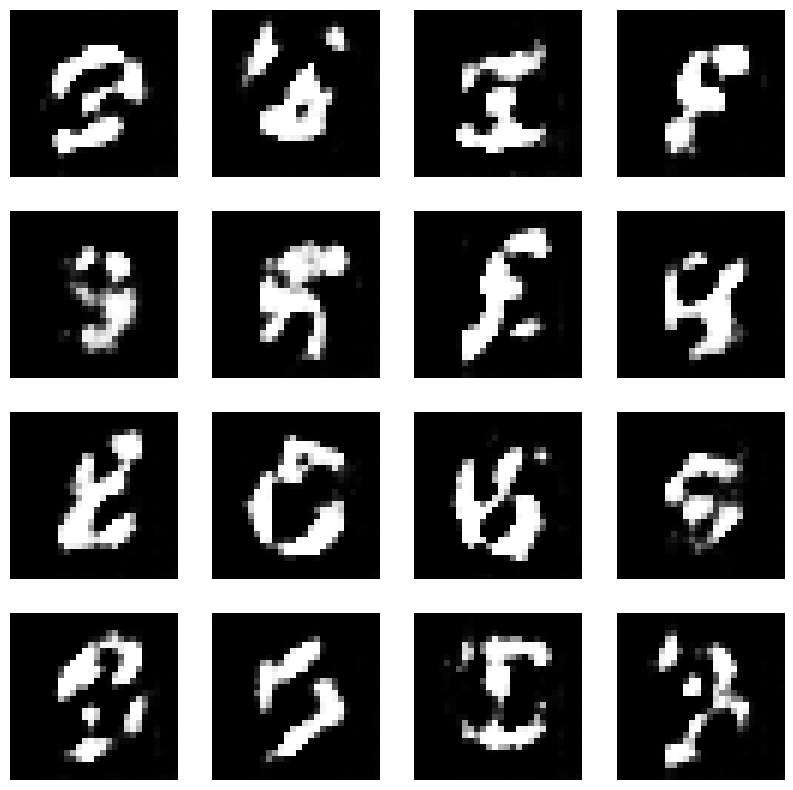

Epoch:  24


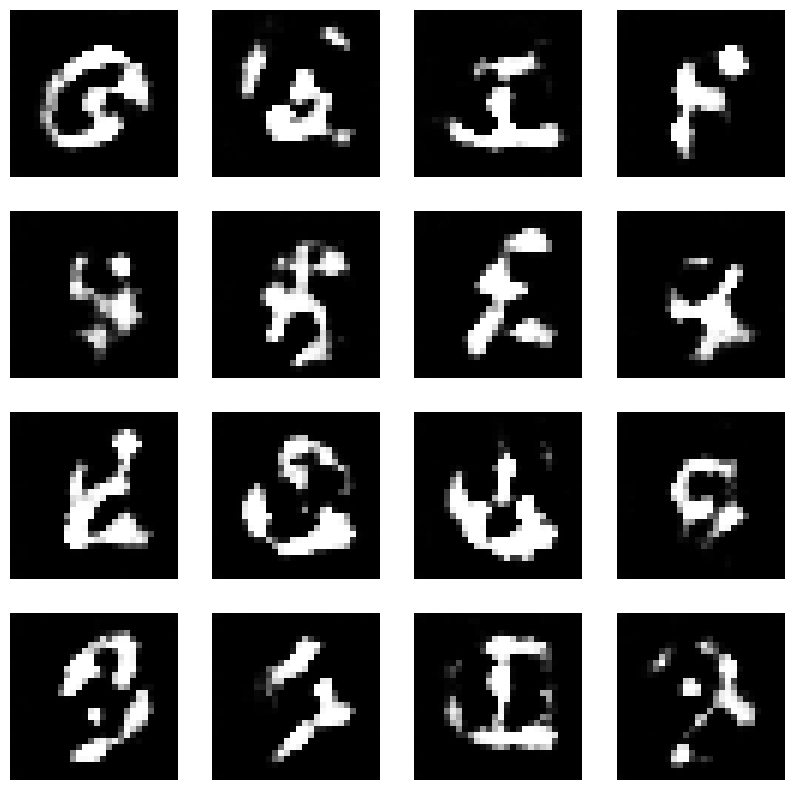

Epoch:  25


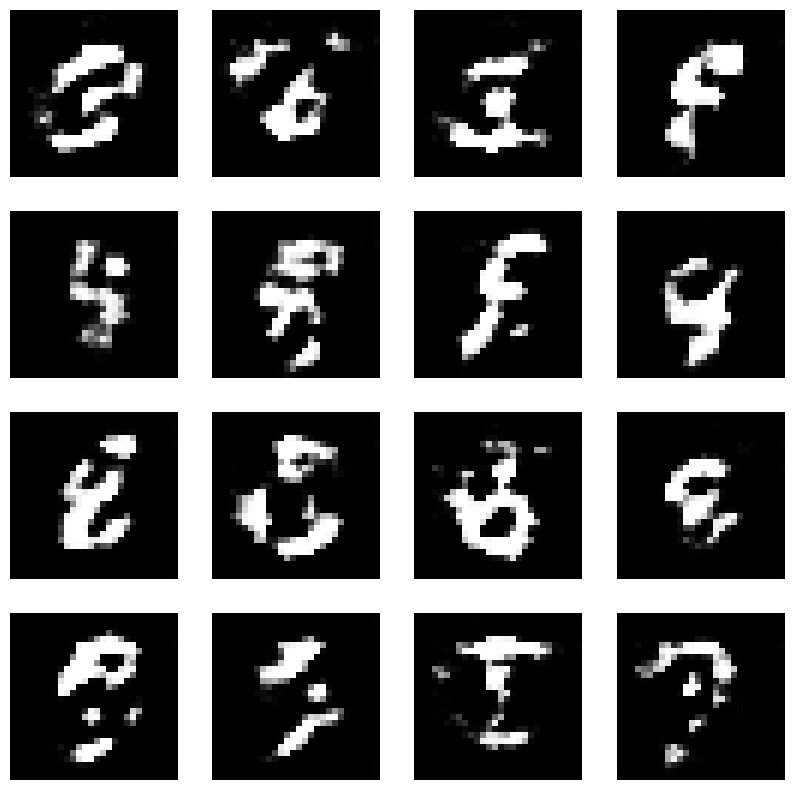

Epoch:  26


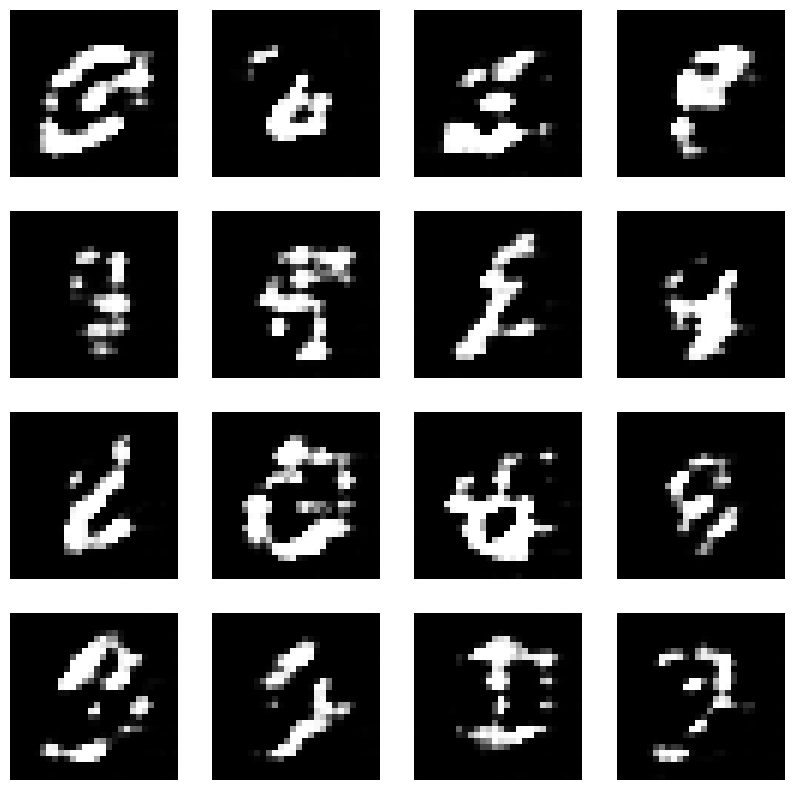

Epoch:  27


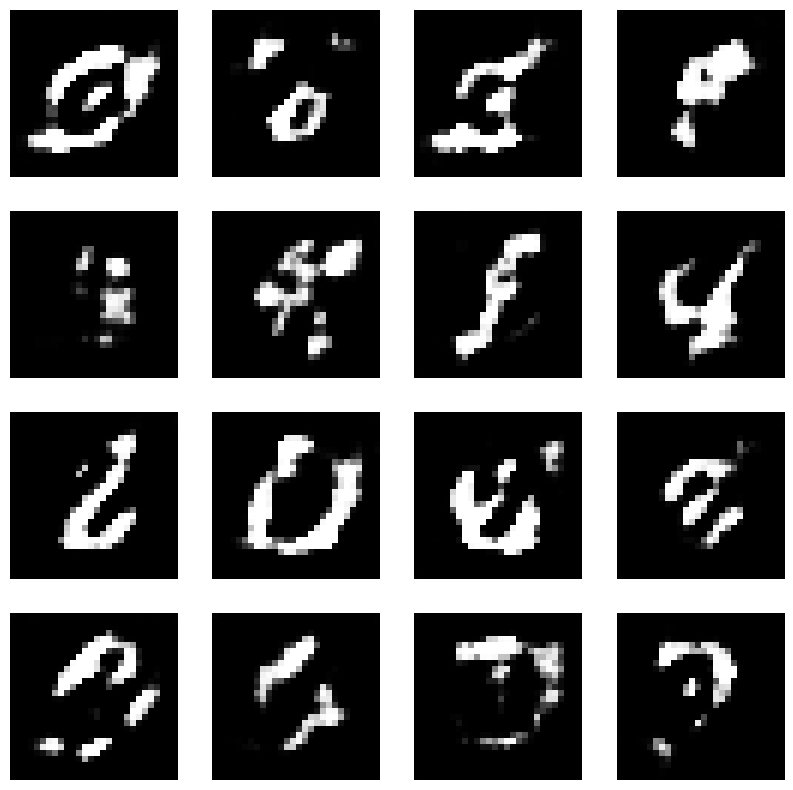

Epoch:  28


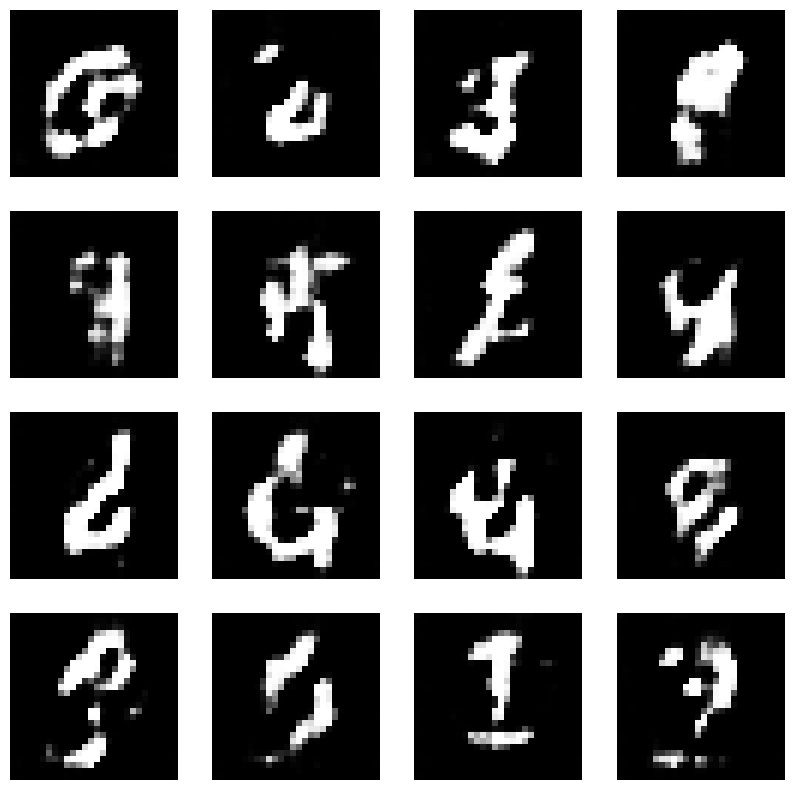

Epoch:  29


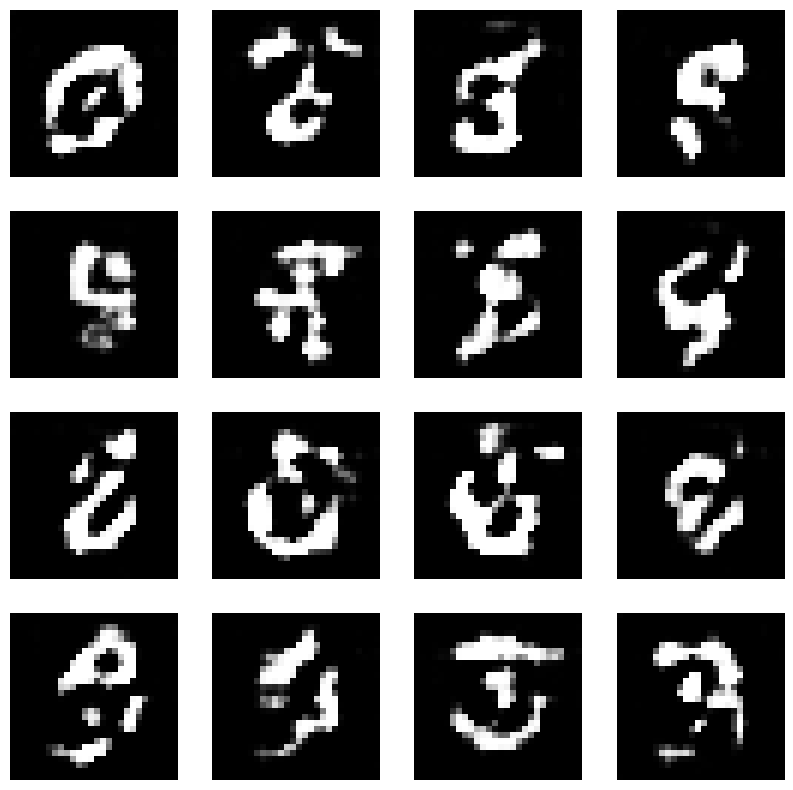

Epoch:  30


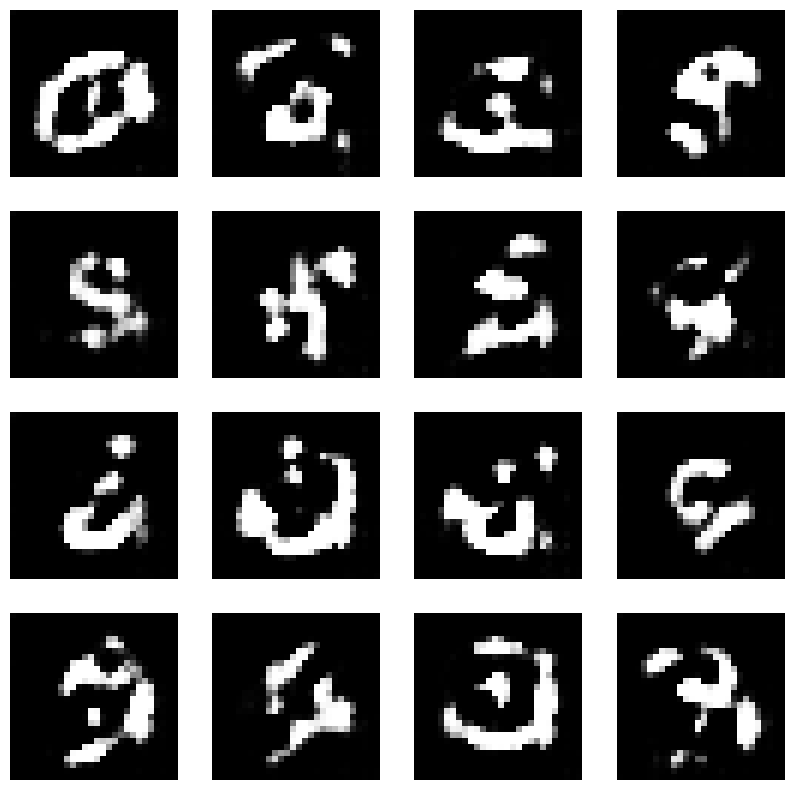

Epoch:  31


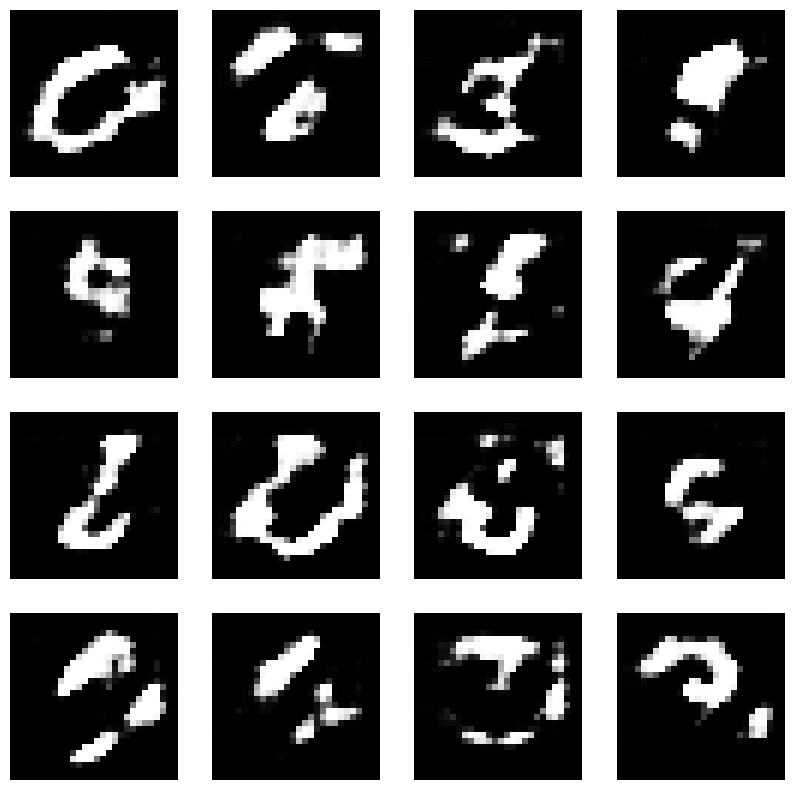

Epoch:  32


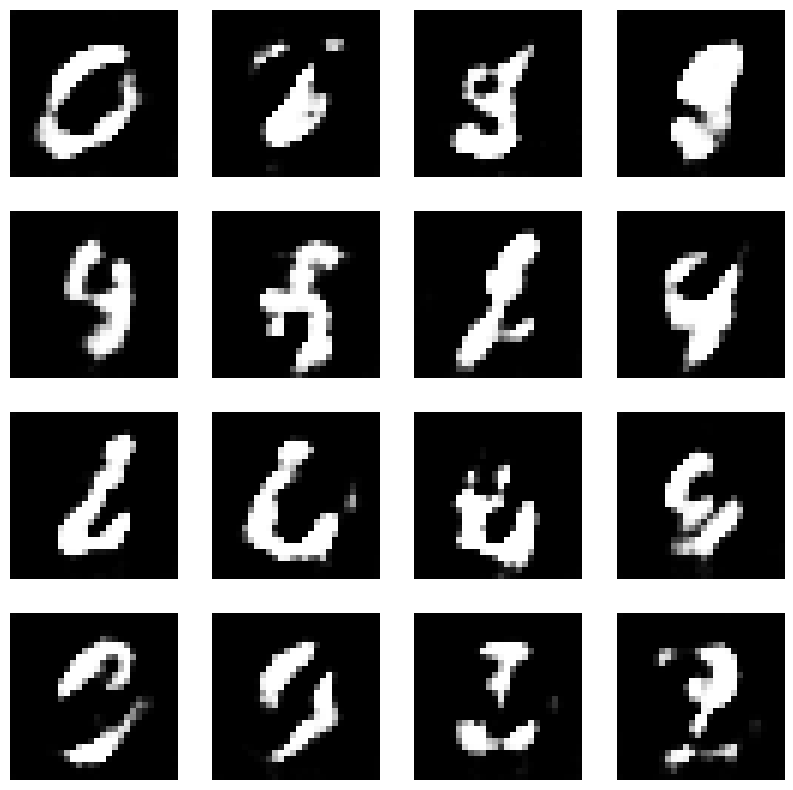

Epoch:  33


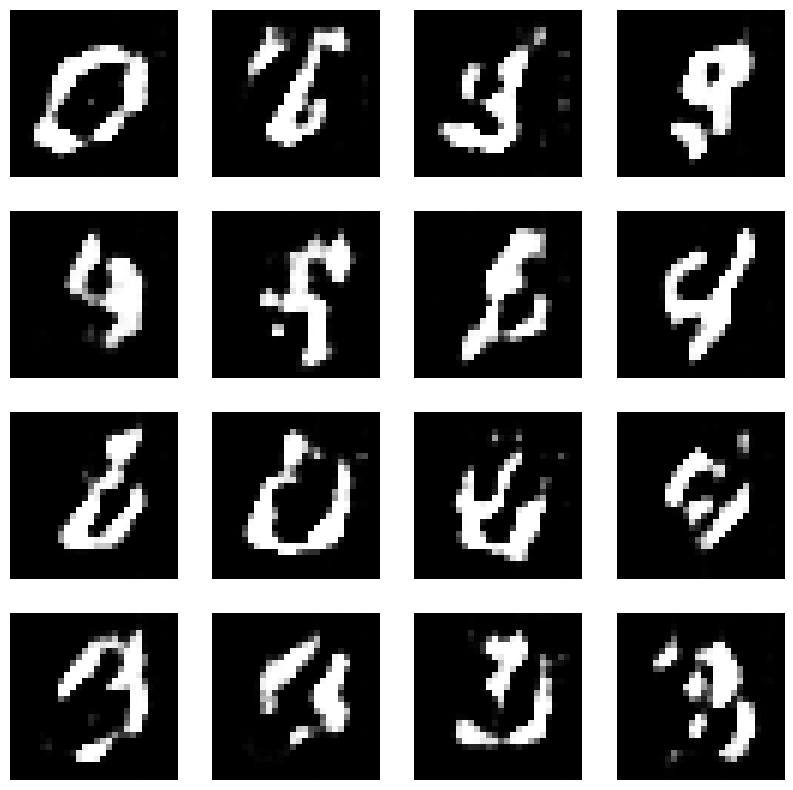

Epoch:  34


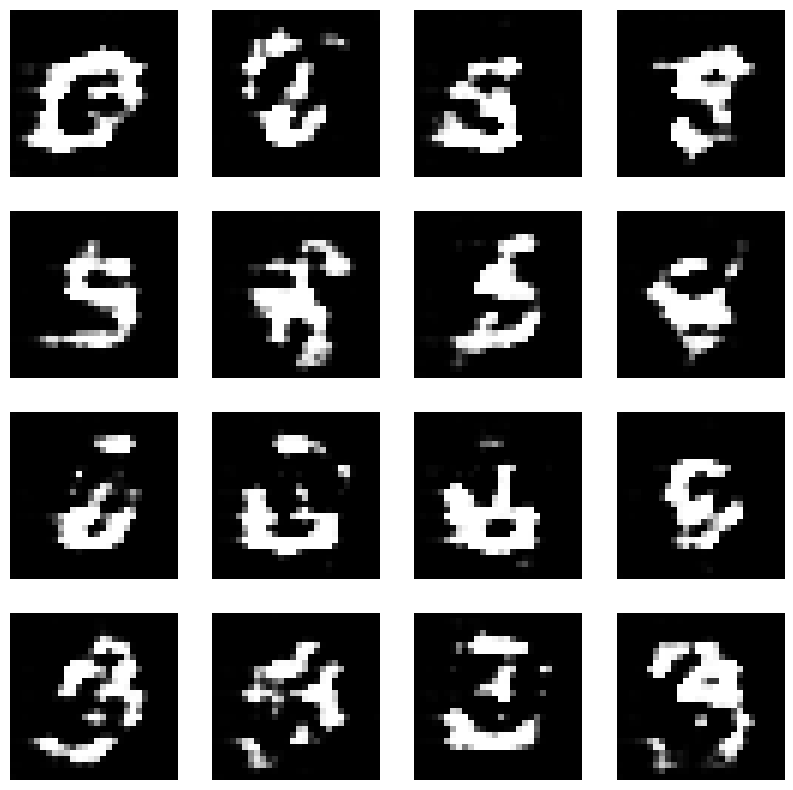

Epoch:  35


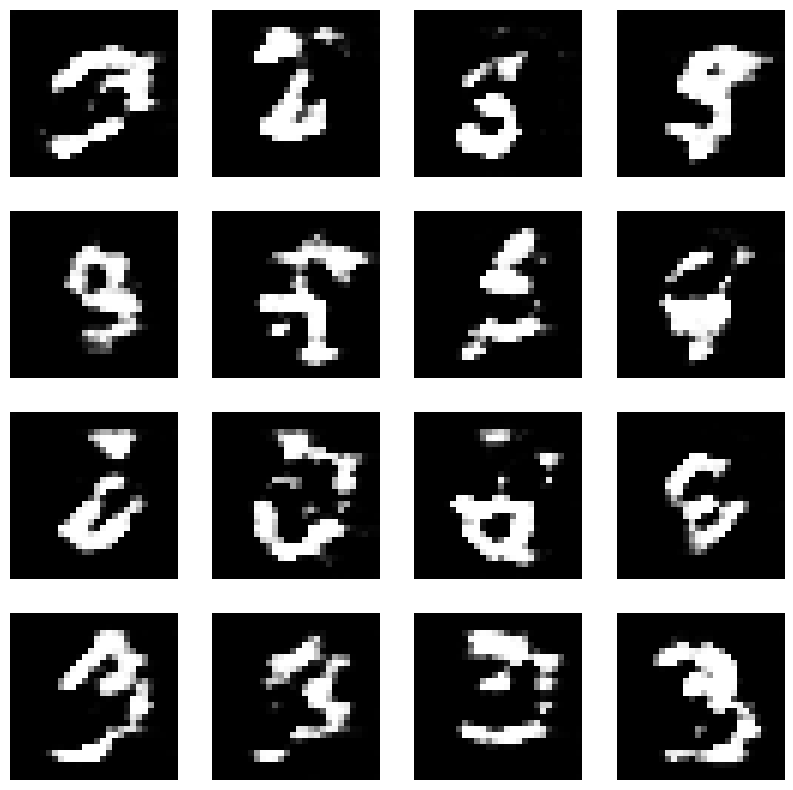

Epoch:  36


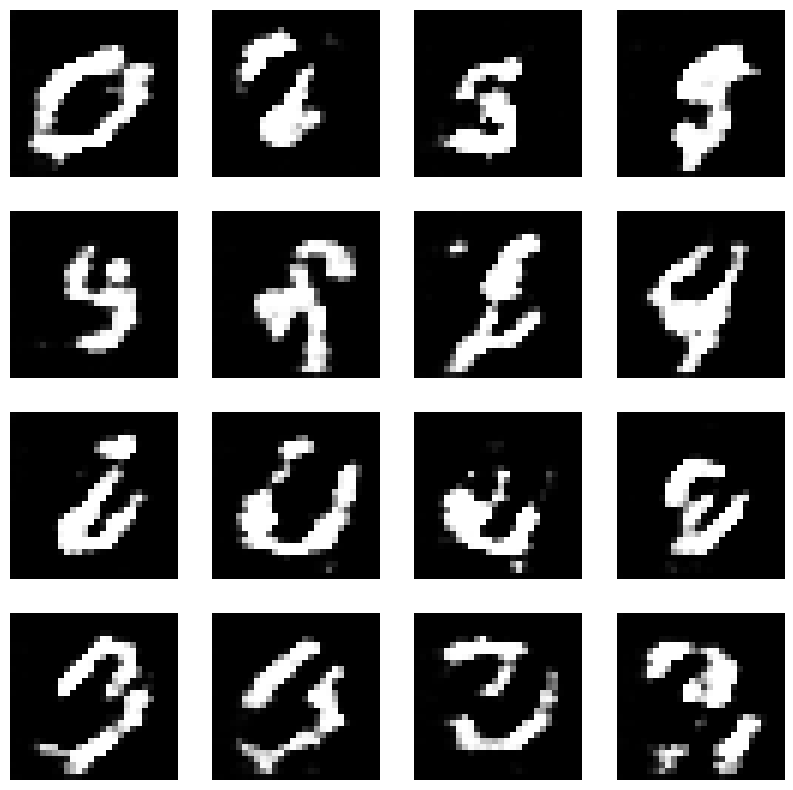

Epoch:  37


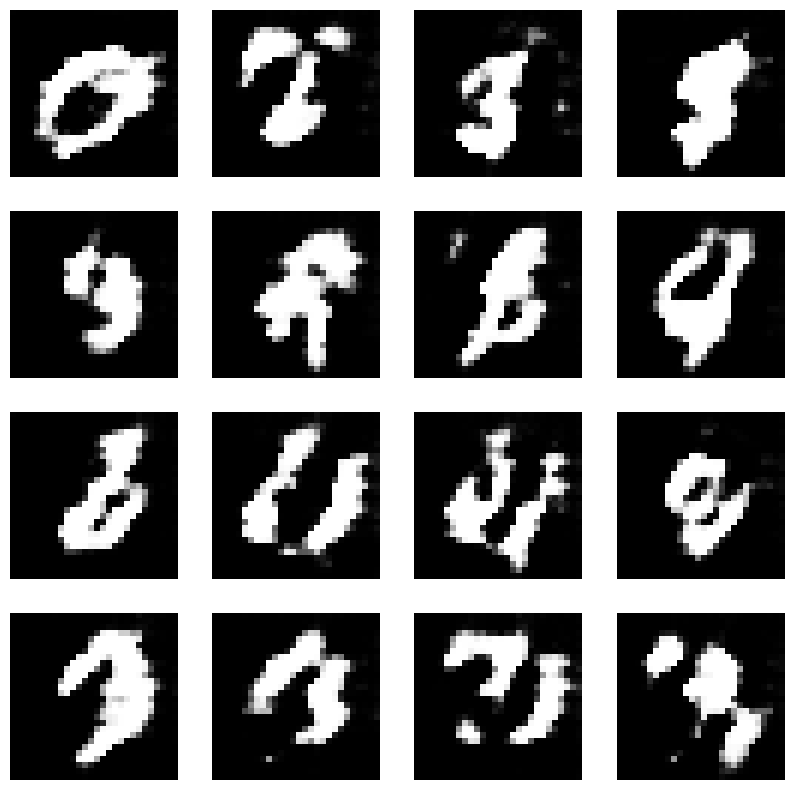

Epoch:  38


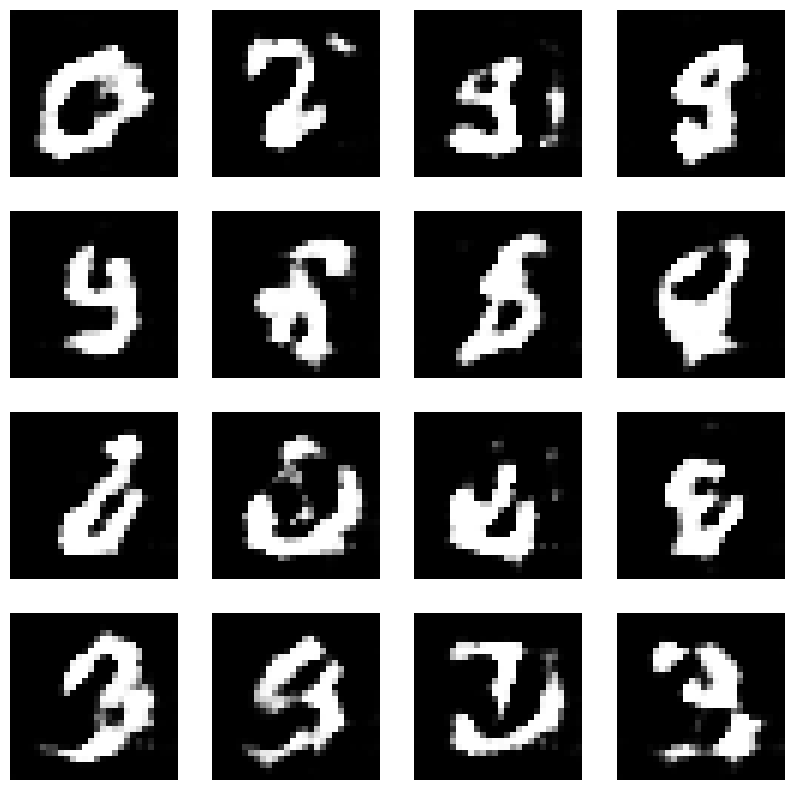

Epoch:  39


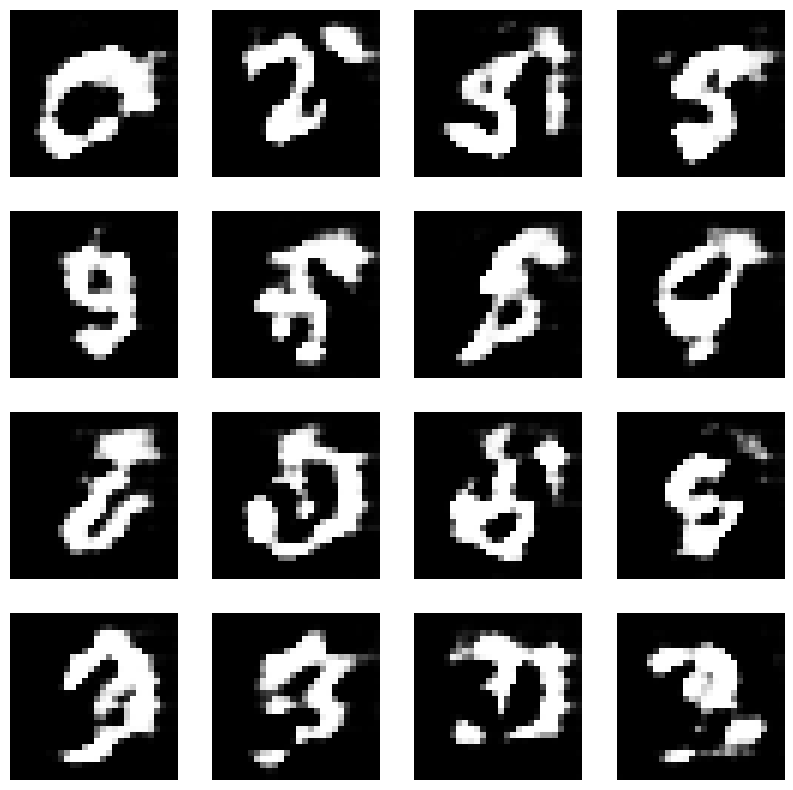

Epoch:  40


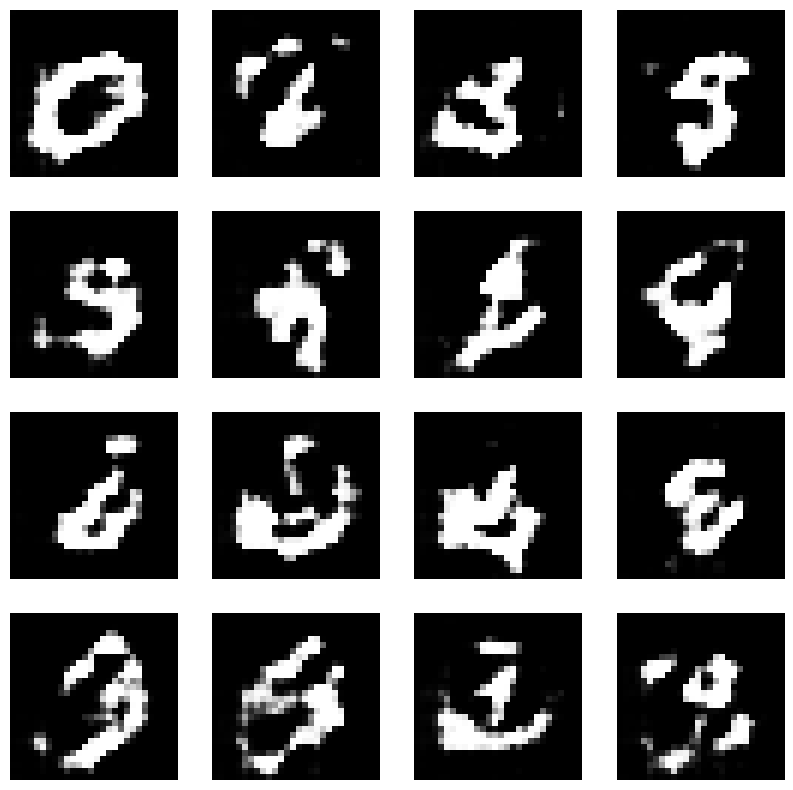

Epoch:  41


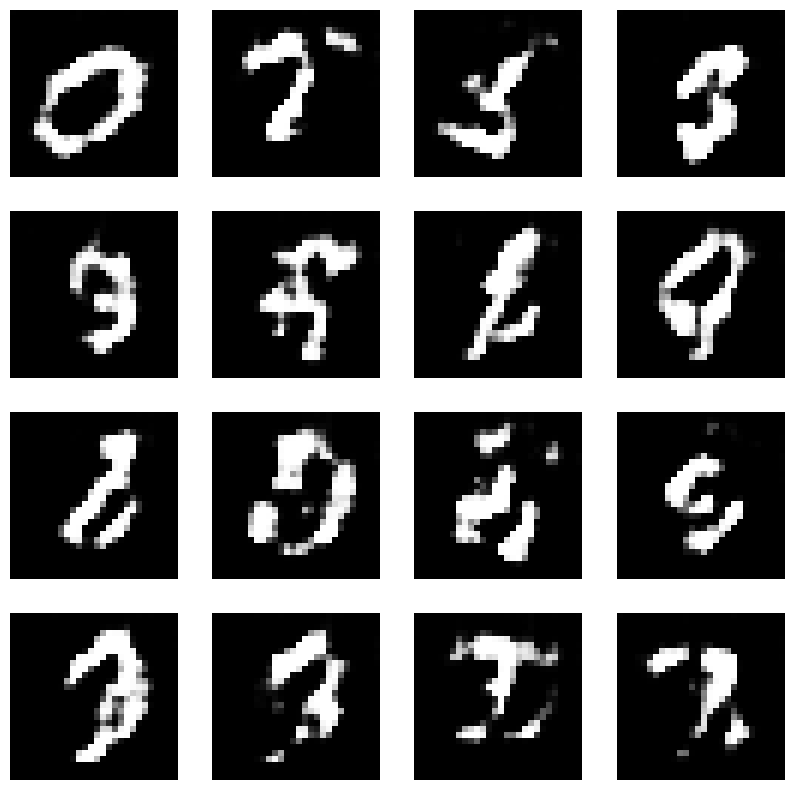

Epoch:  42


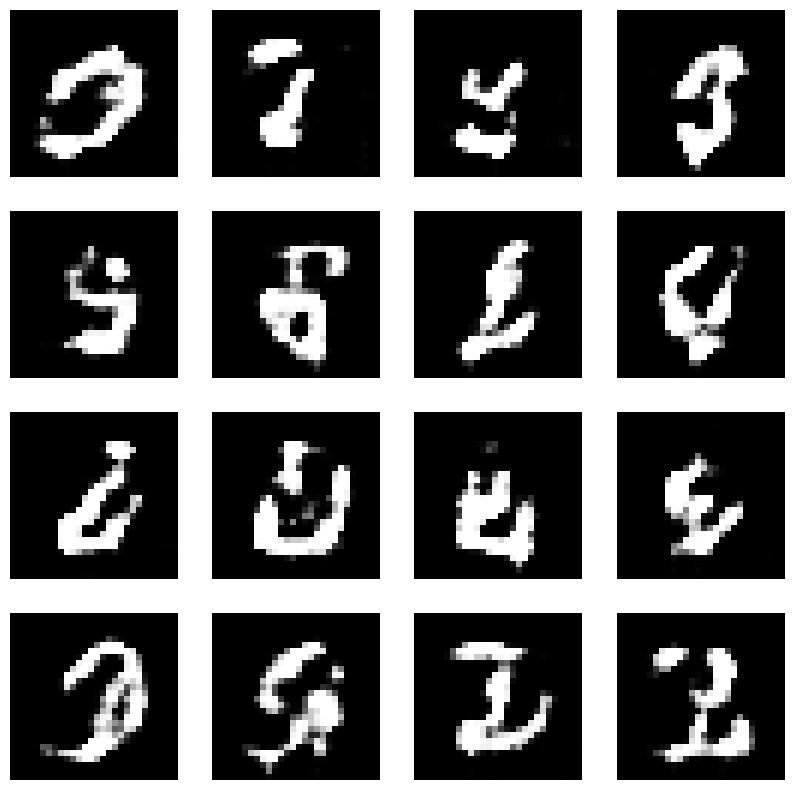

Epoch:  43


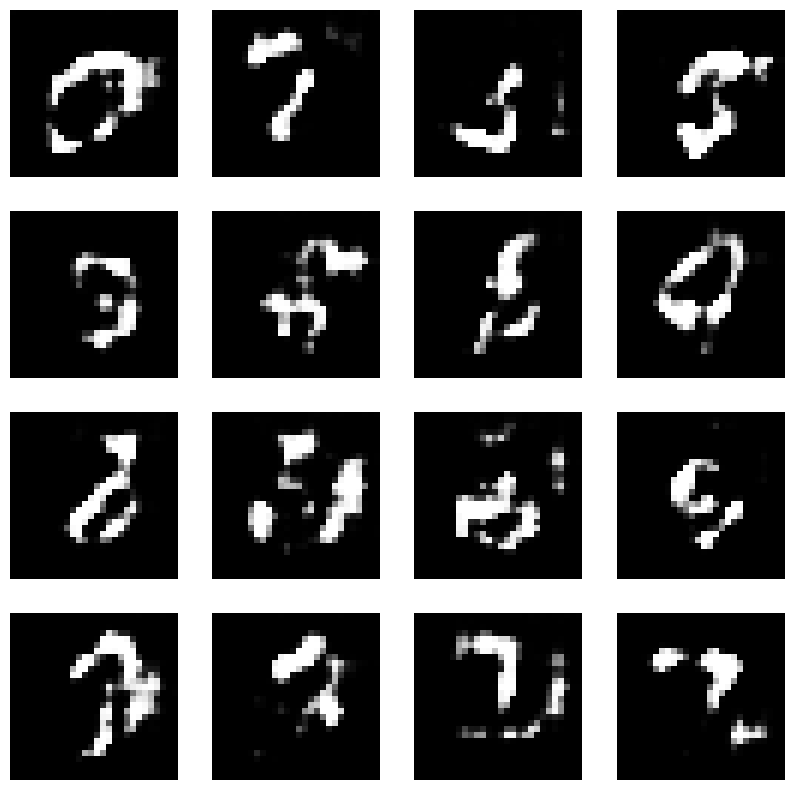

Epoch:  44


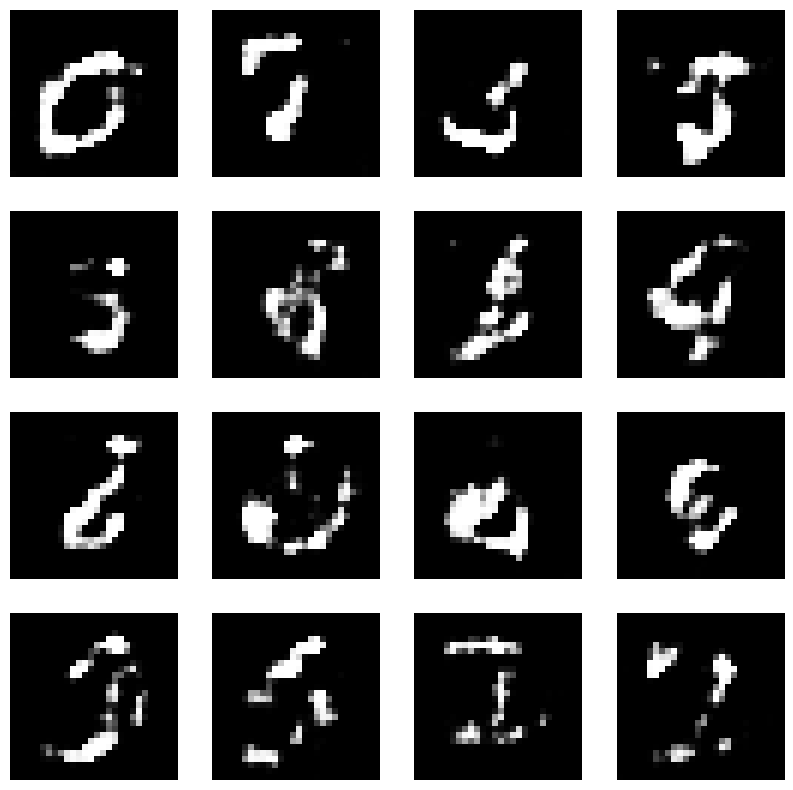

Epoch:  45


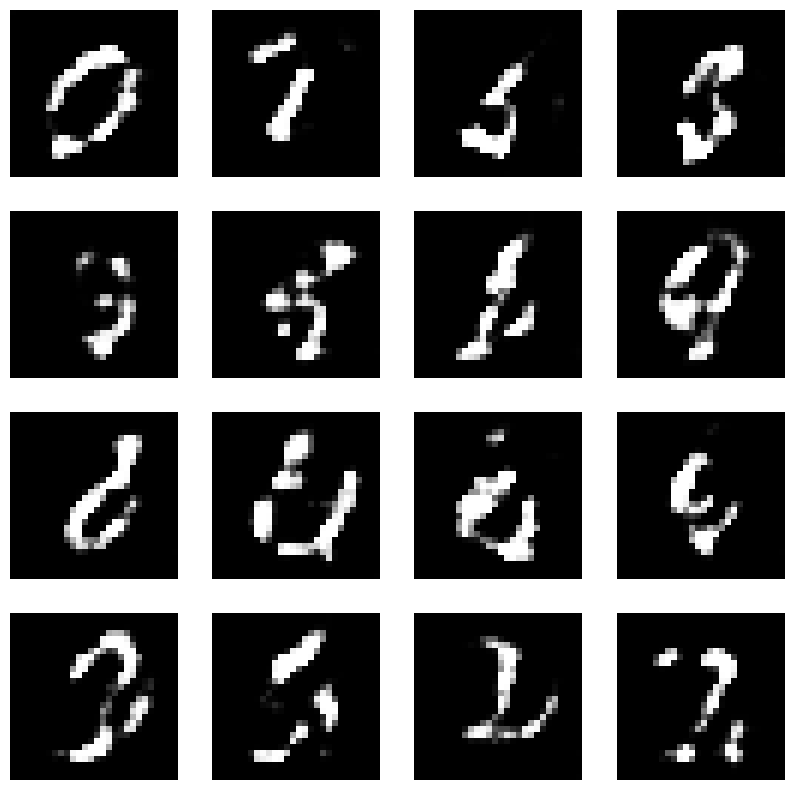

Epoch:  46


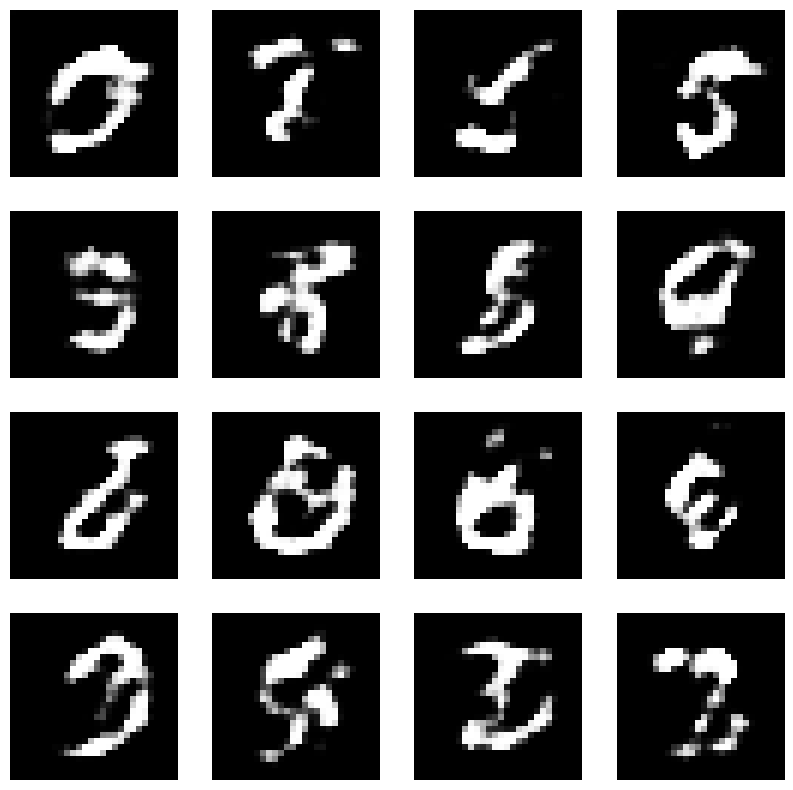

Epoch:  47


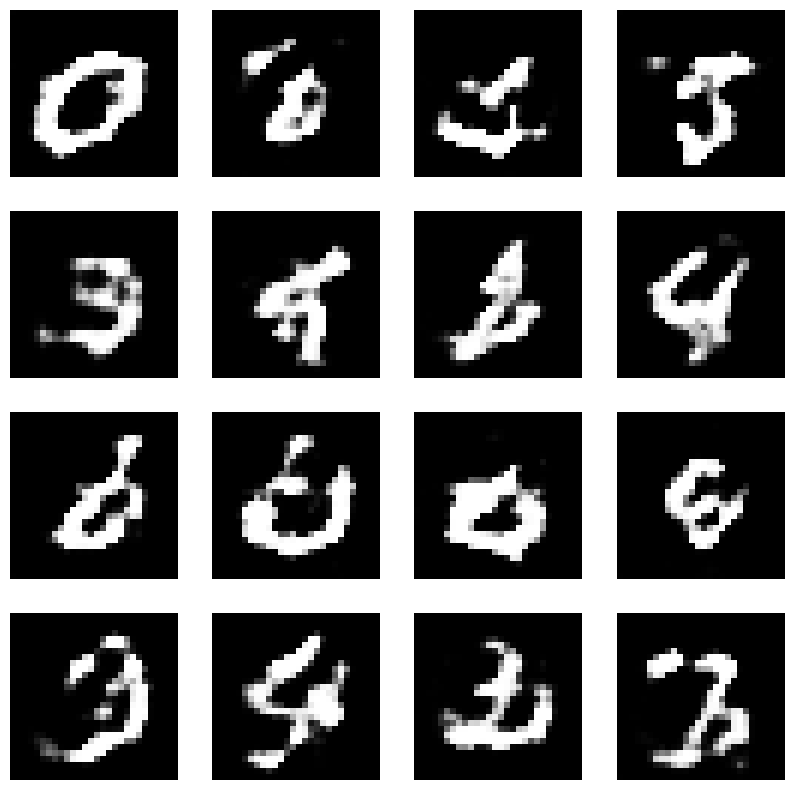

Epoch:  48


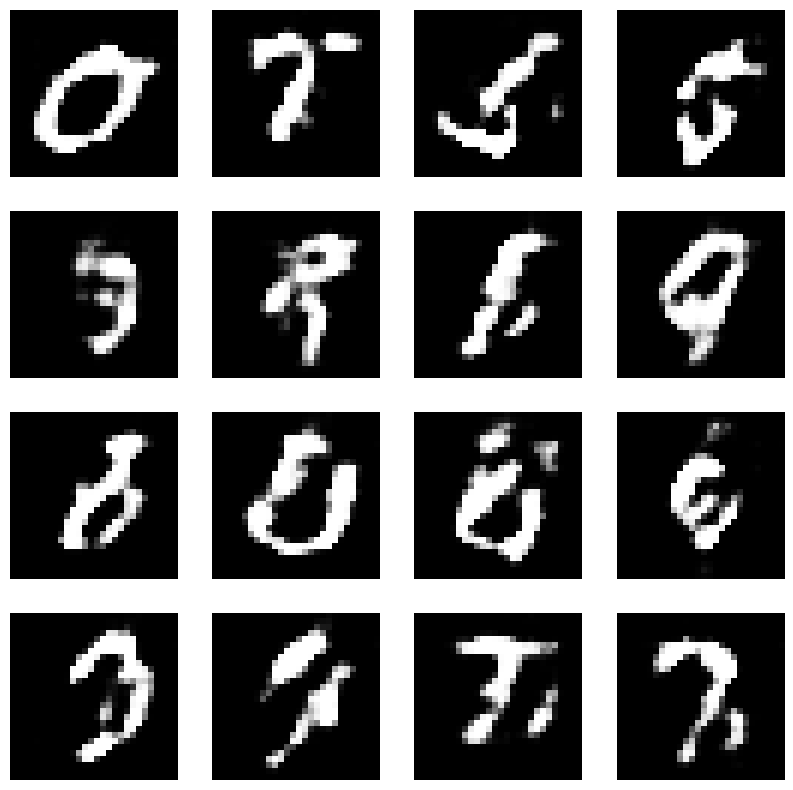

Epoch:  49


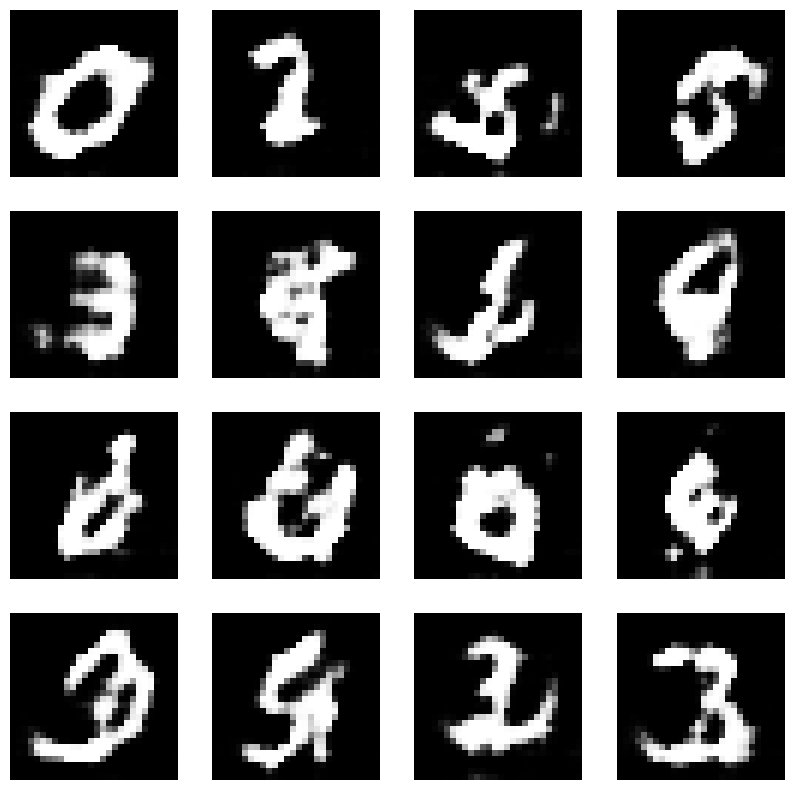

Epoch:  50


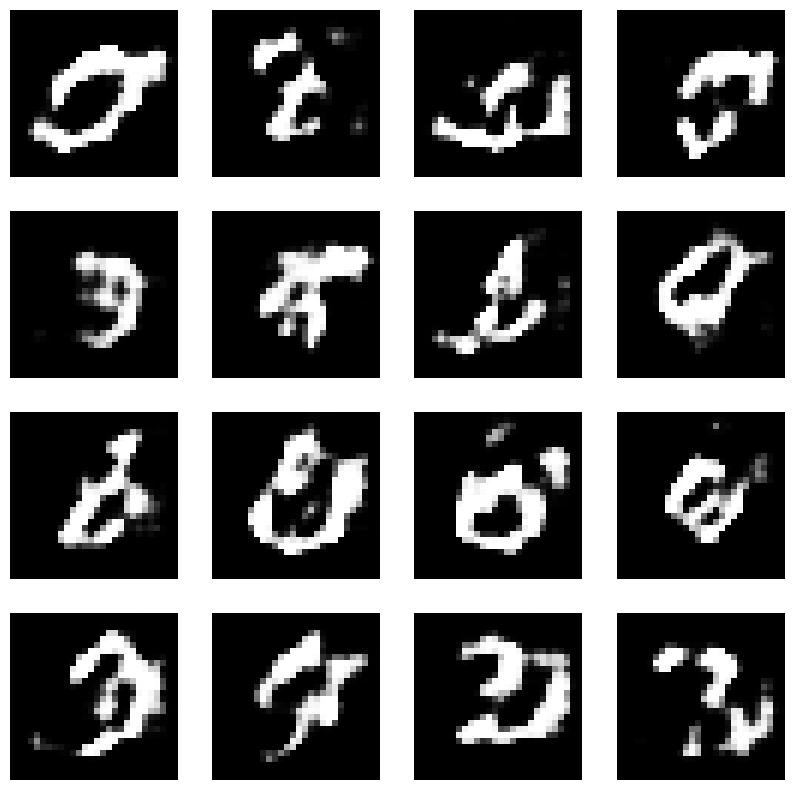

Epoch:  51


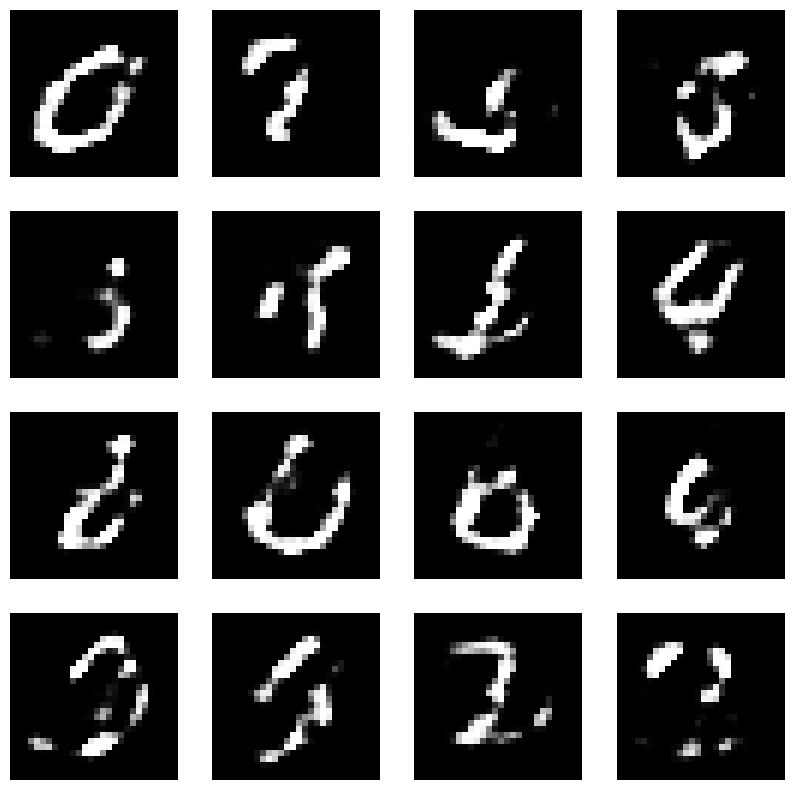

Epoch:  52


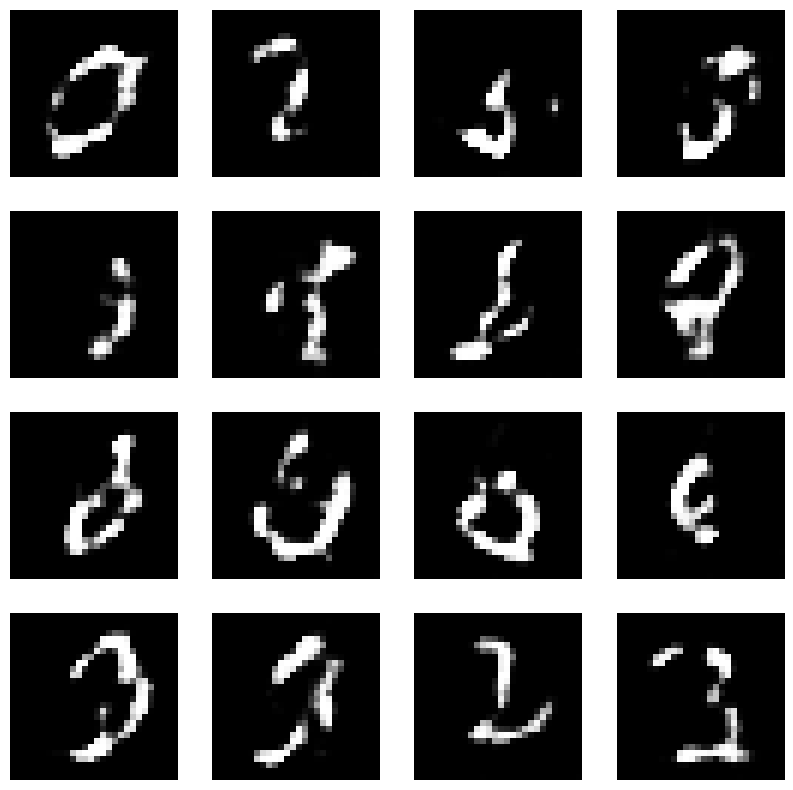

Epoch:  53


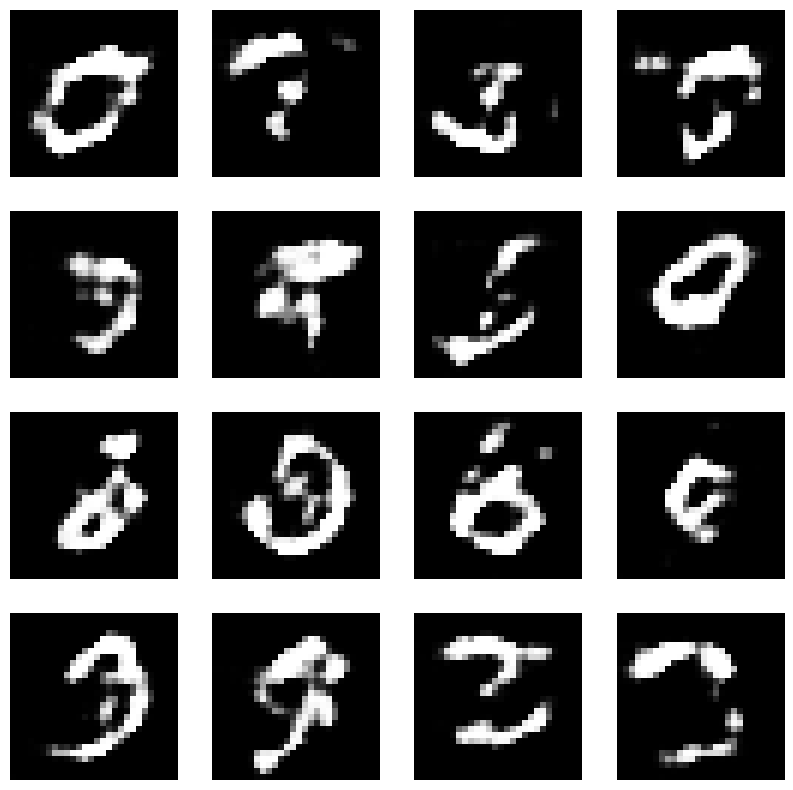

Epoch:  54


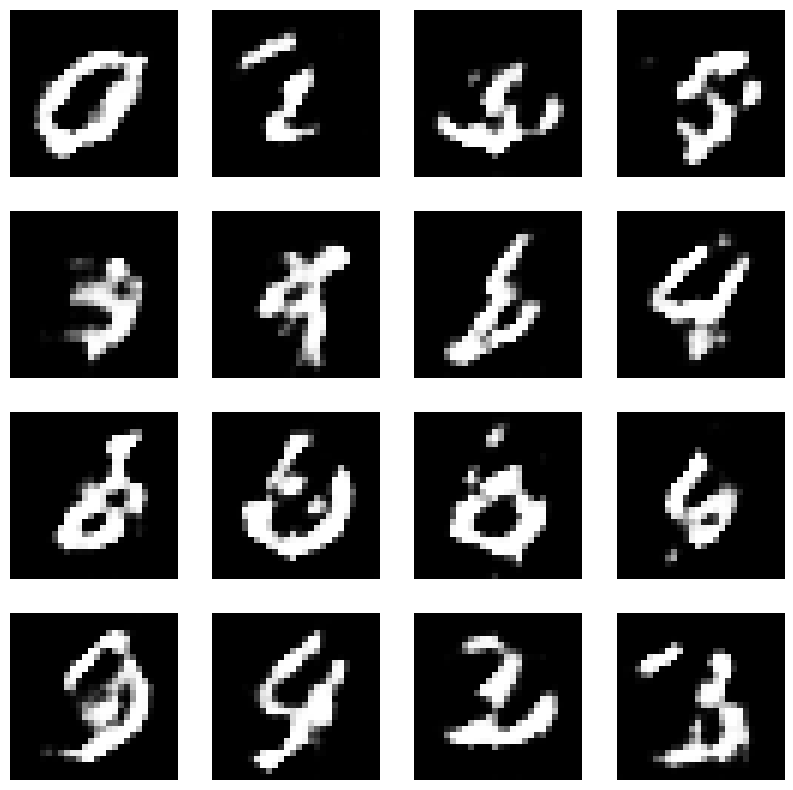

Epoch:  55


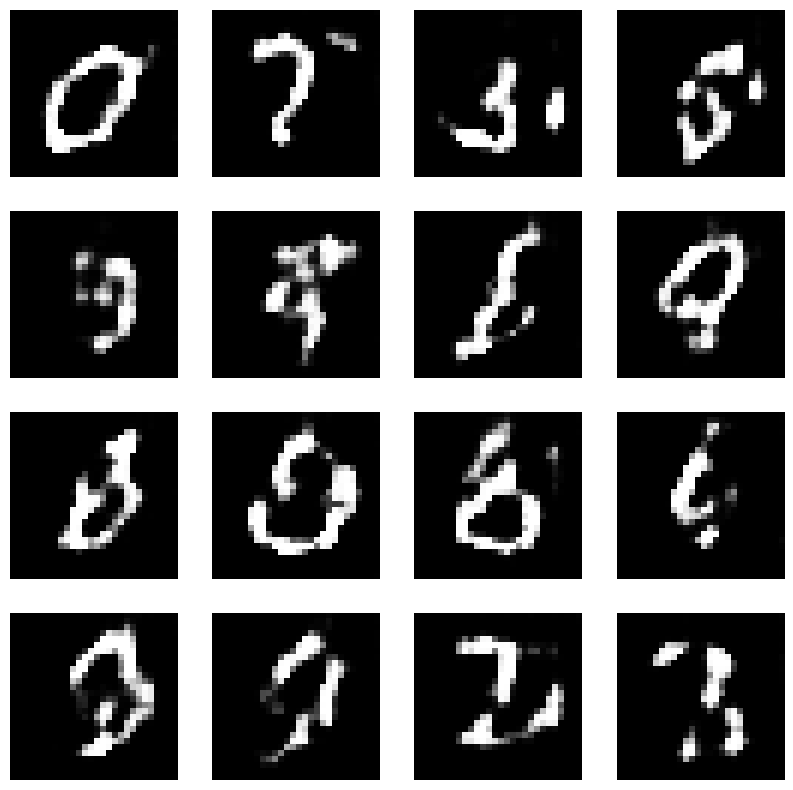

Epoch:  56


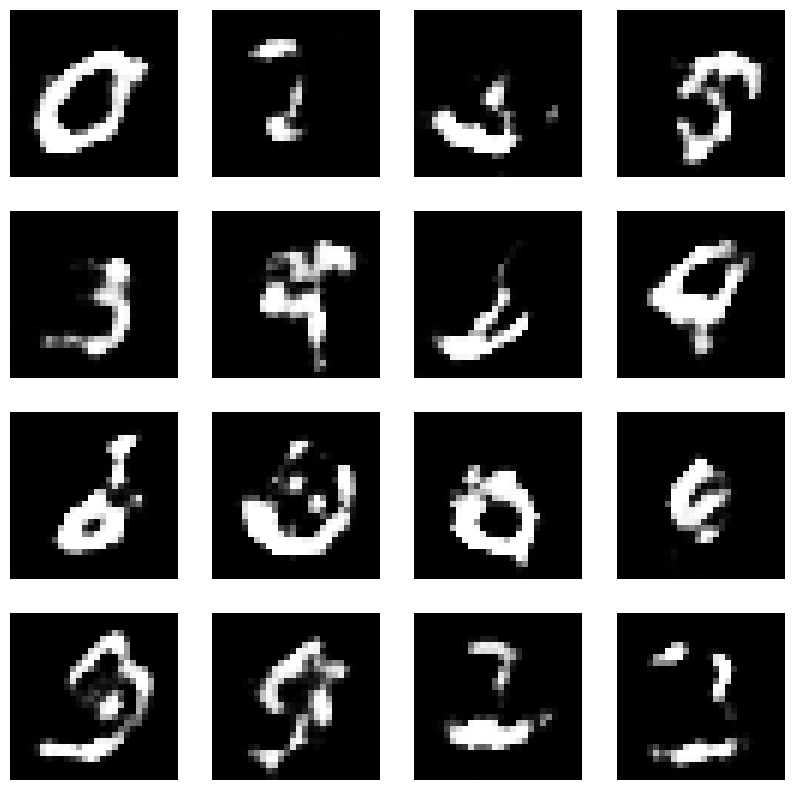

Epoch:  57


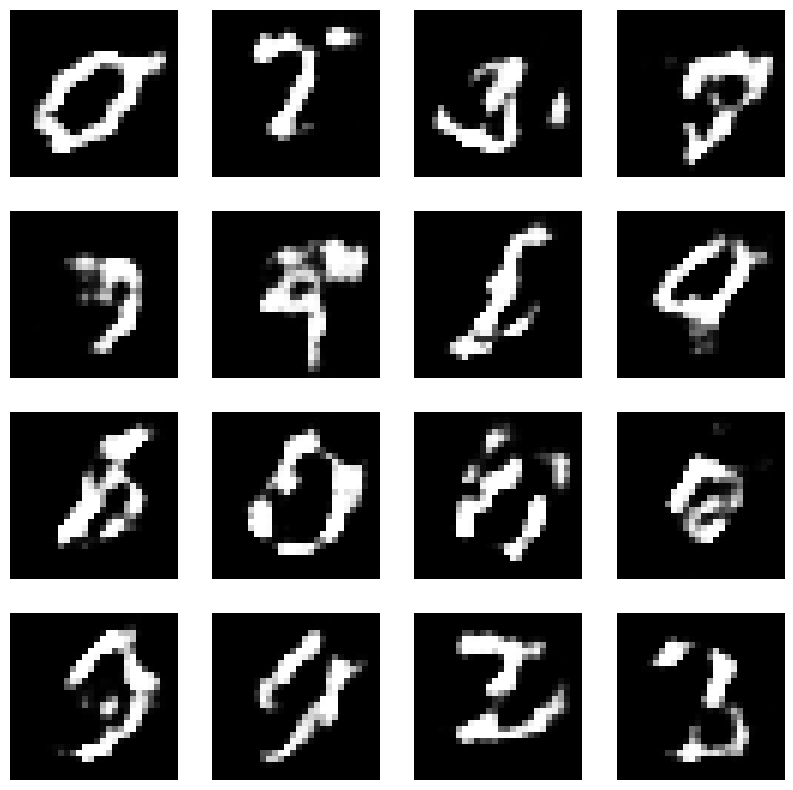

Epoch:  58


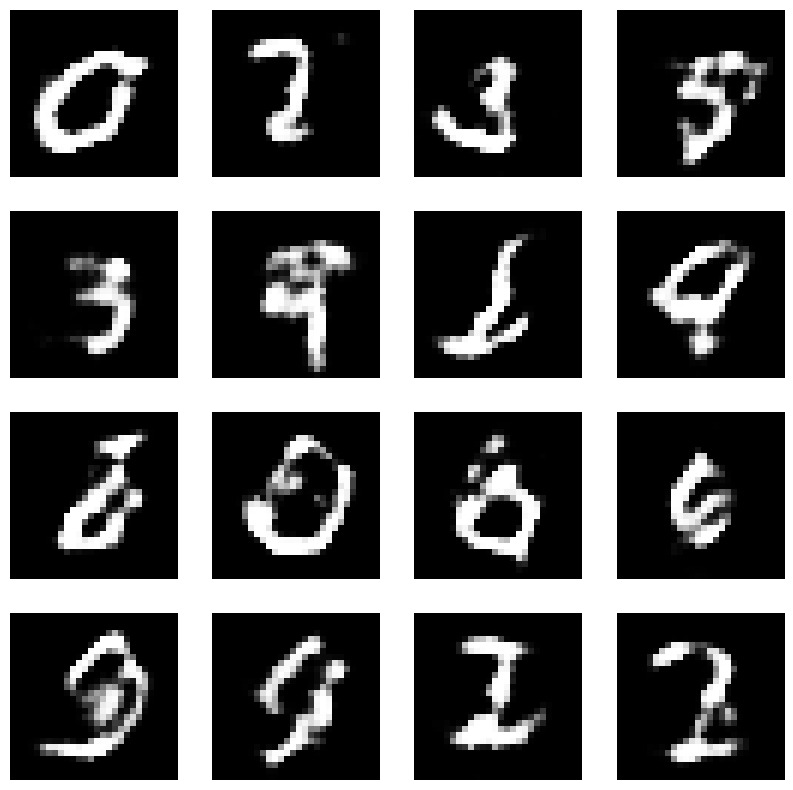

Epoch:  59


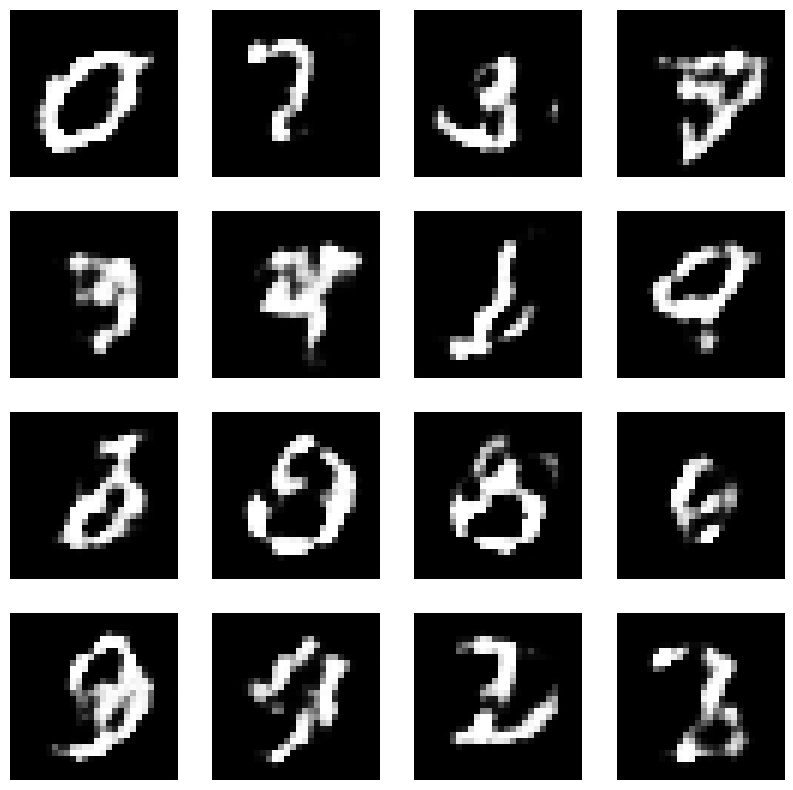

Epoch:  60


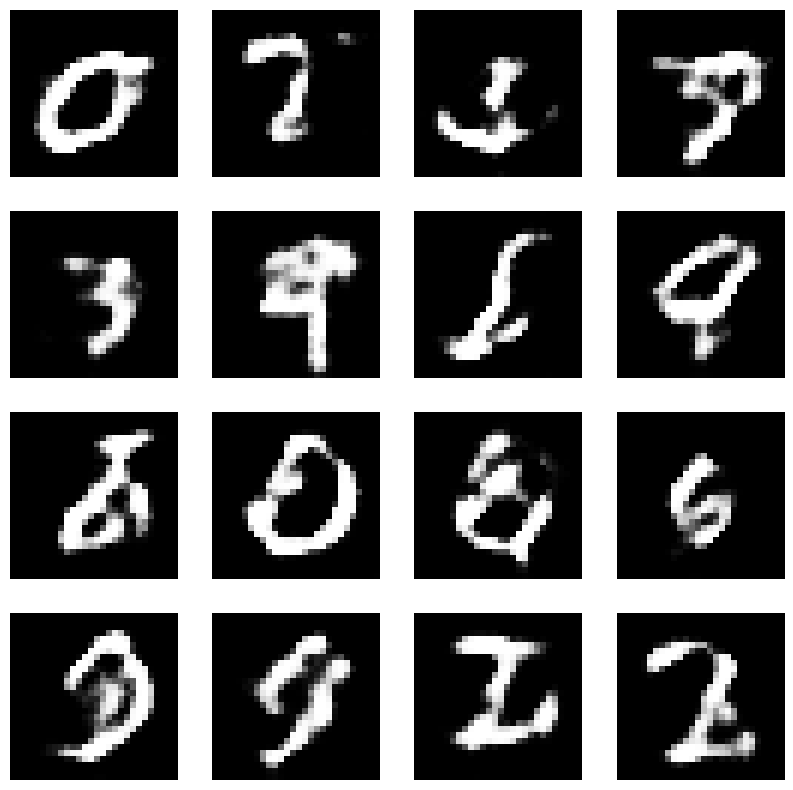

Epoch:  61


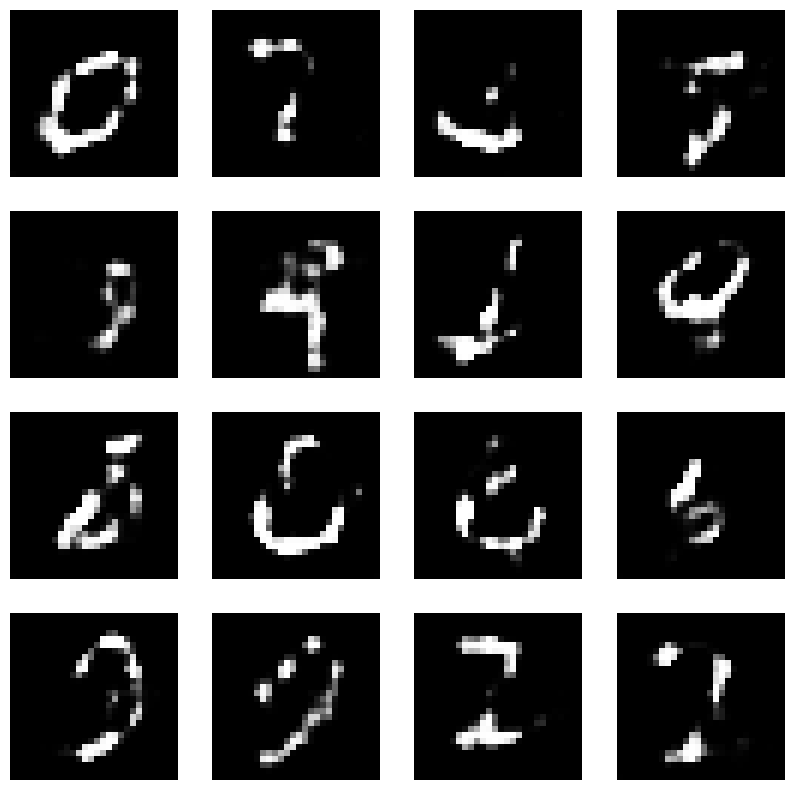

Epoch:  62


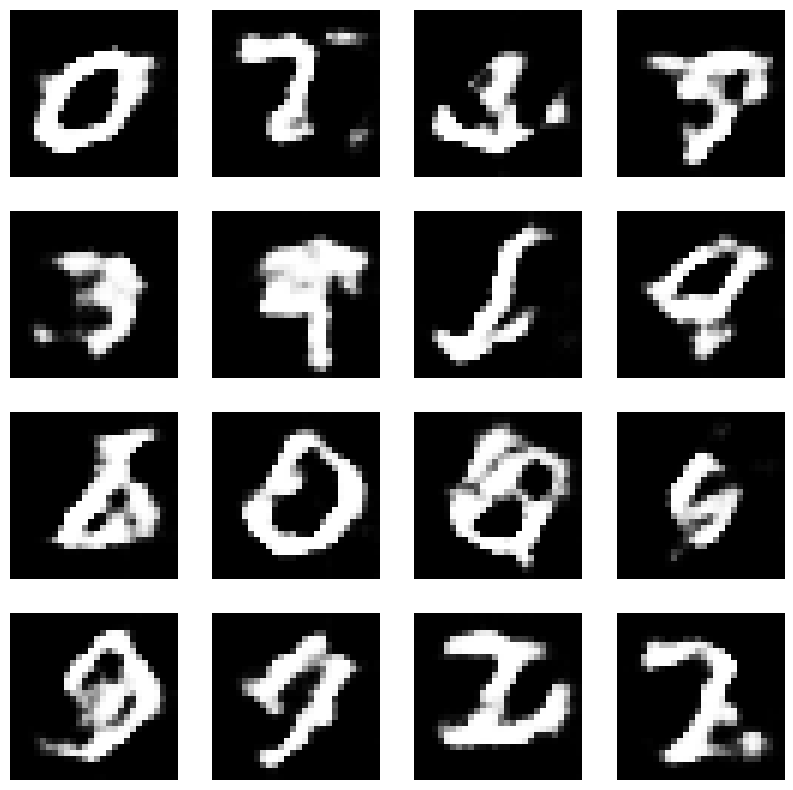

Epoch:  63


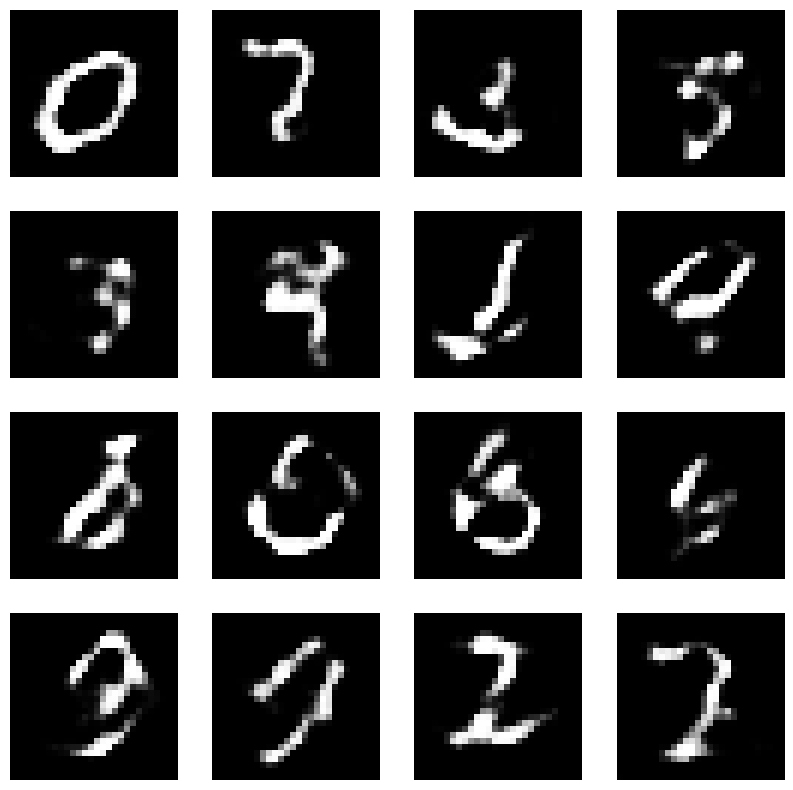

Epoch:  64


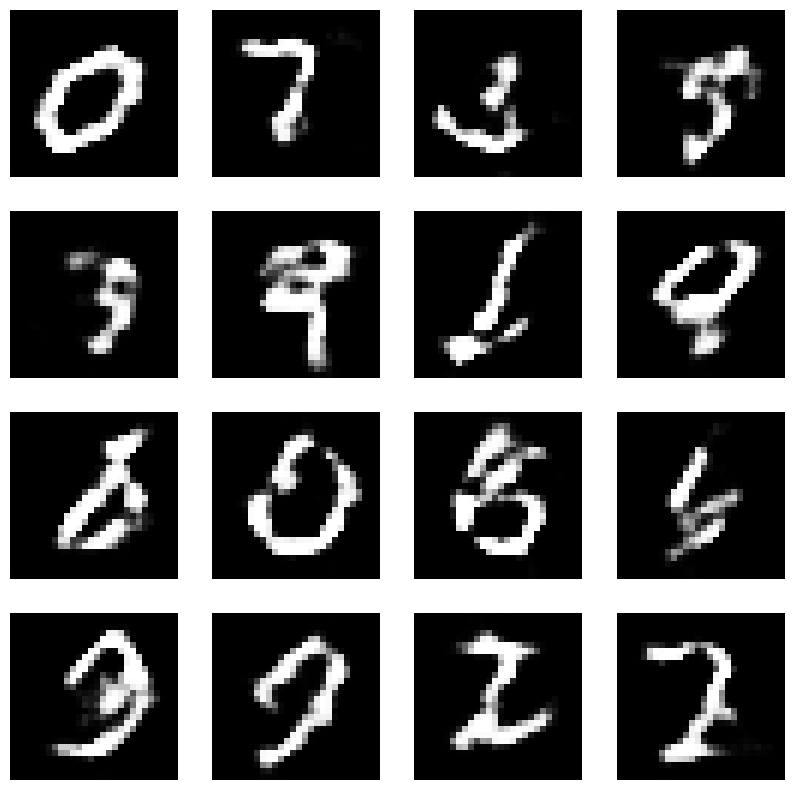

Epoch:  65


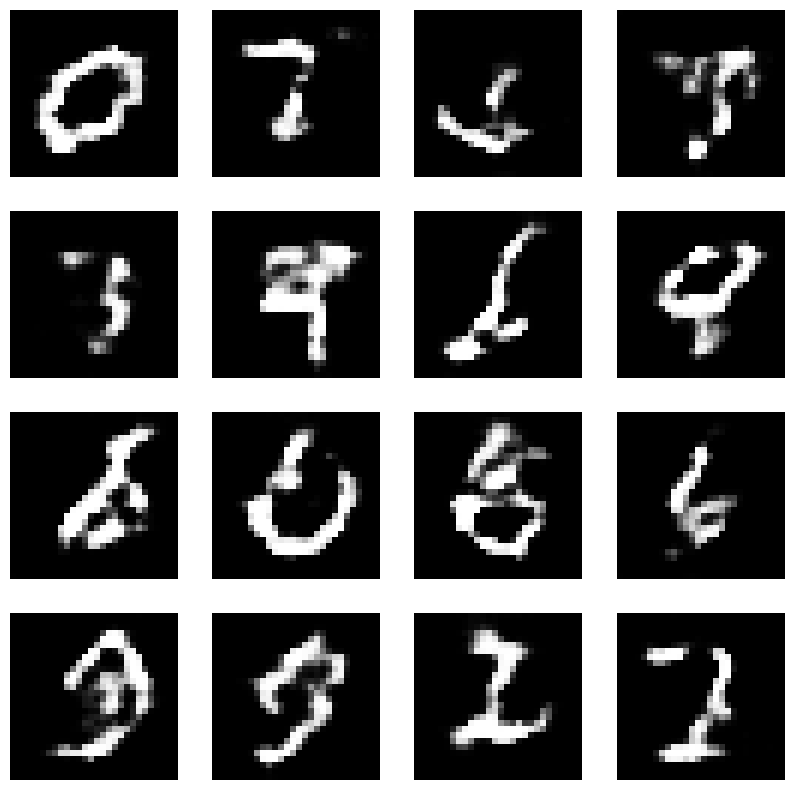

Epoch:  66


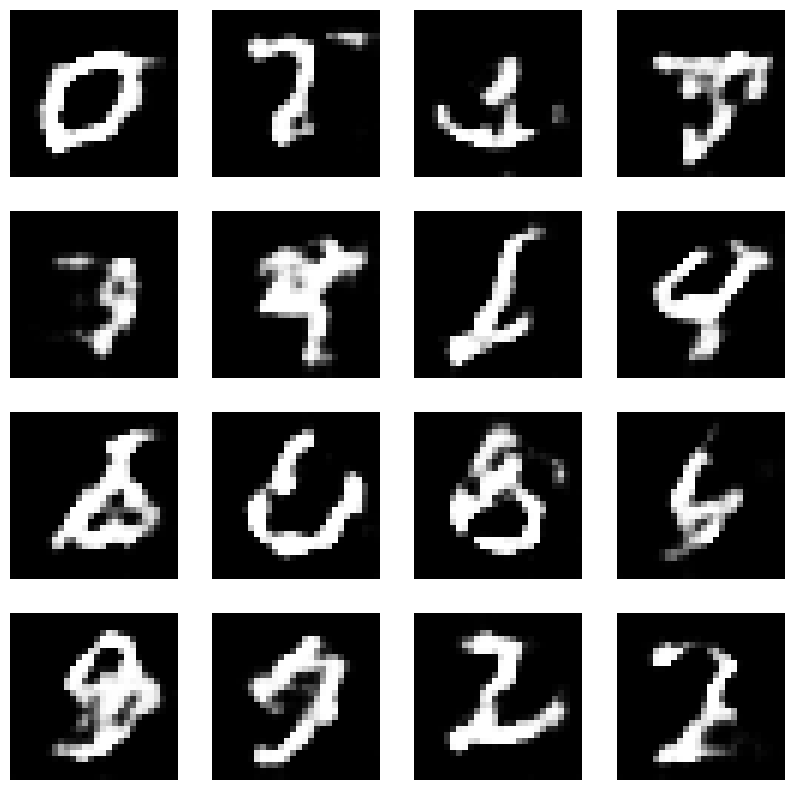

Epoch:  67


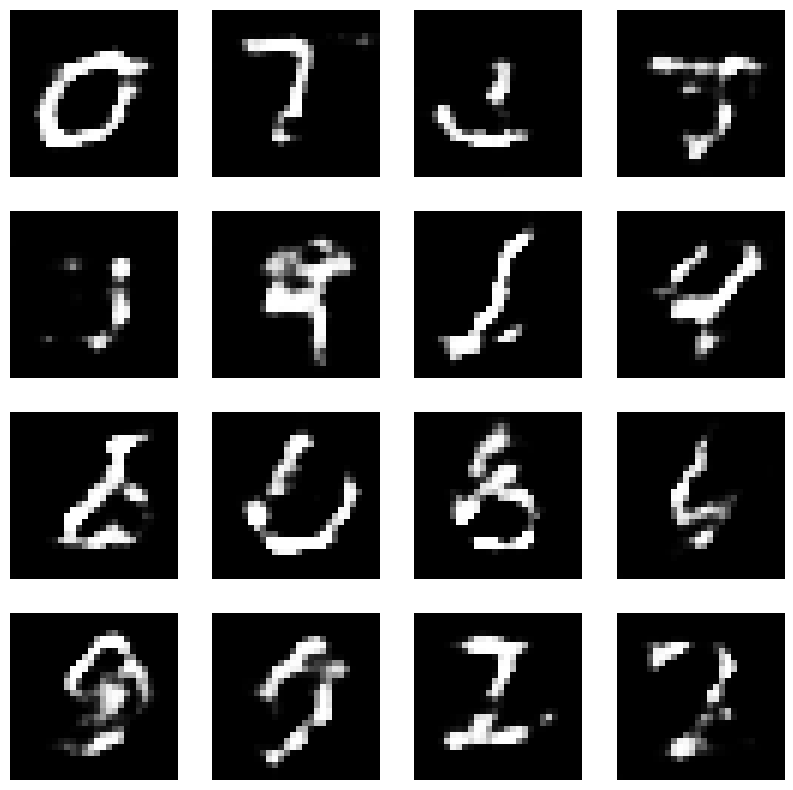

Epoch:  68


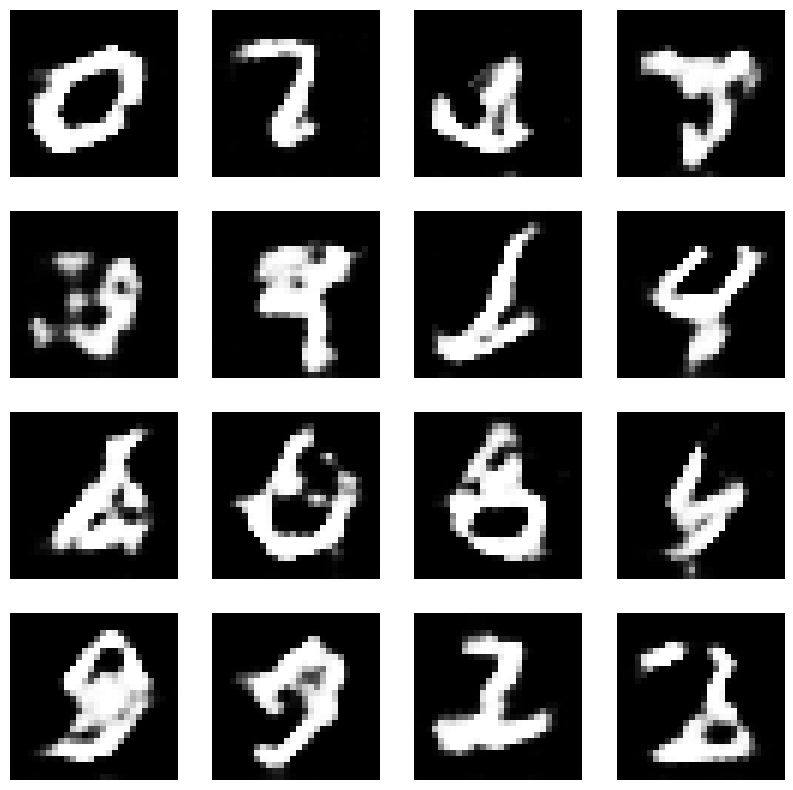

Epoch:  69


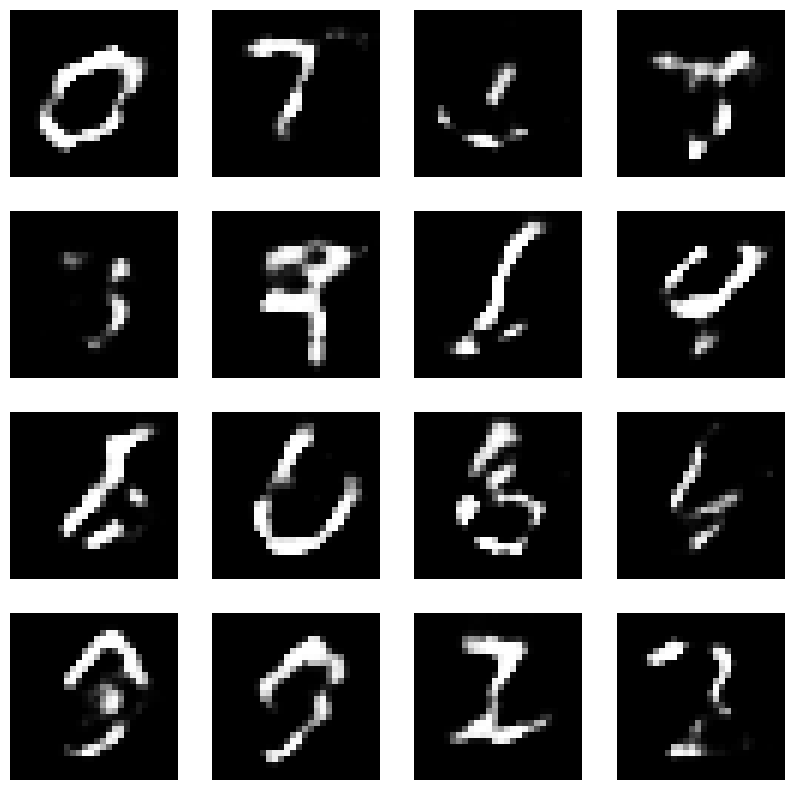

Epoch:  70


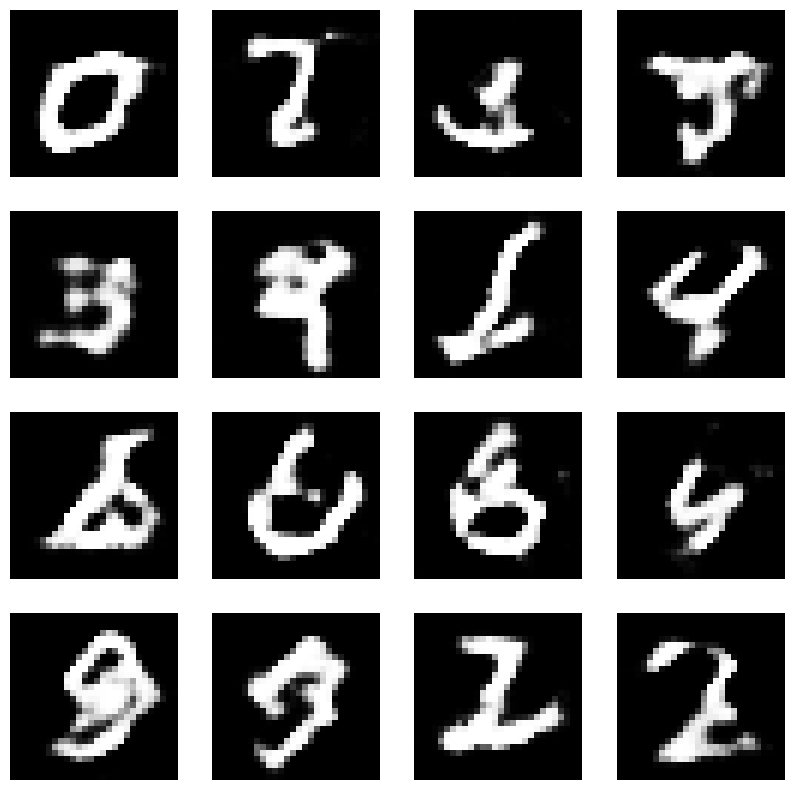

Epoch:  71


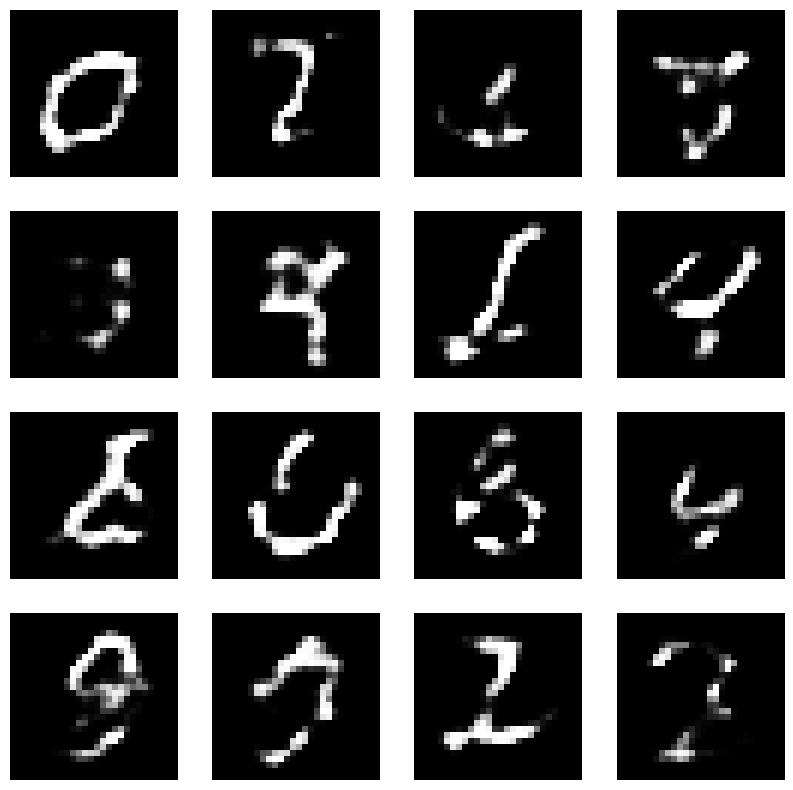

Epoch:  72


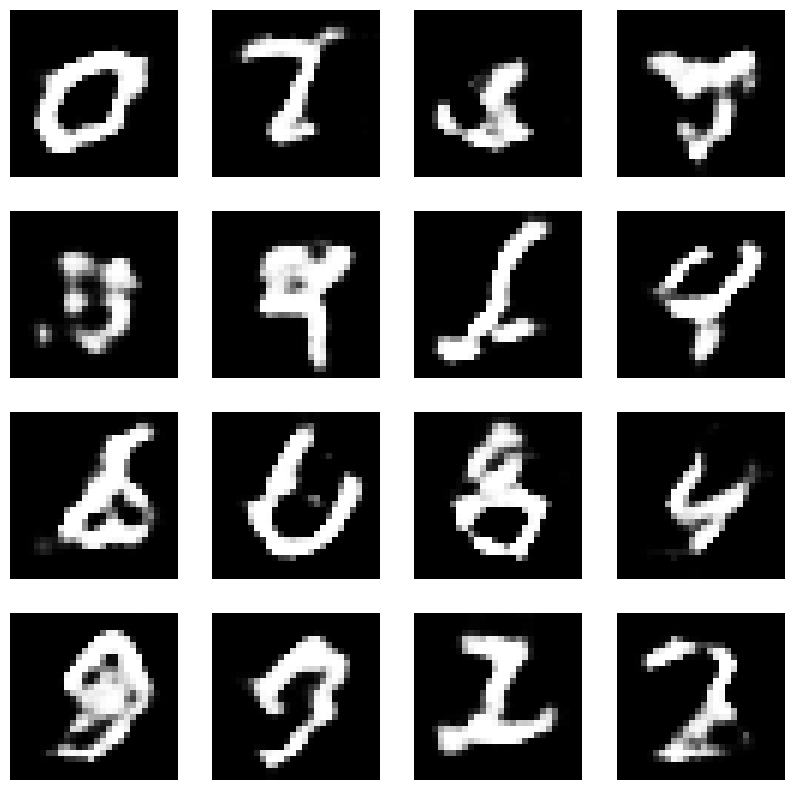

Epoch:  73


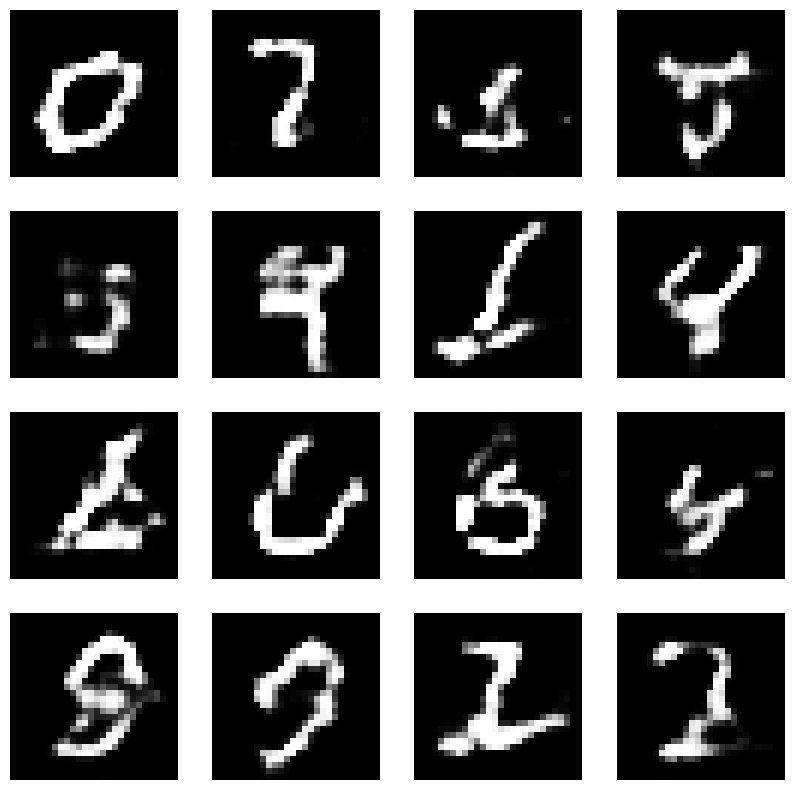

Epoch:  74


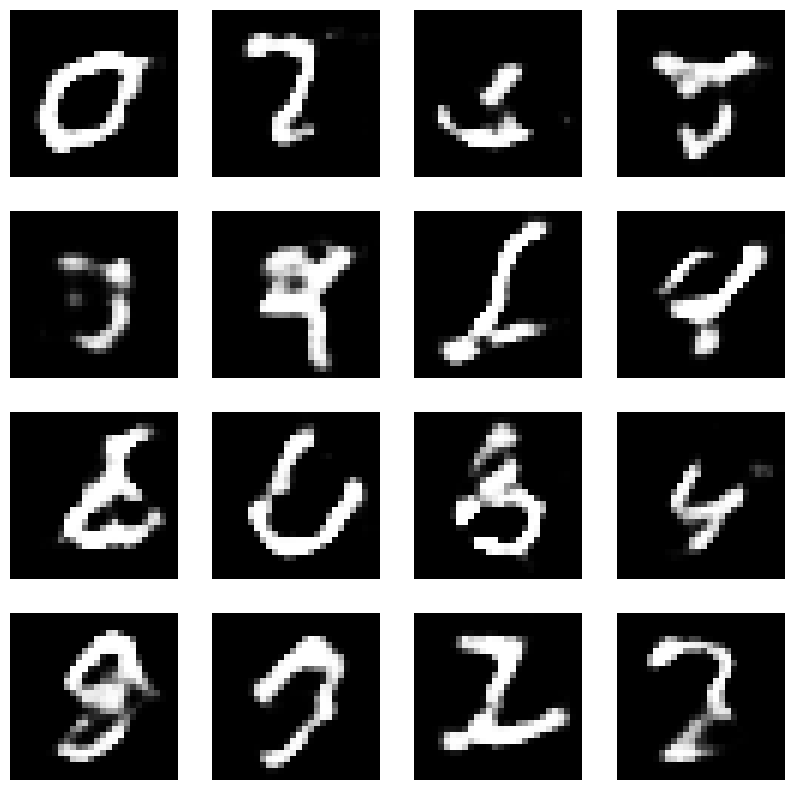

Epoch:  75


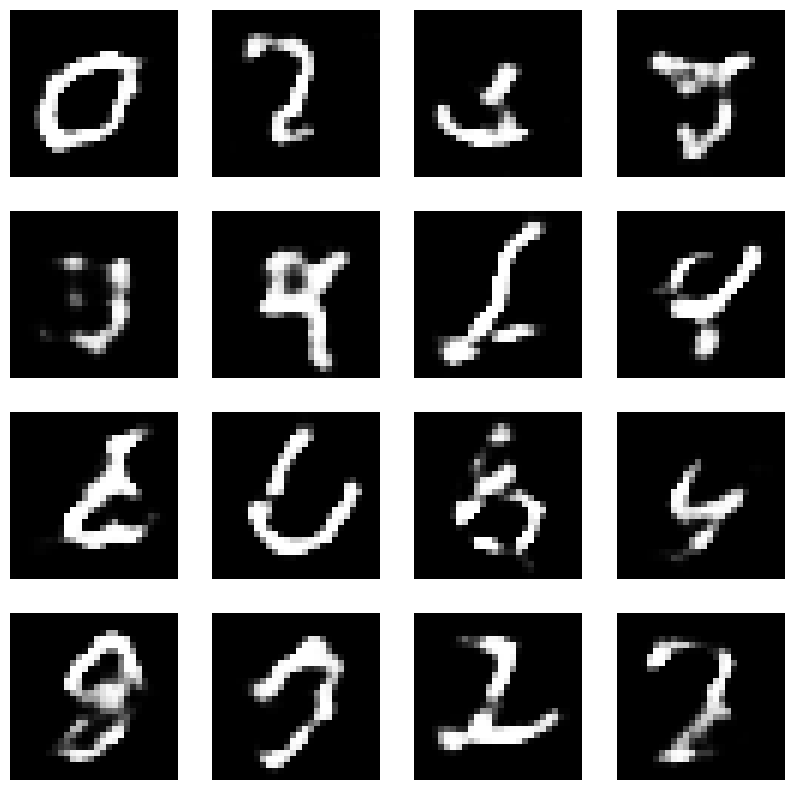

Epoch:  76


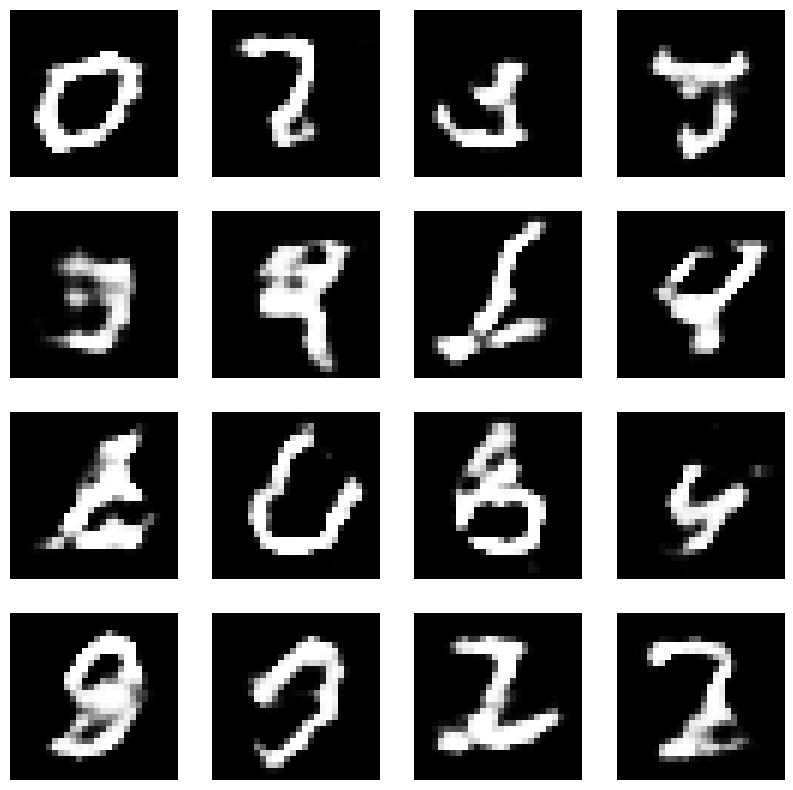

Epoch:  77


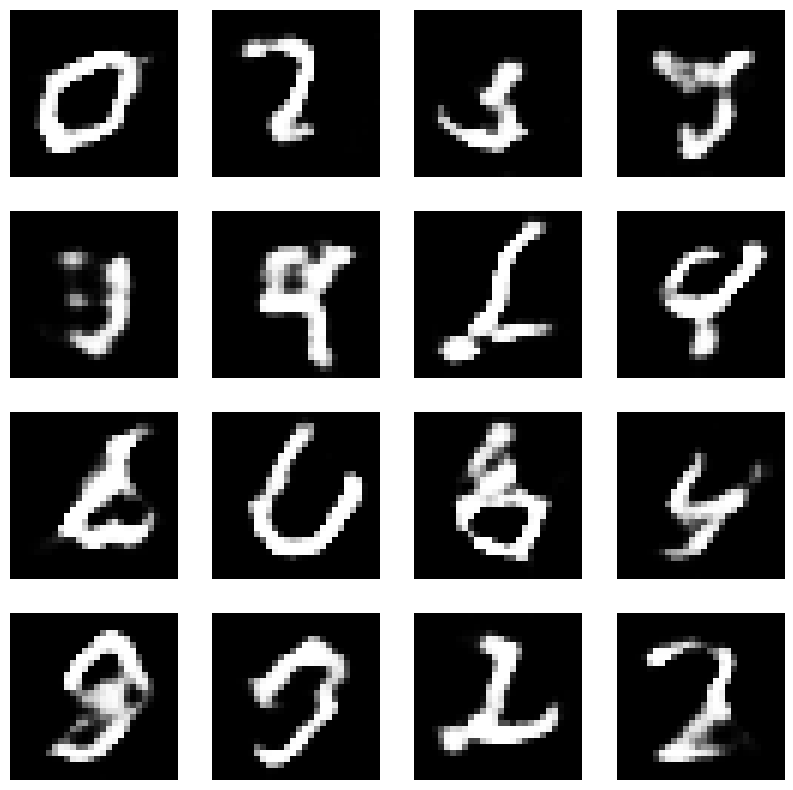

Epoch:  78


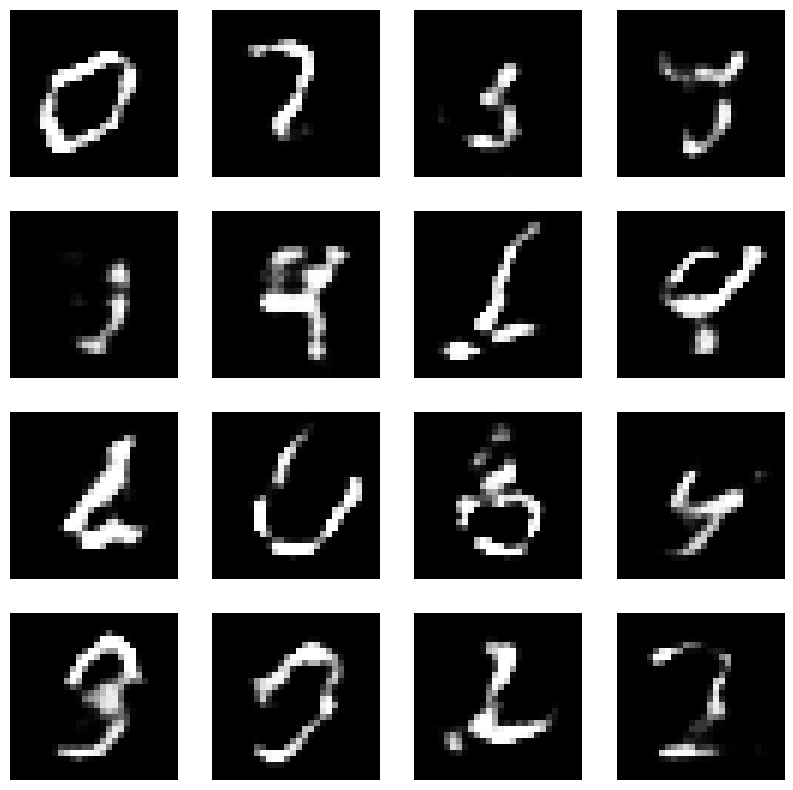

Epoch:  79


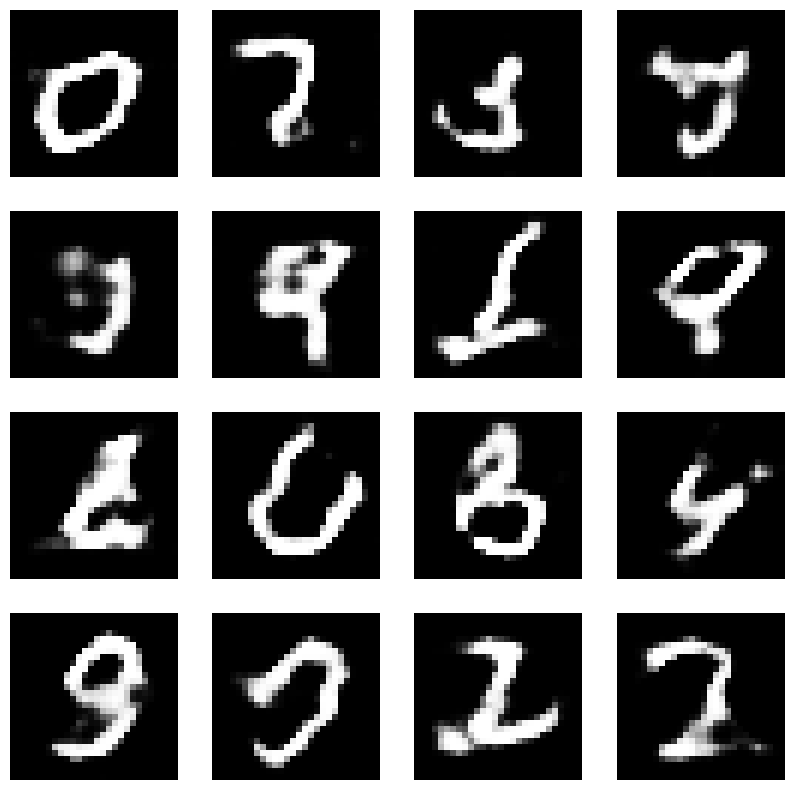

Epoch:  80


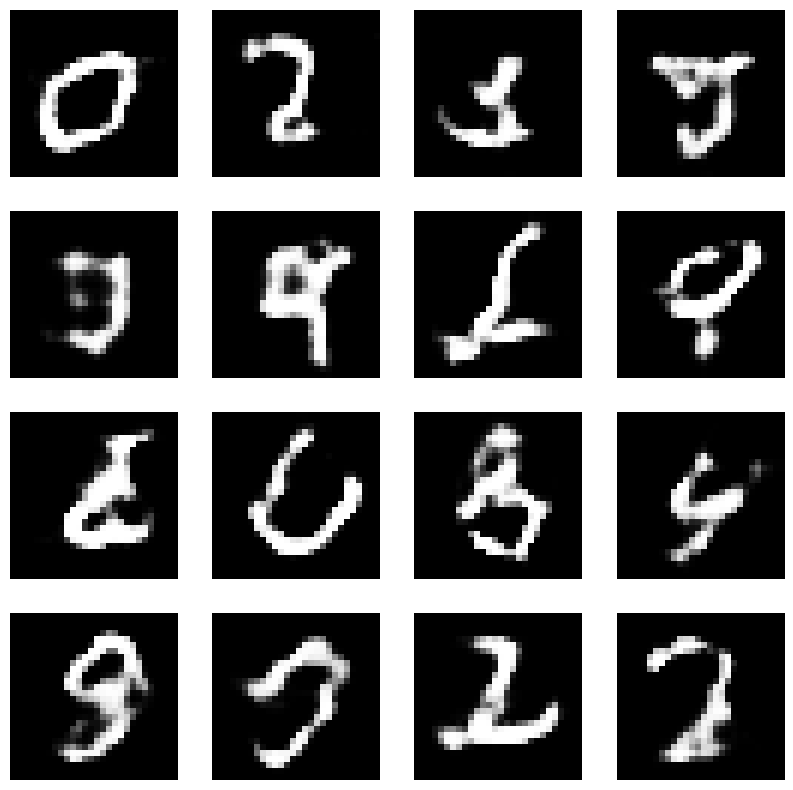

Epoch:  81


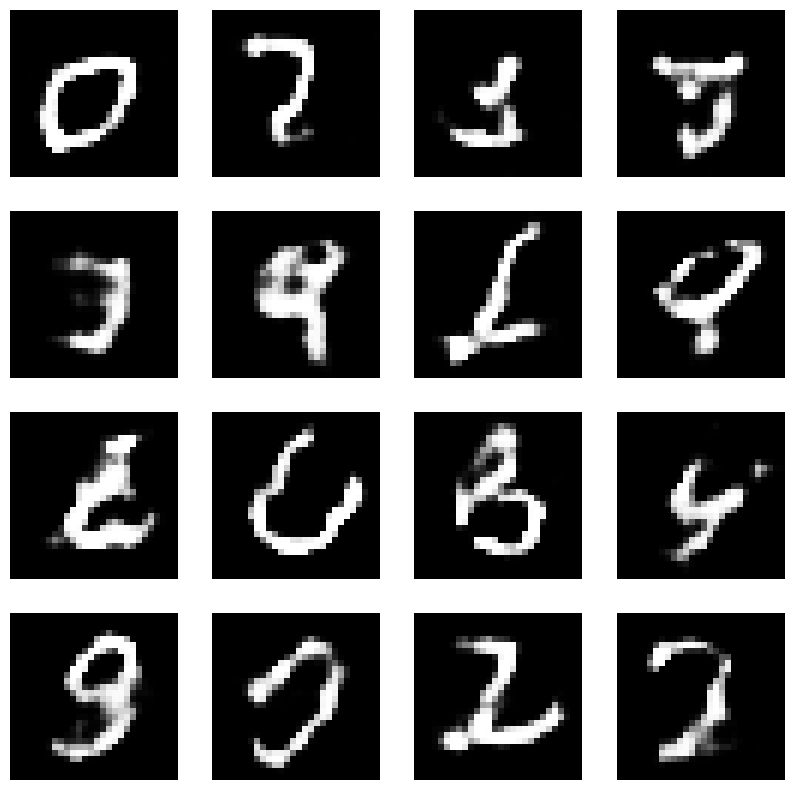

Epoch:  82


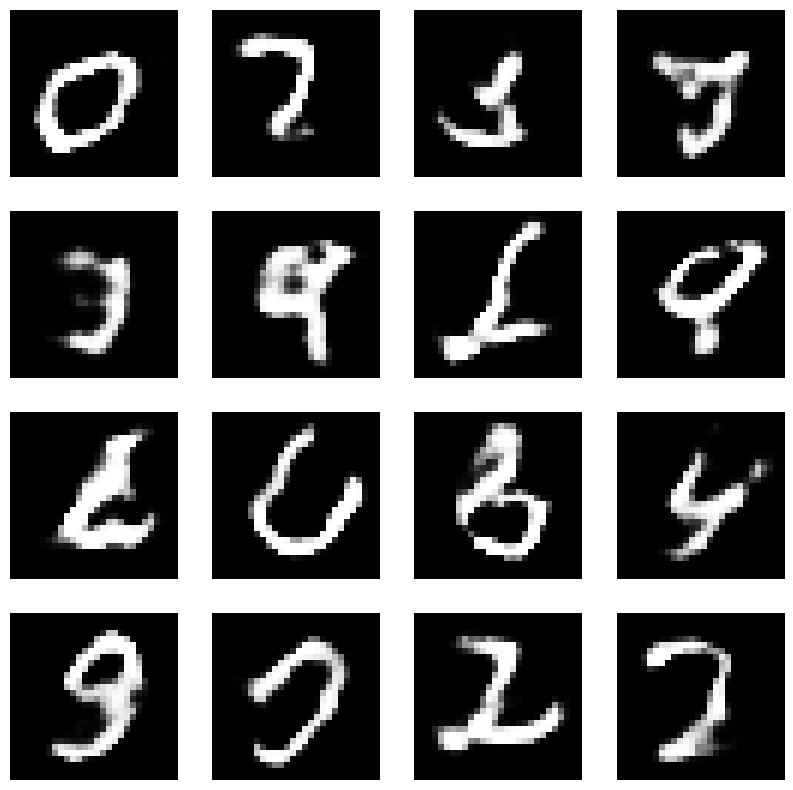

Epoch:  83


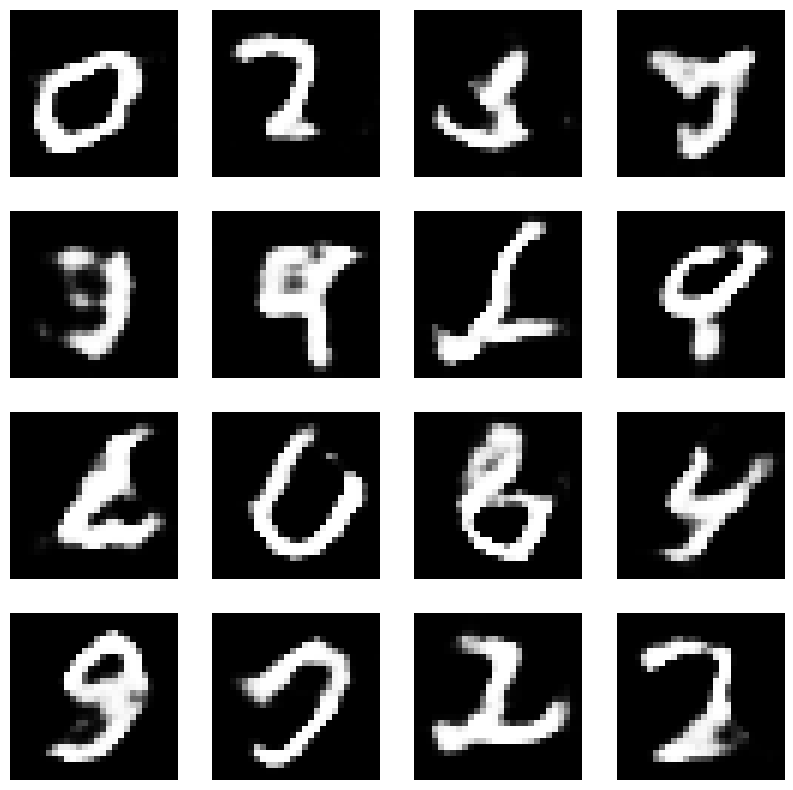

Epoch:  84


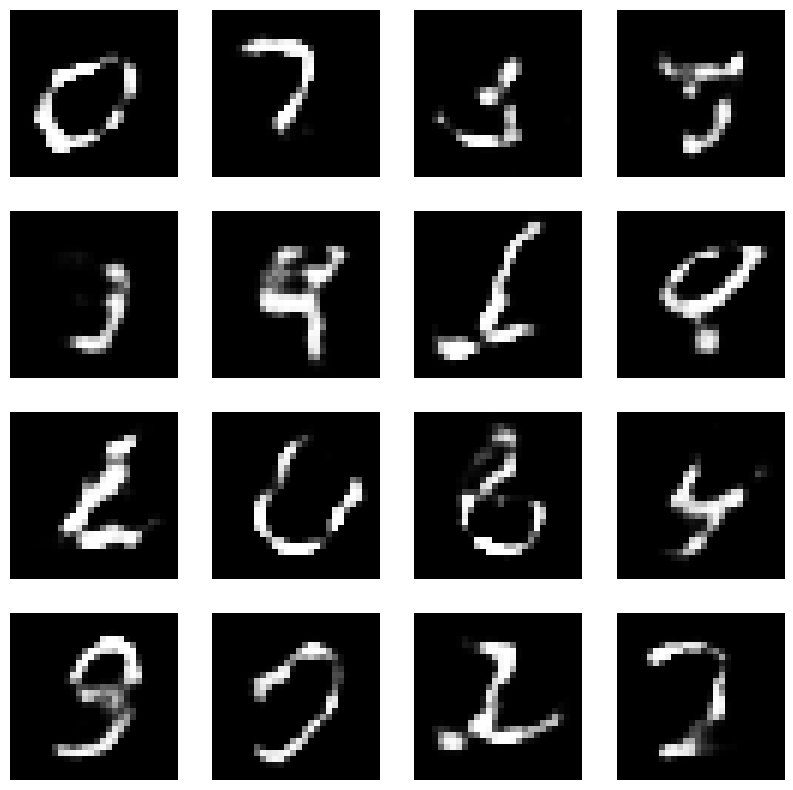

Epoch:  85


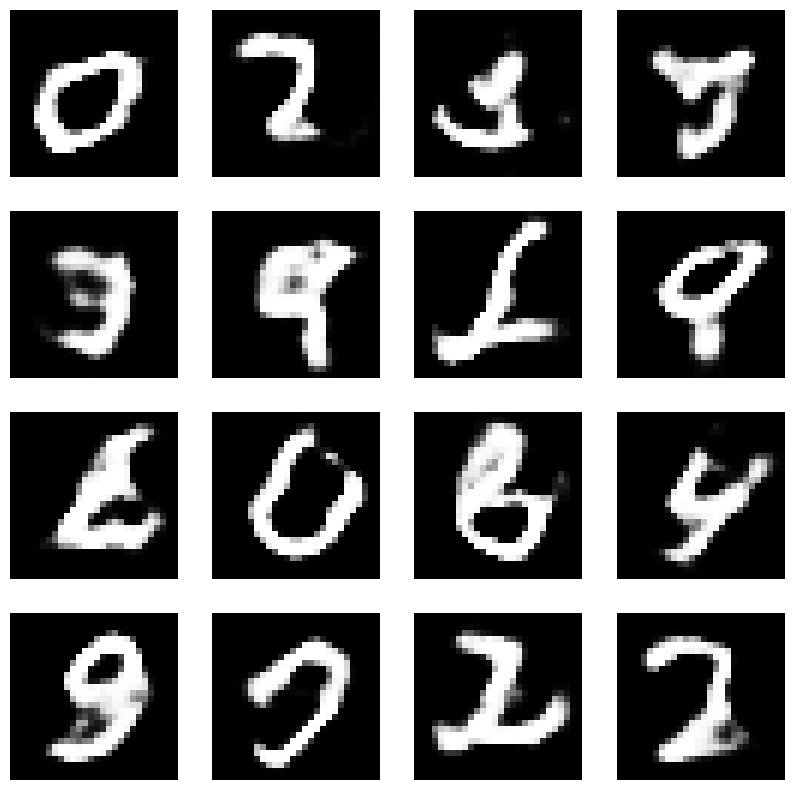

Epoch:  86


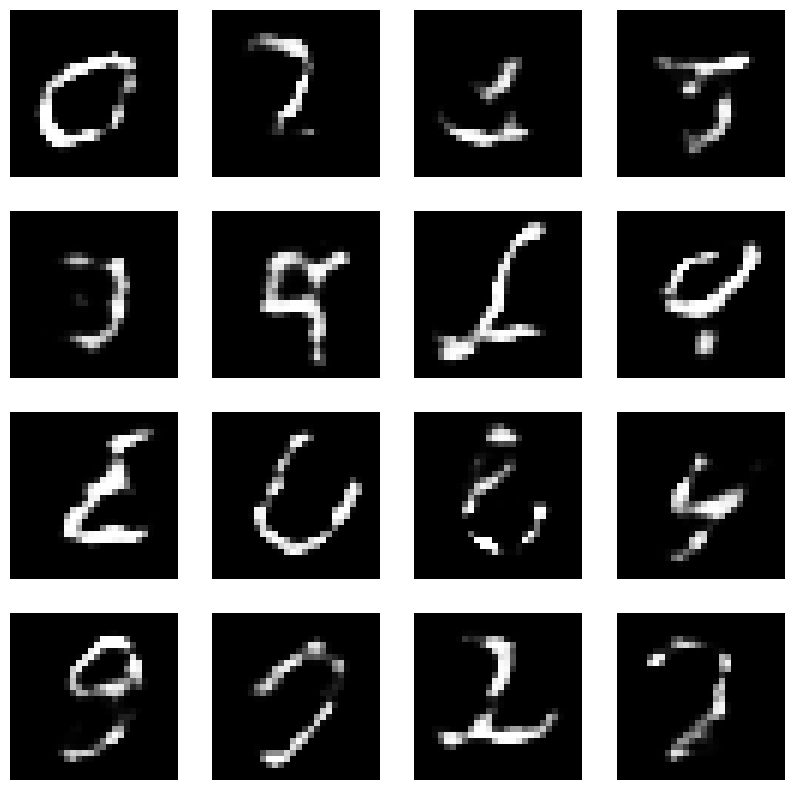

Epoch:  87


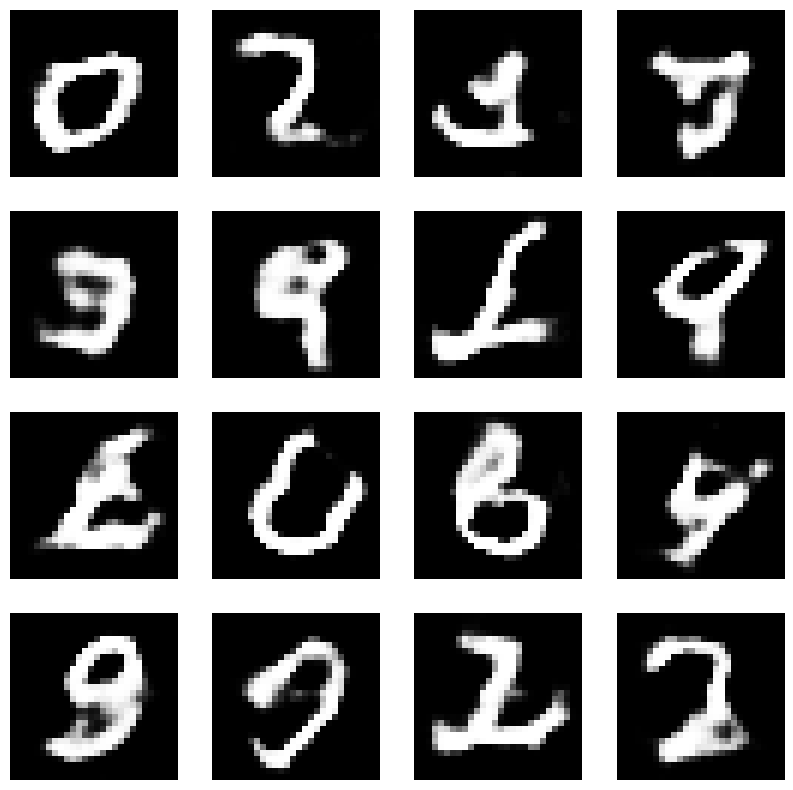

Epoch:  88


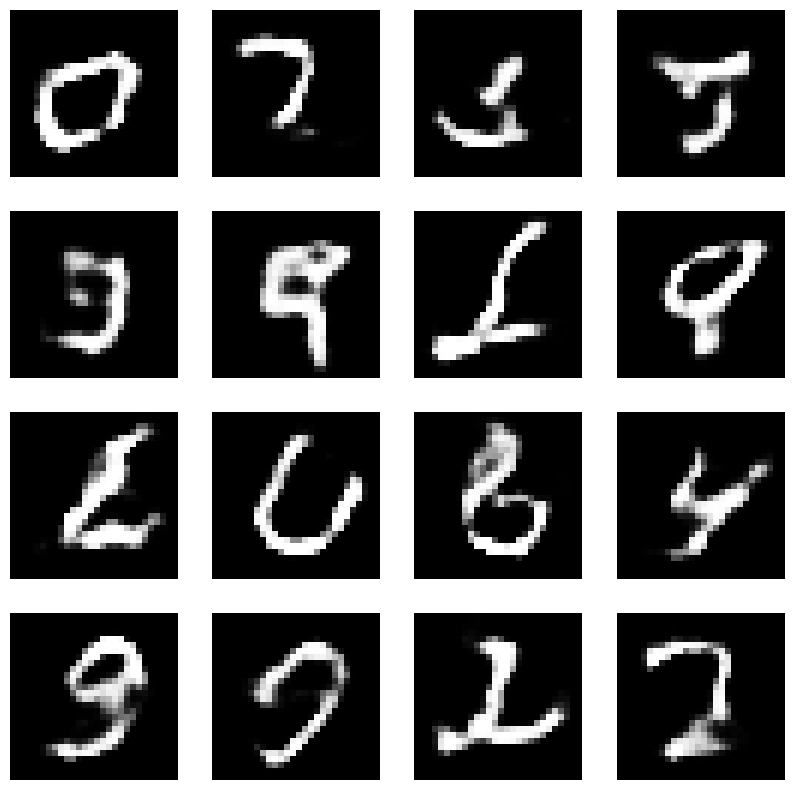

Epoch:  89


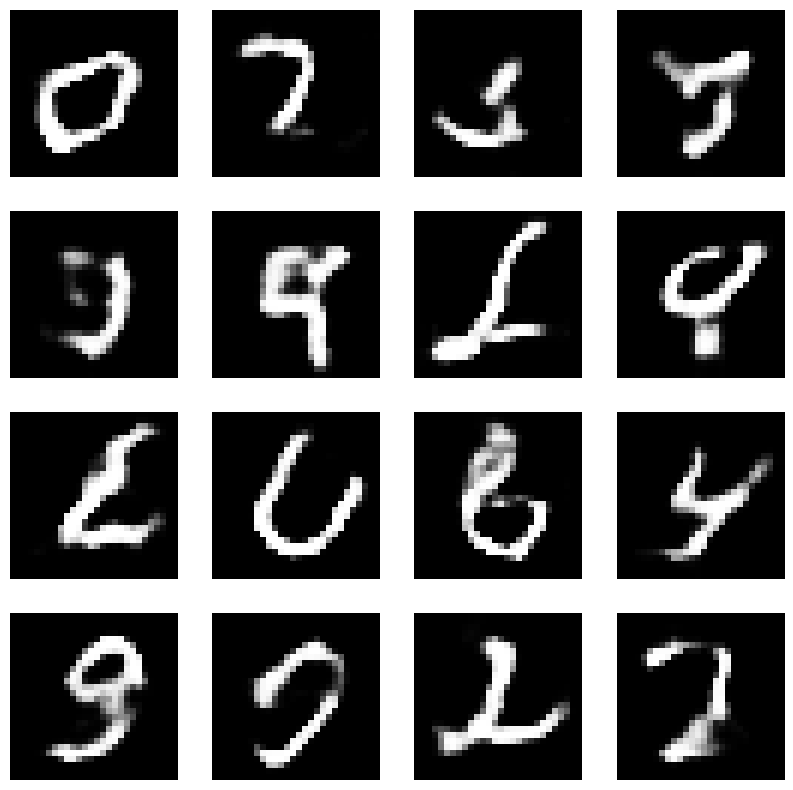

Epoch:  90


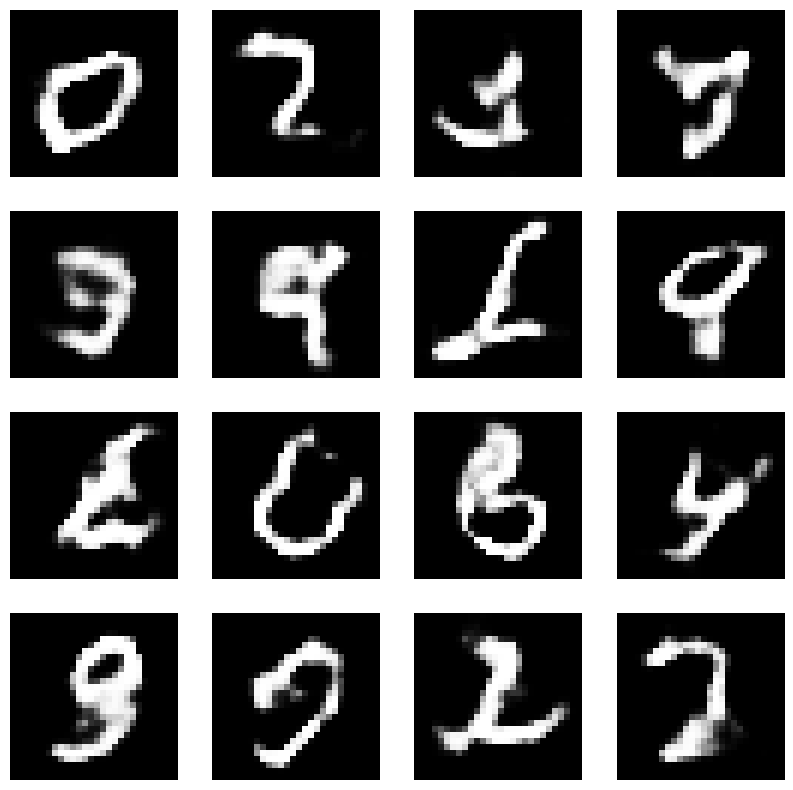

Epoch:  91


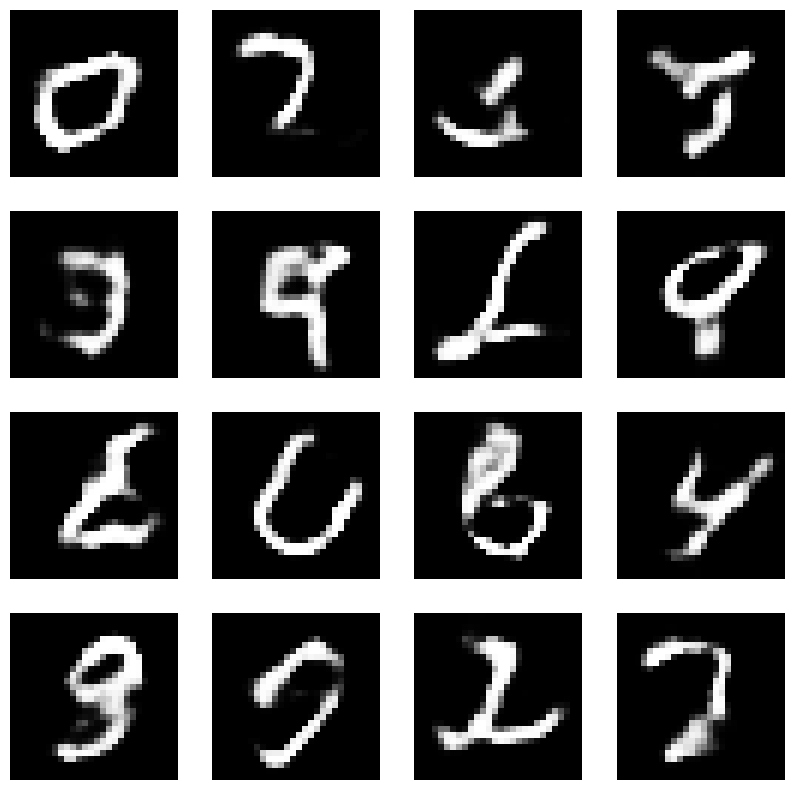

Epoch:  92


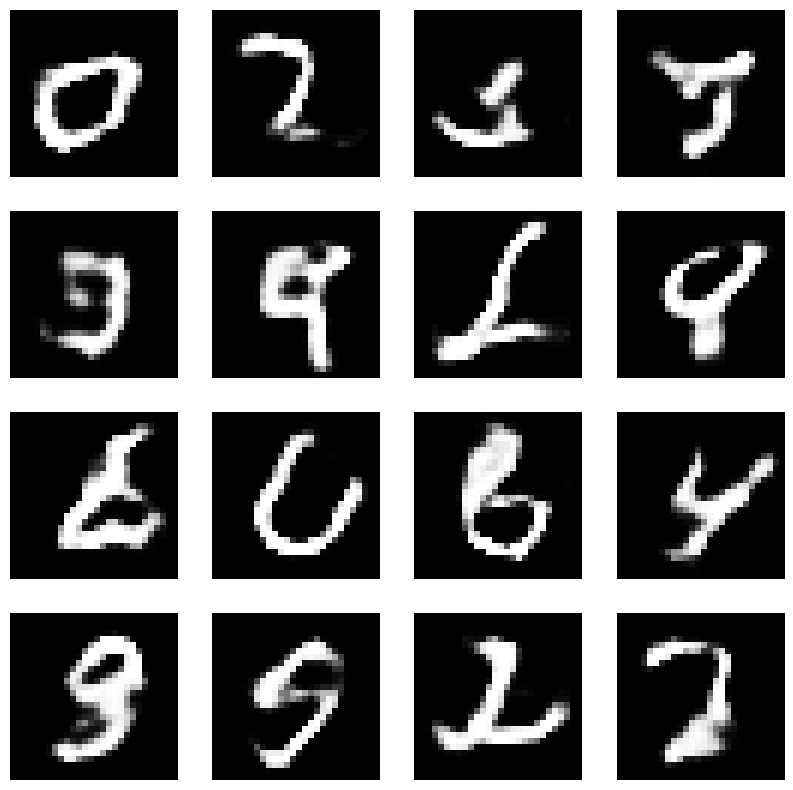

Epoch:  93


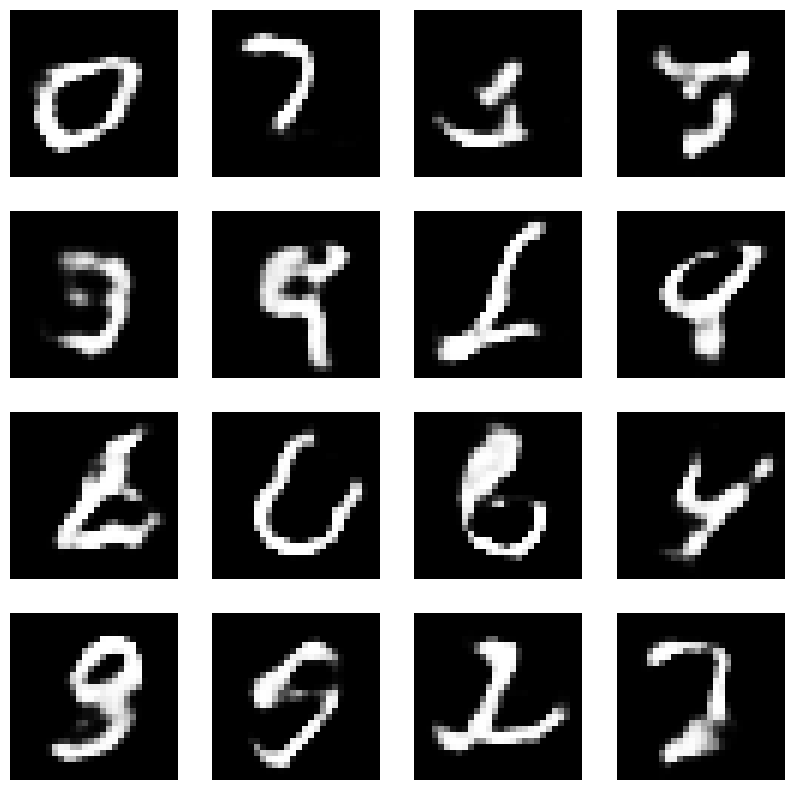

Epoch:  94


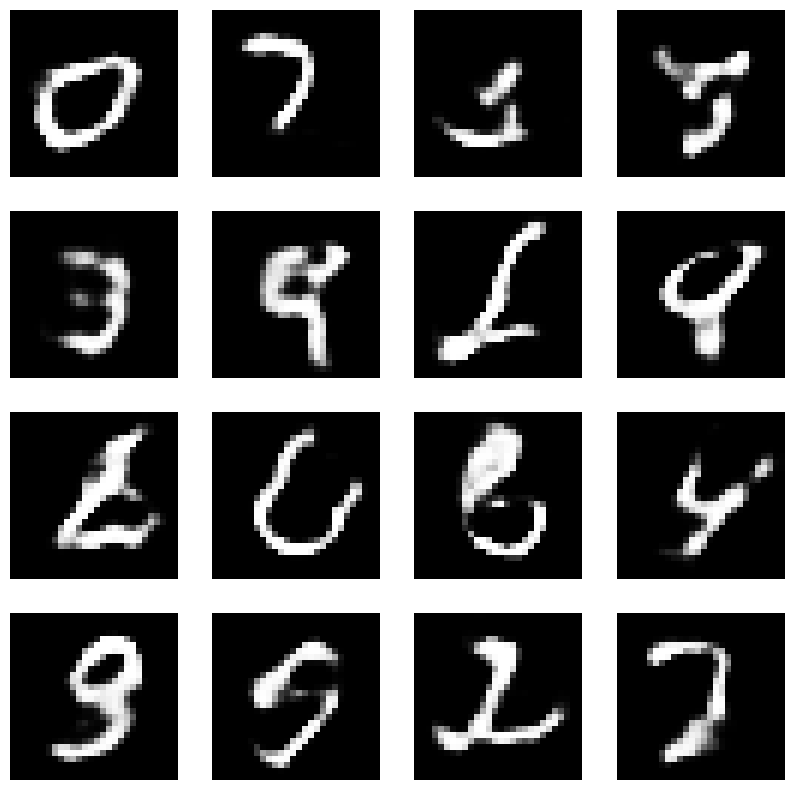

Epoch:  95


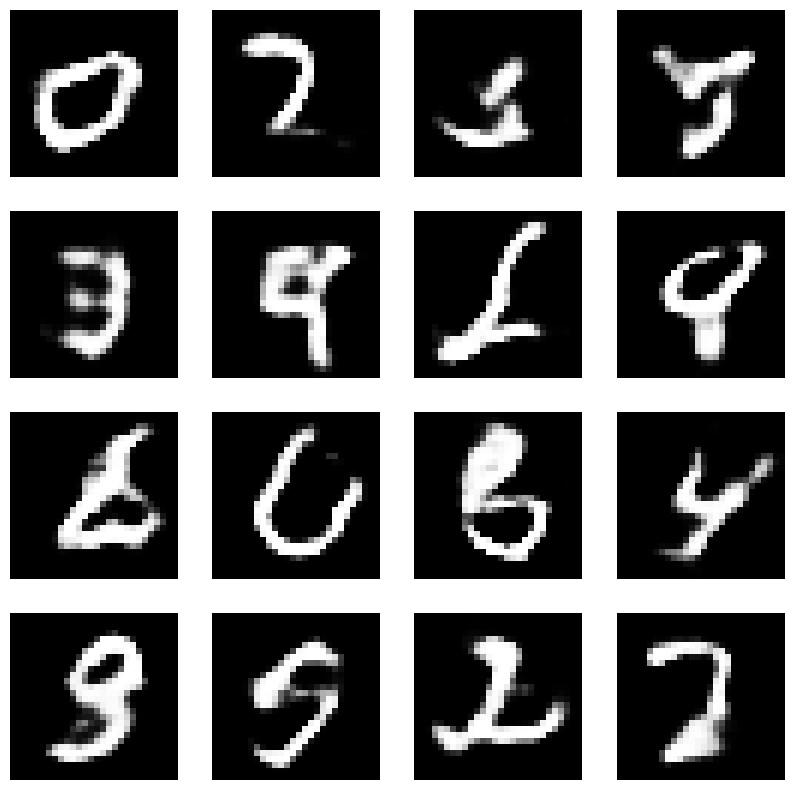

Epoch:  96


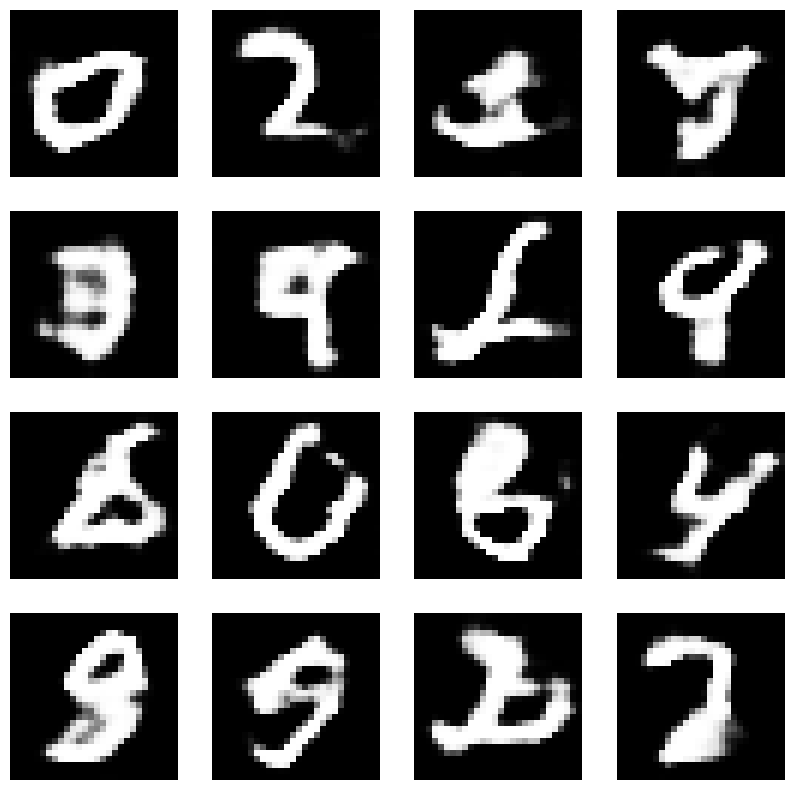

Epoch:  97


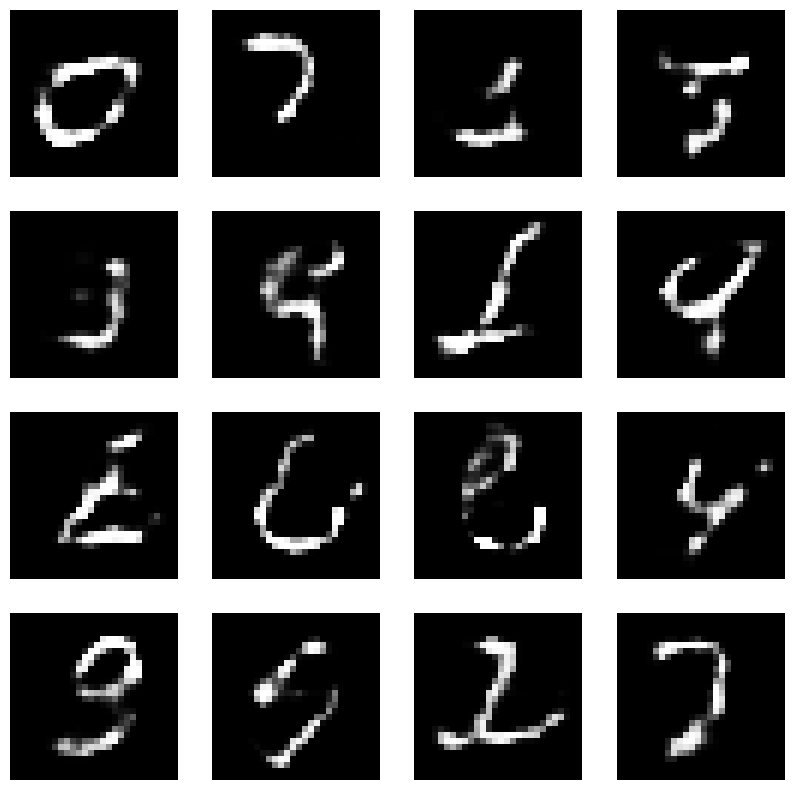

Epoch:  98


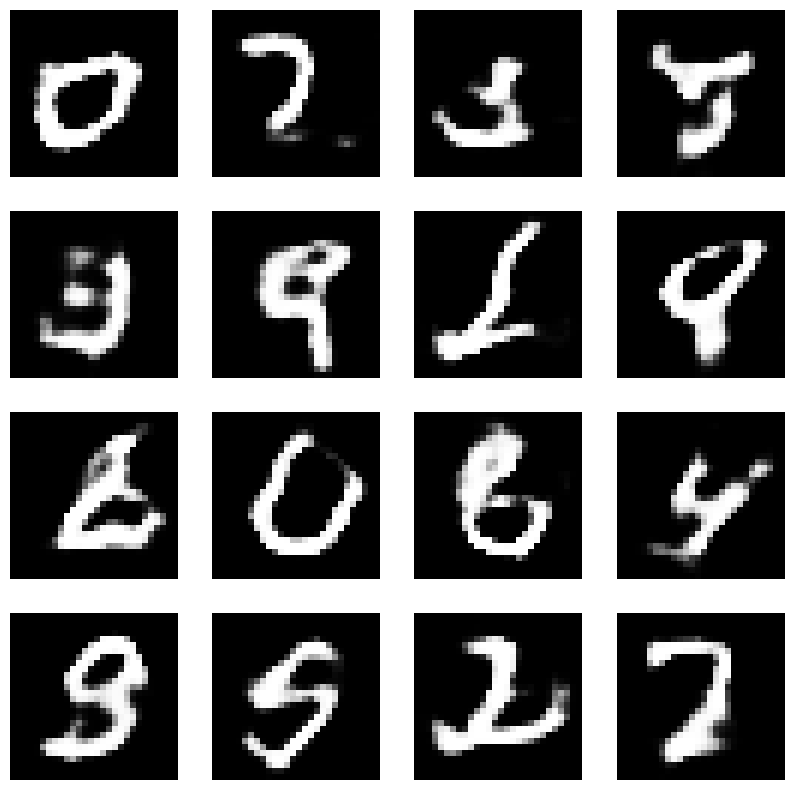

Epoch:  99


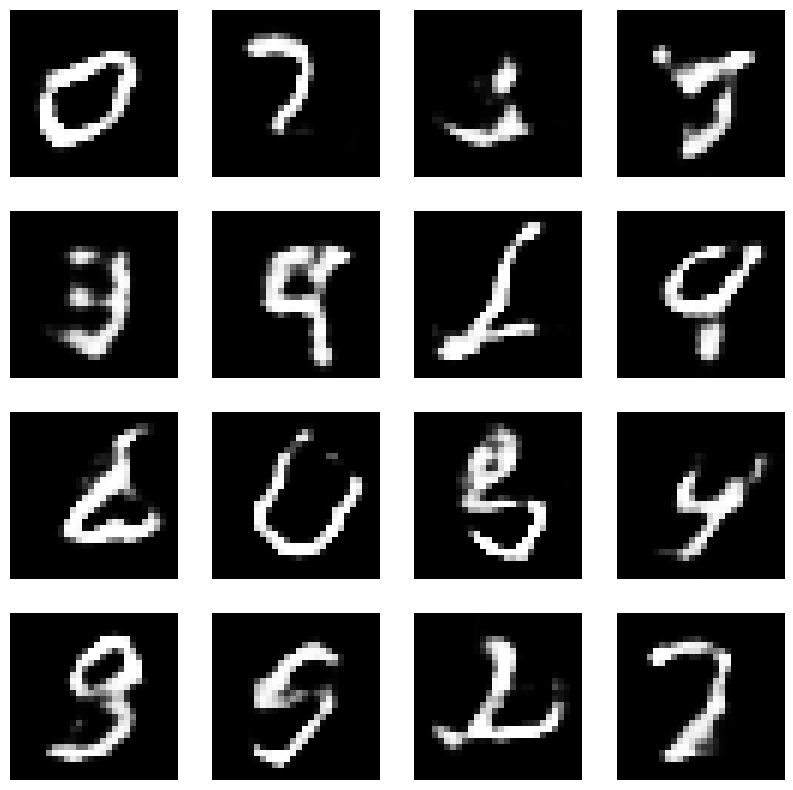

Epoch:  100


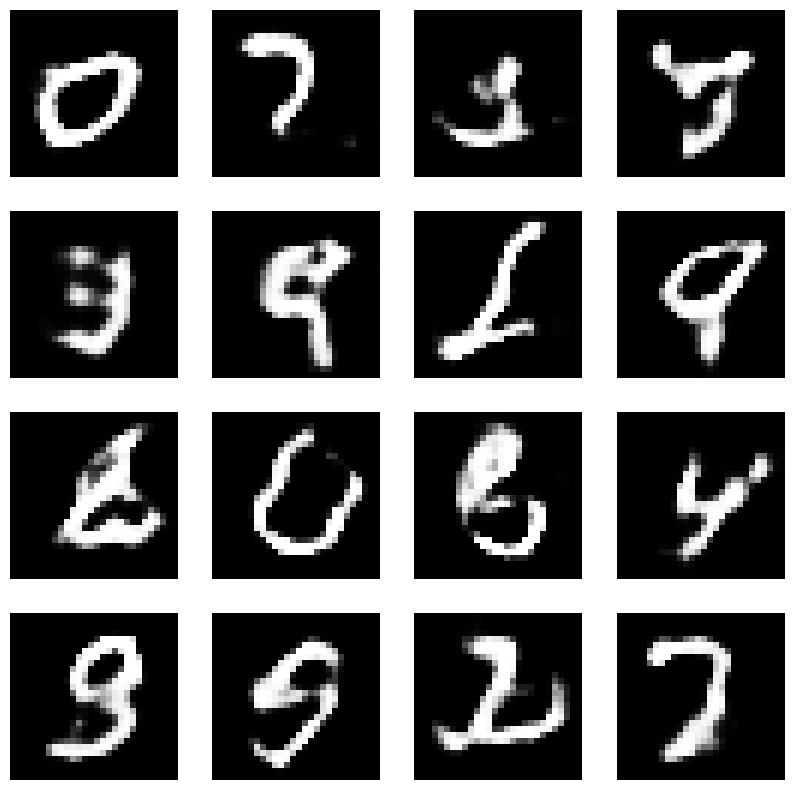

In [ ]:
train_gan(X_train, epochs, test_images)

## Trying the same with Fashion MNIST Dataset

### Loading and preprocessing the data

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

7


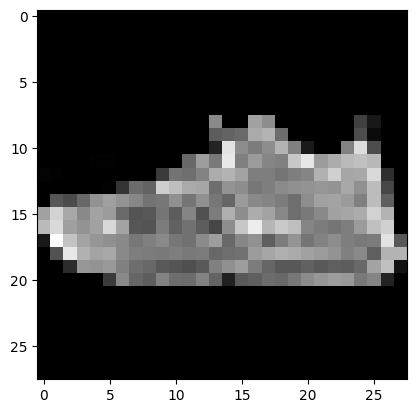

In [ ]:
i = np.random.randint(0, 60000)
#print(i)
print(y_train[i])
plt.imshow(X_train[i], cmap = 'gray');

converting the X_train into shape with color channel

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

performaing normalization

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
buffer_size / batch_size

234.375

In [ ]:
type(X_train)

numpy.ndarray

converting the numpy array to tf format and dividing it into batches

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Generator model

In [ ]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size=(5,5), padding='same',use_bias=False, strides=(2,2), activation = 'tanh'))

  network.summary()

  return network

In [ ]:
generator = build_generator()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)        

In [ ]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_2_input')>

creating noise and passing it through the generator

In [ ]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.3247018 , -0.03196561,  2.1748157 , -1.0056908 , -0.4897967 ,
        -0.94627196, -1.8364732 , -1.9388758 ,  0.03856186,  0.15342918,
         0.51206625, -0.96946245,  0.5093526 , -0.78788596, -2.4899278 ,
         0.82076377, -0.17416075, -0.5937298 ,  0.9497803 ,  0.04574915,
        -0.03359821, -0.23543207,  1.0893388 ,  1.266342  ,  0.3366098 ,
        -0.49898517, -0.7221879 , -0.8470426 ,  0.7373243 ,  0.5754278 ,
        -1.5607042 ,  0.68892735, -0.26766327,  0.8747365 , -0.88003445,
        -1.3035895 , -0.99590576, -0.20715563,  1.6991999 ,  0.28990945,
        -0.05969511, -0.7091317 ,  2.3351538 ,  1.028206  , -0.8097908 ,
         0.09828296, -1.372689  , -1.103104  , -0.74400425, -0.2816785 ,
        -0.9119912 ,  1.9651225 ,  0.50803417,  1.254177  , -1.3218075 ,
        -0.6591615 , -0.2953424 ,  0.2627128 ,  0.20120469,  1.0160018 ,
         0.7926972 , -0.5248819 ,  1.3423324 , -0.85668164,  0.5039698 ,
 

In [ ]:
generated_image = generator(noise, training = False)

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 1])

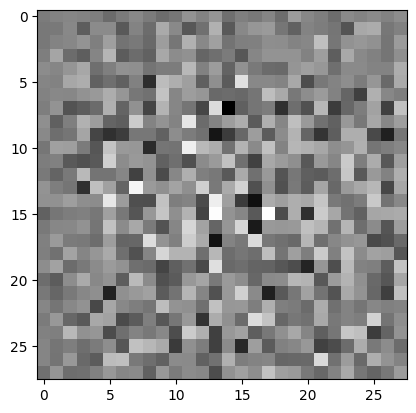

In [ ]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray');

Building the Discriminator

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides=(2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides=(2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
discriminator = build_discriminator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [ ]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_2_input')>

passing the generated image through the discriminator

In [ ]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00043011]], dtype=float32)>

In [ ]:
tf.sigmoid(0.00356018)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5008901>

## Calculating the loss

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

discriminator loss (both actual and generated image)

In [ ]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

generator loss (loss of the generated image)

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

Adam optimizer as the optimizer for both generator and discriminator

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## Training the GAN

In [ ]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16

In [ ]:
batch_size, noise_dim

(256, 100)

function to train the gan using the loss fnction and optimization functions

creating the link between the generator and discriminator

In [ ]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

creating random noise images to be tested in the GAN

In [ ]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])
test_images.shape

TensorShape([16, 100])

function to train the images and test using the test noise images created

In [ ]:
def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      #print(image_batch.shape)
      train_steps(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training=False)
    fig = plt.figure(figsize = (6,6))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
      plt.axis('off')
    plt.show()

Epoch:  1


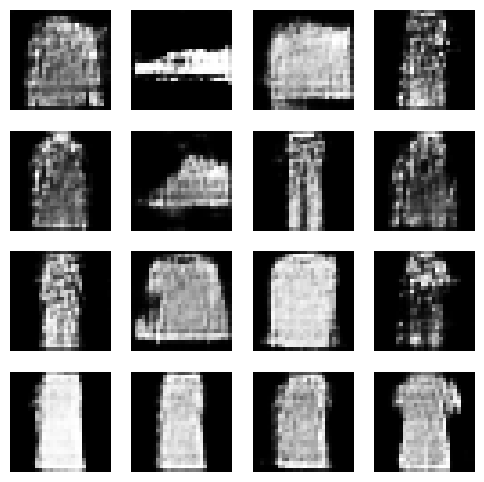

Epoch:  2


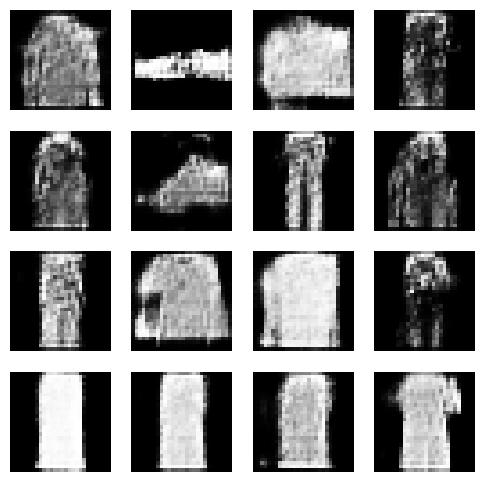

Epoch:  3


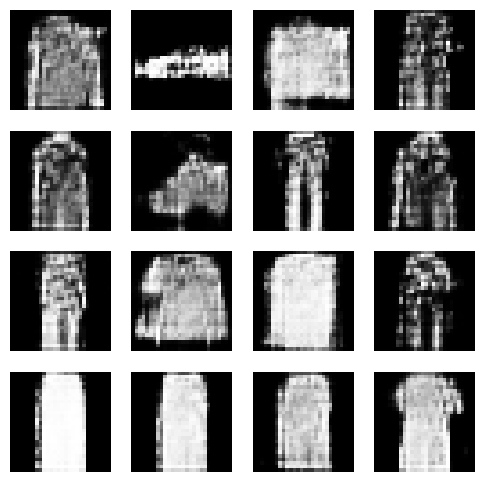

Epoch:  4


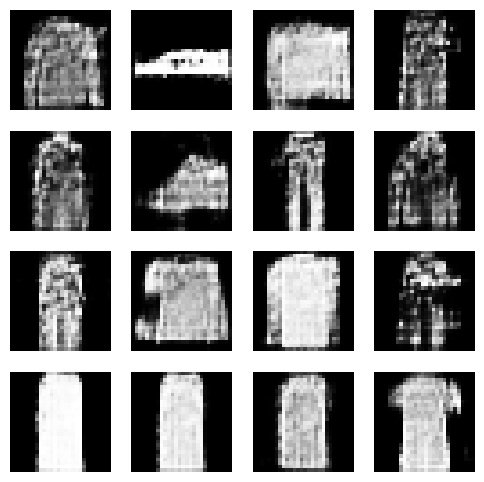

Epoch:  5


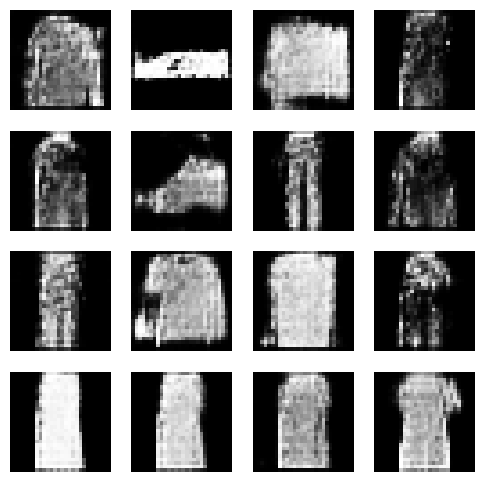

Epoch:  6


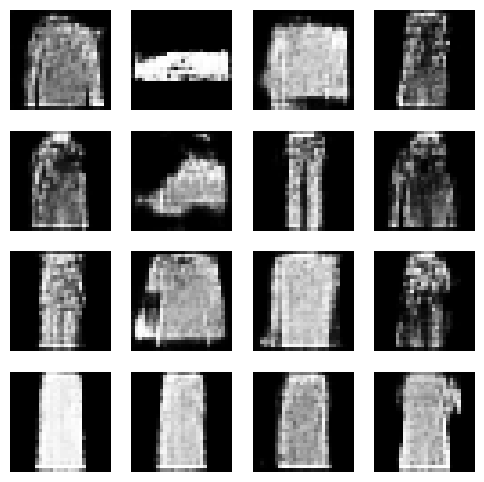

Epoch:  7


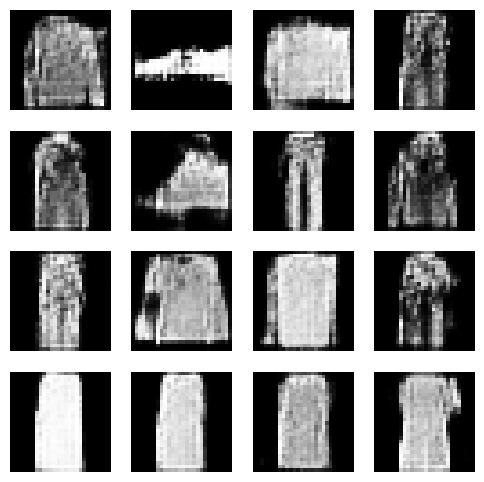

Epoch:  8


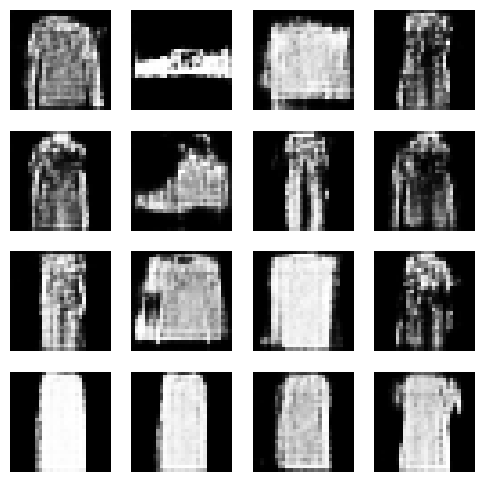

Epoch:  9


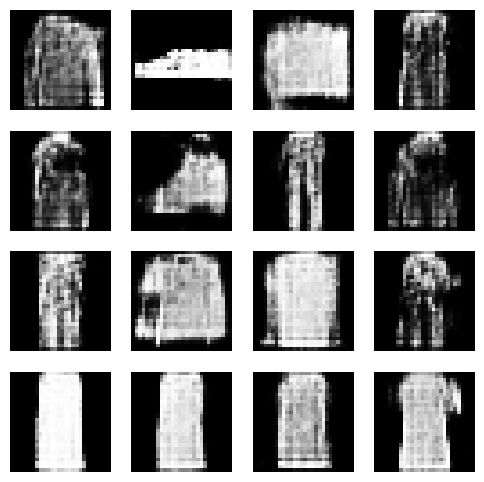

Epoch:  10


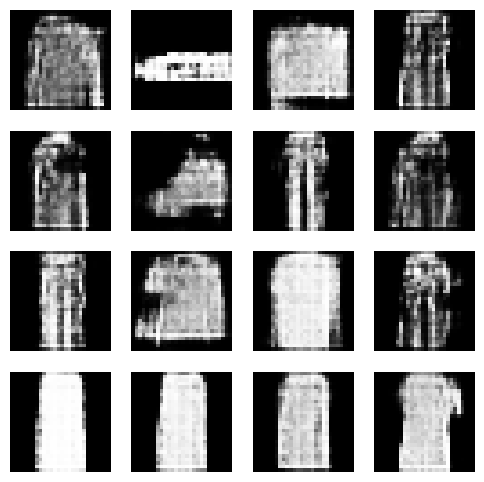

Epoch:  11


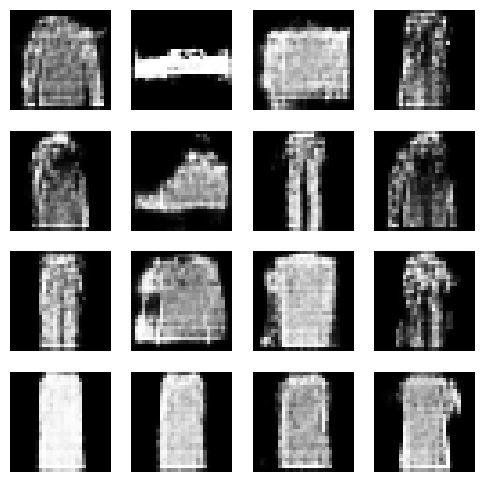

Epoch:  12


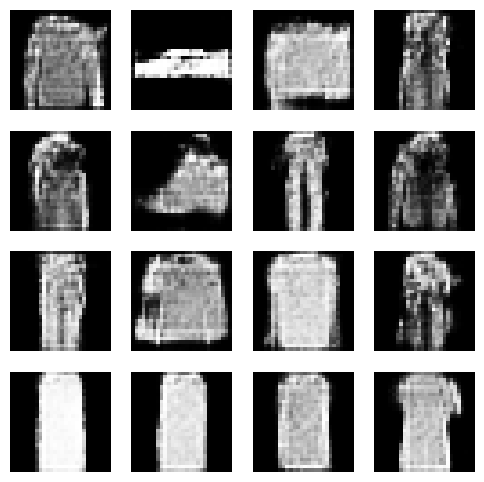

Epoch:  13


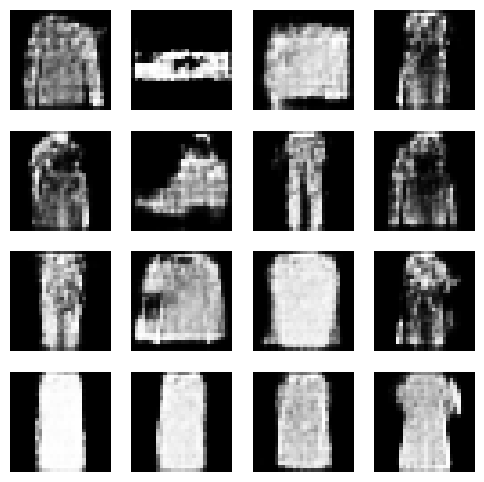

Epoch:  14


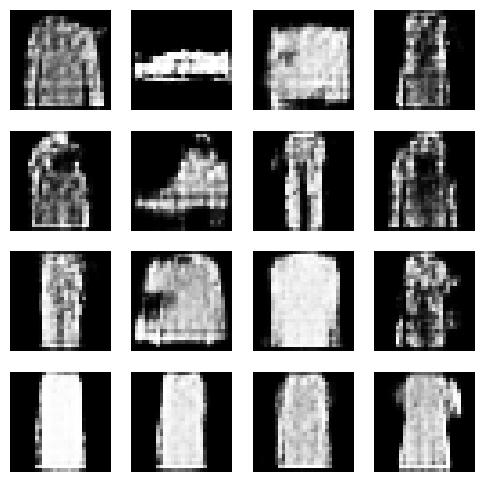

Epoch:  15


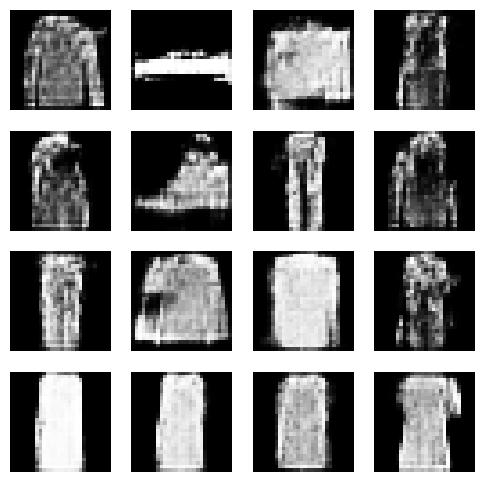

Epoch:  16


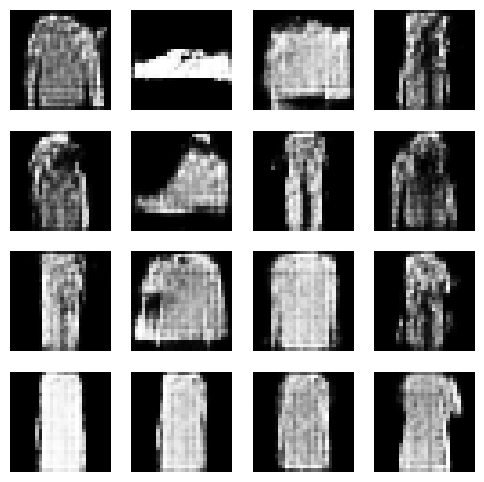

Epoch:  17


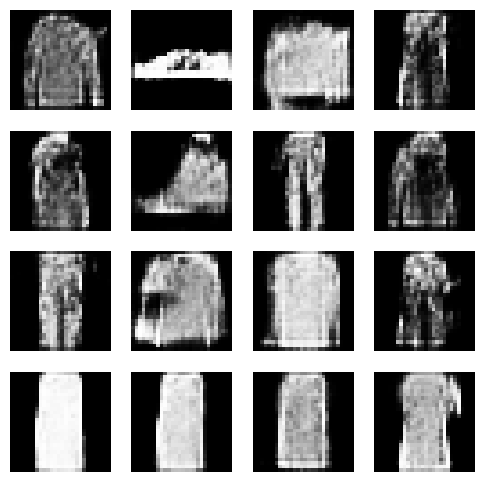

Epoch:  18


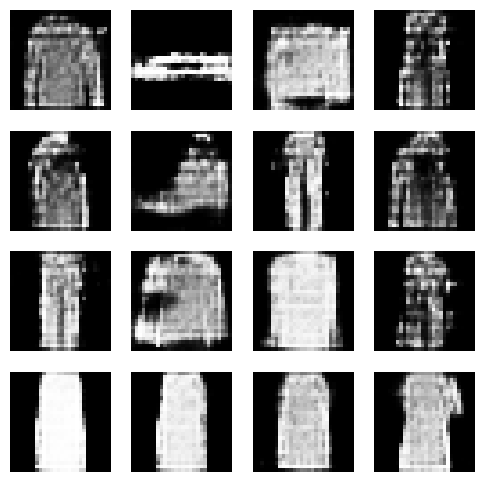

Epoch:  19


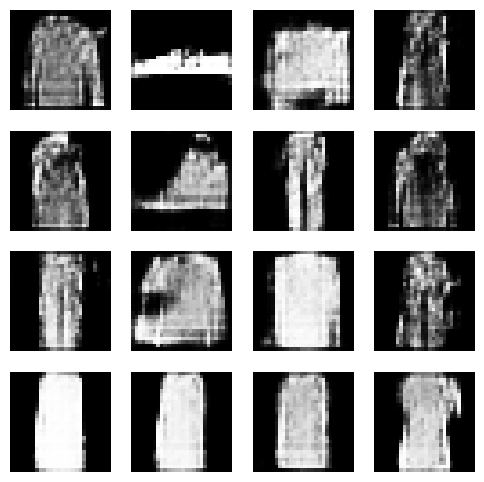

Epoch:  20


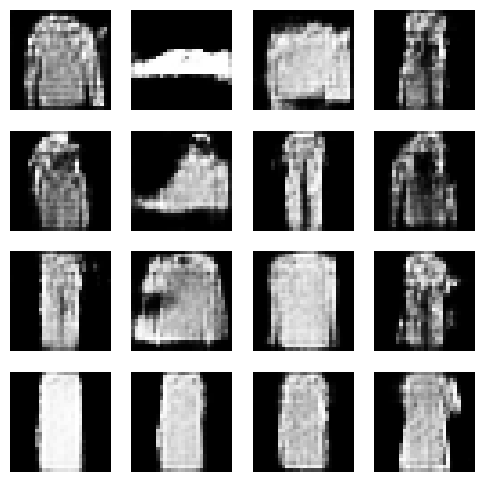

Epoch:  21


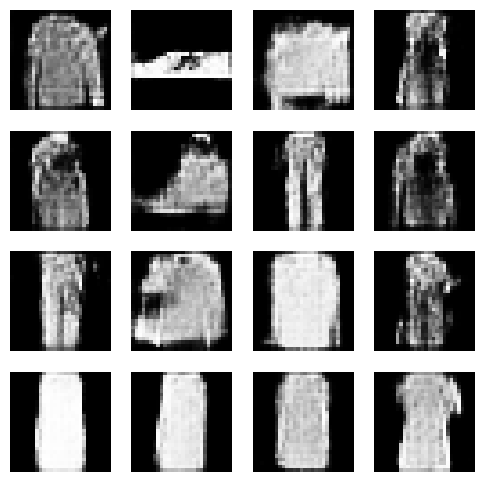

Epoch:  22


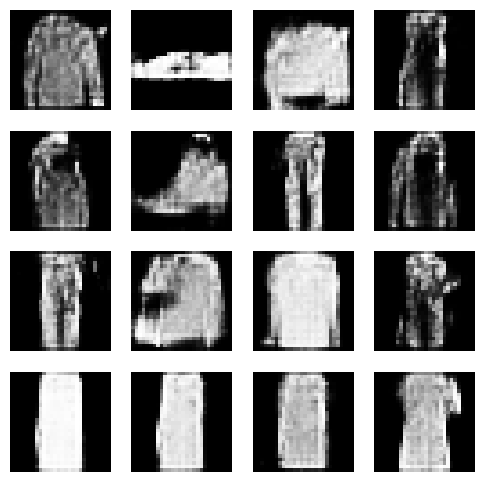

Epoch:  23


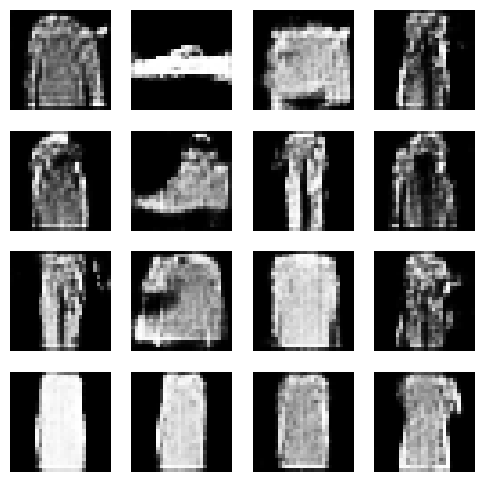

Epoch:  24


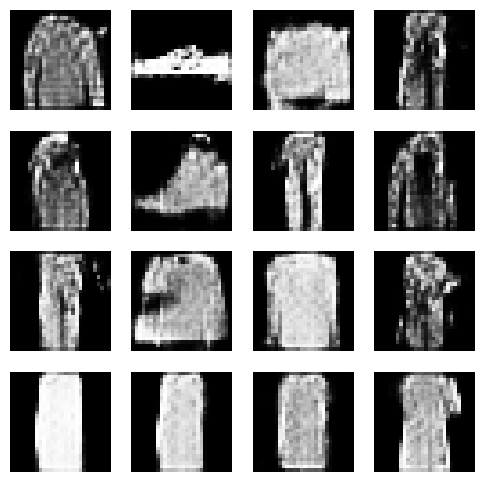

Epoch:  25


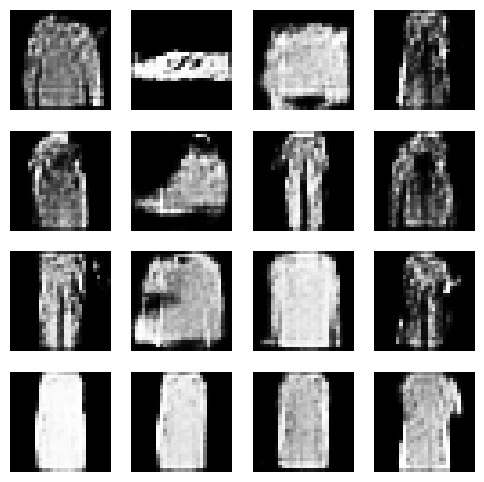

Epoch:  26


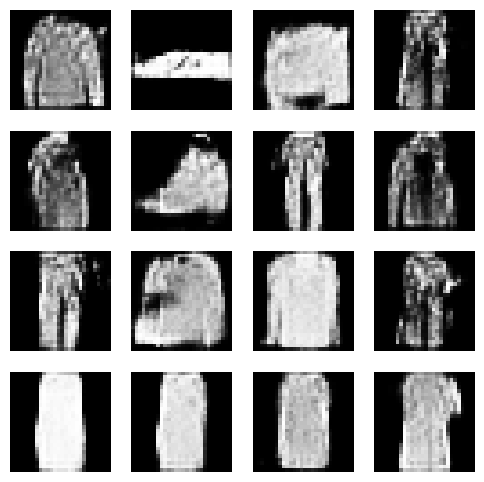

Epoch:  27


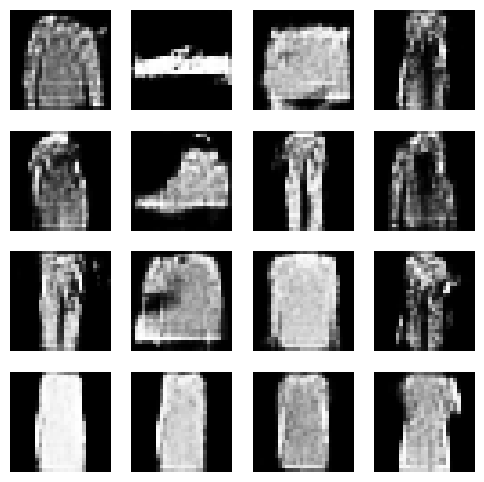

Epoch:  28


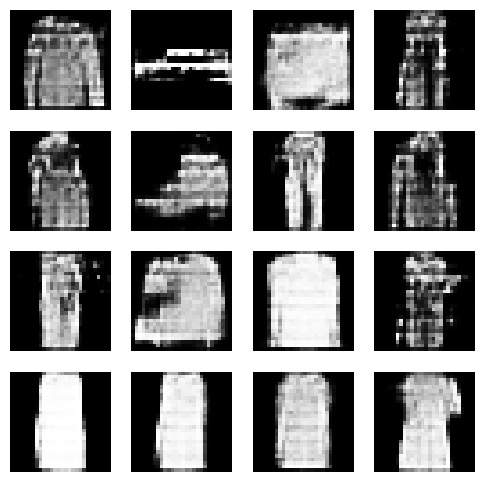

Epoch:  29


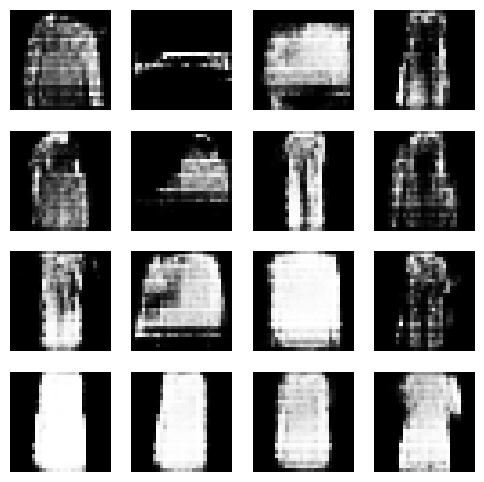

Epoch:  30


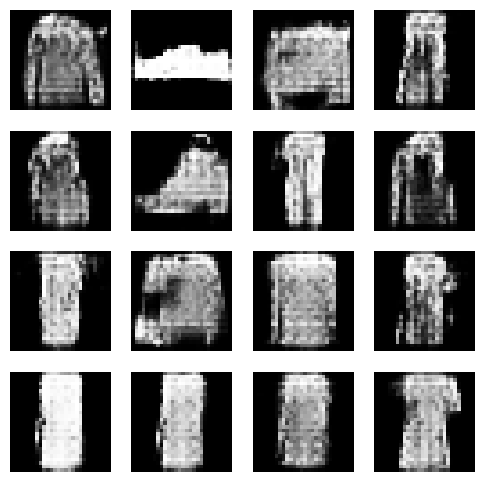

Epoch:  31


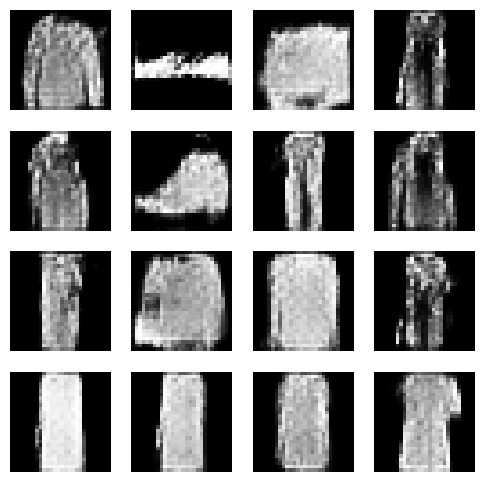

Epoch:  32


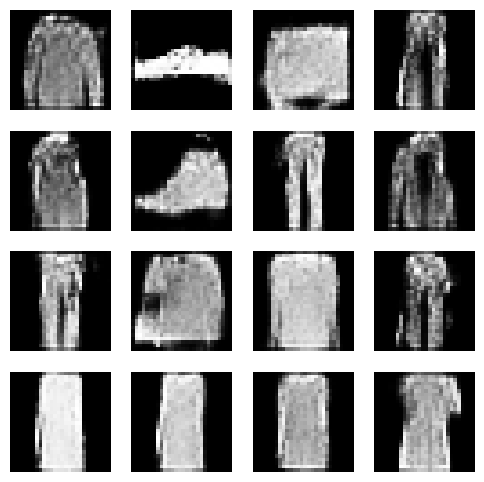

Epoch:  33


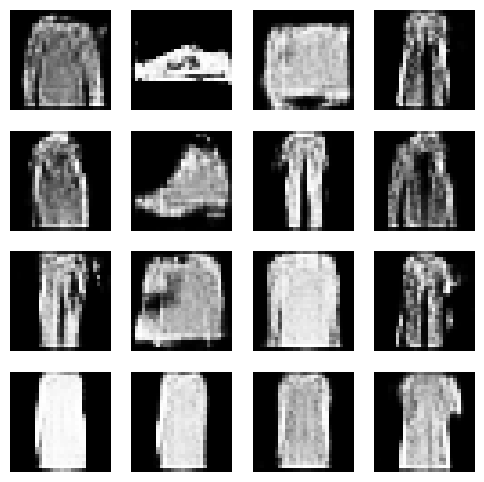

Epoch:  34


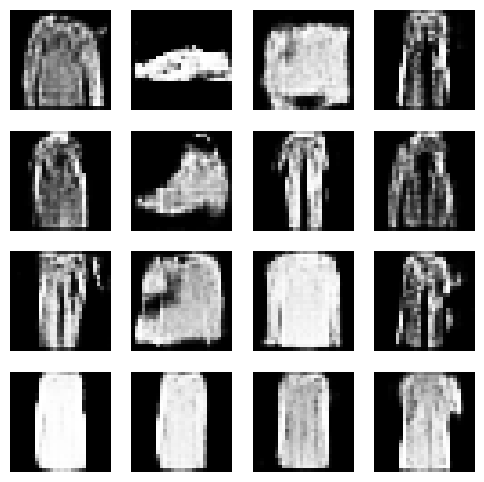

Epoch:  35


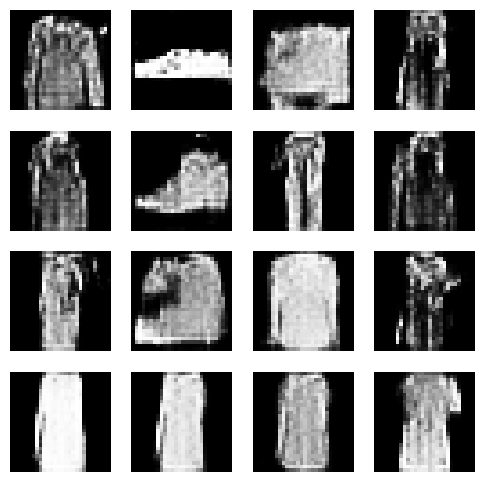

Epoch:  36


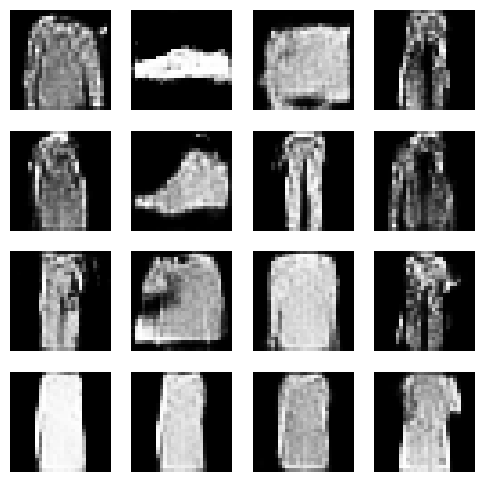

Epoch:  37


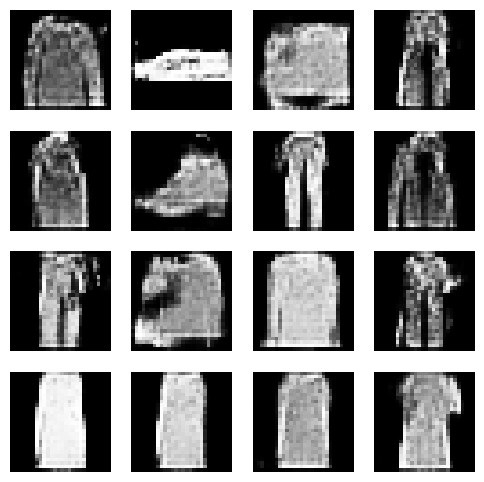

Epoch:  38


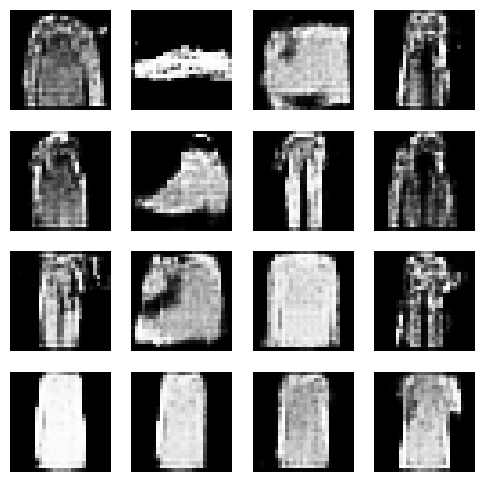

Epoch:  39


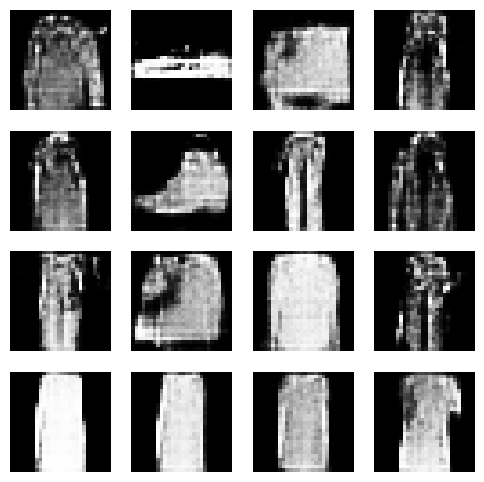

Epoch:  40


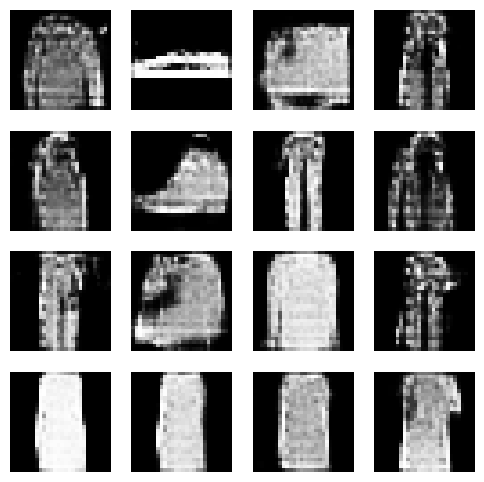

Epoch:  41


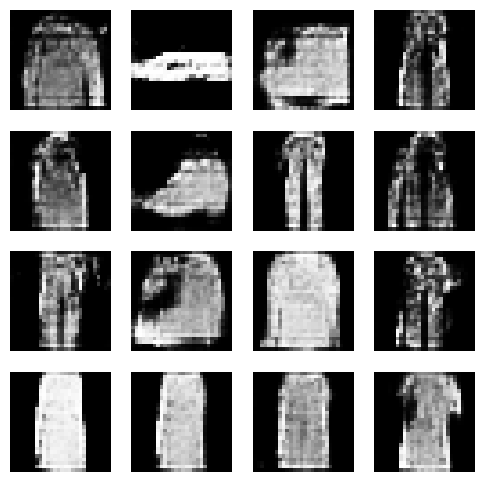

Epoch:  42


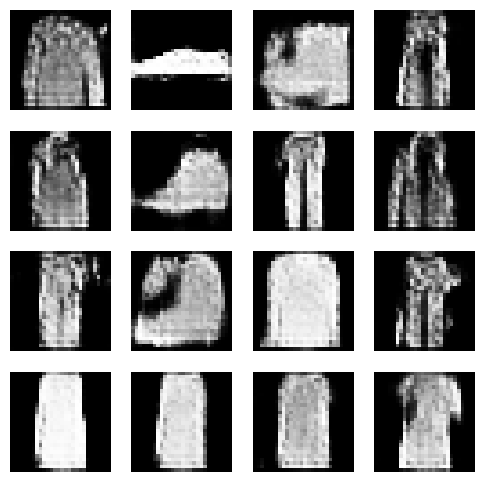

Epoch:  43


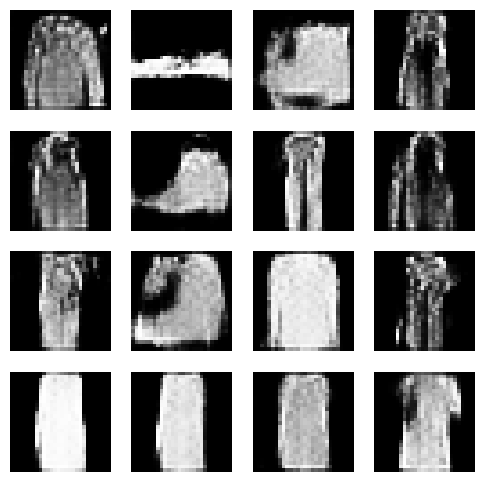

Epoch:  44


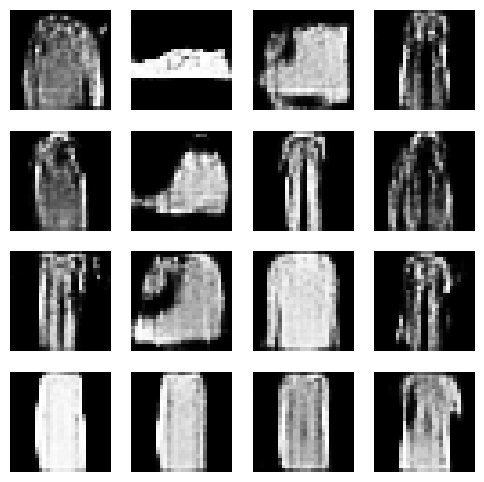

Epoch:  45


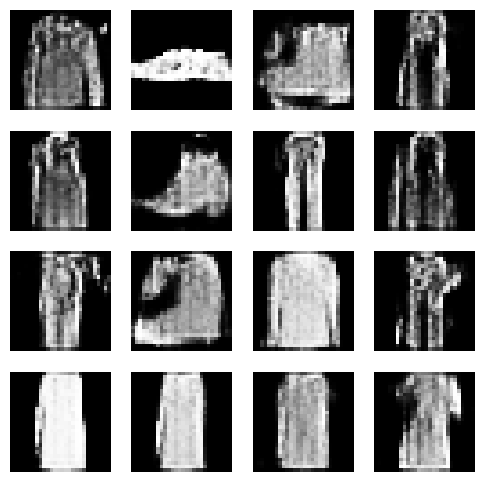

Epoch:  46


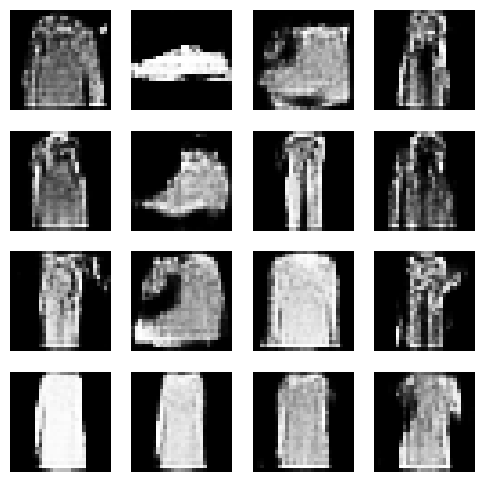

Epoch:  47


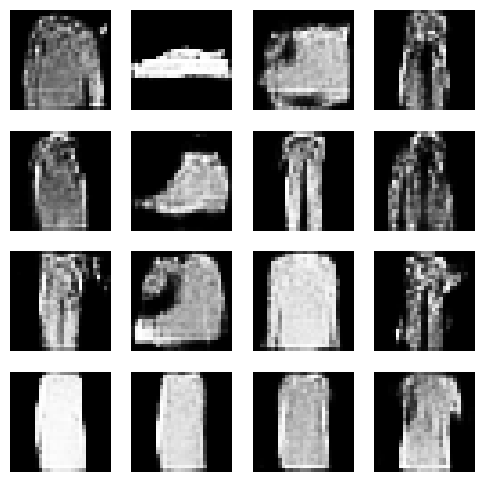

Epoch:  48


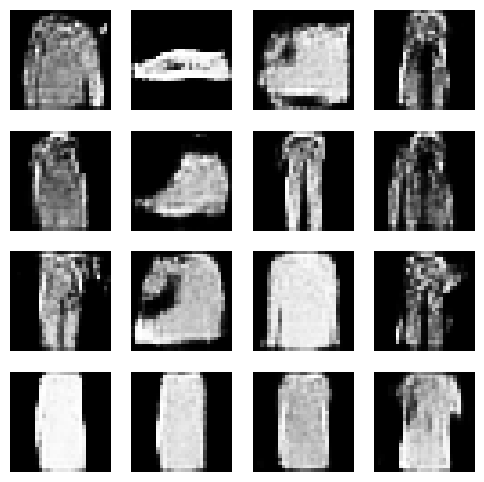

Epoch:  49


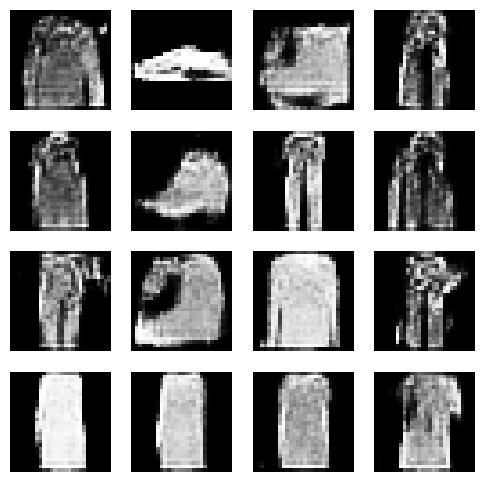

Epoch:  50


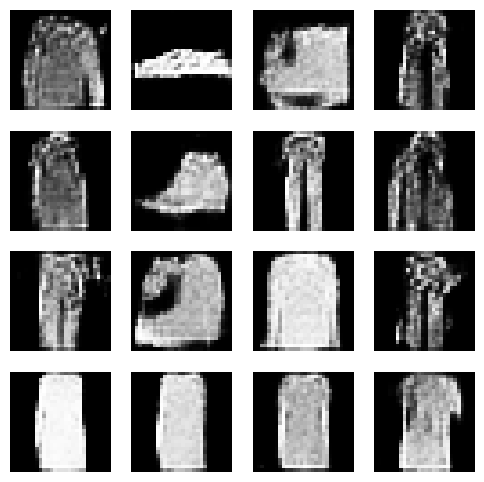

Epoch:  51


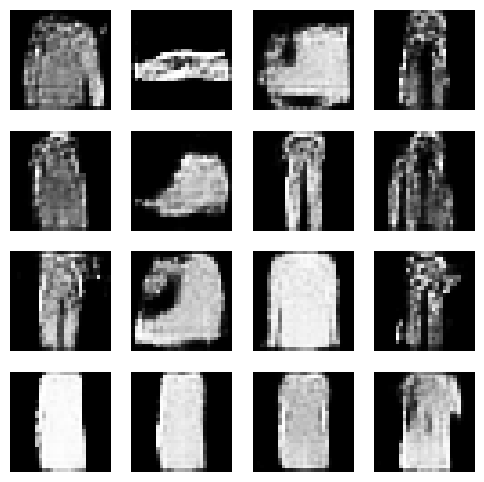

Epoch:  52


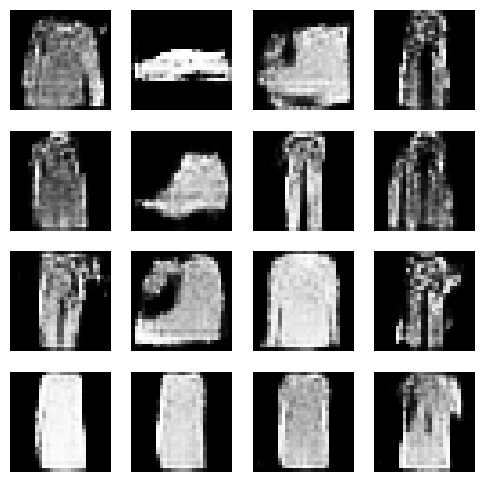

Epoch:  53


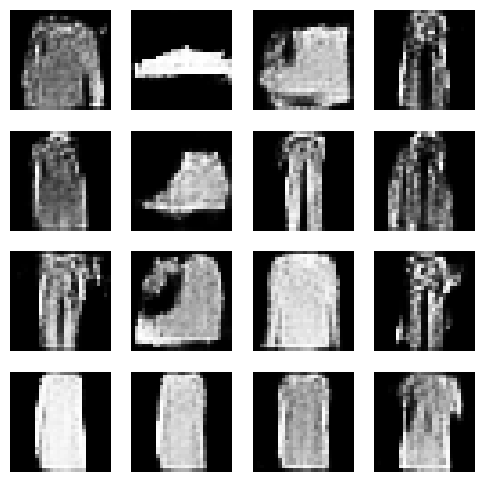

Epoch:  54


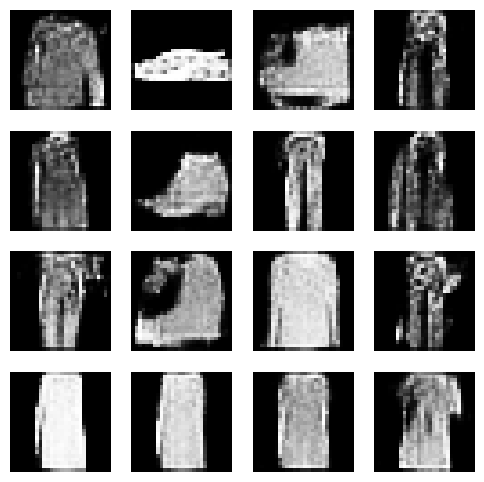

Epoch:  55


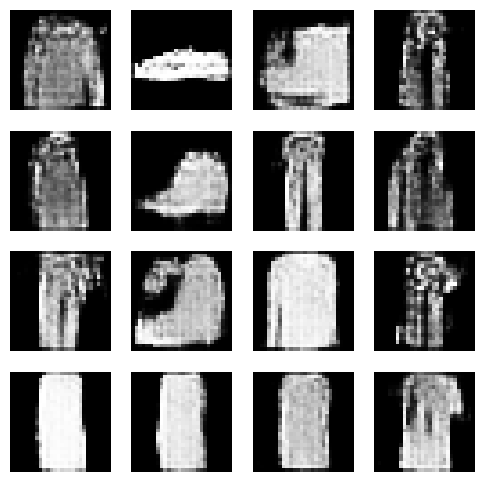

Epoch:  56


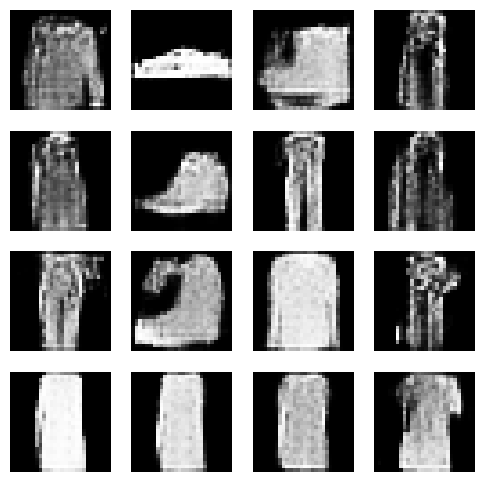

Epoch:  57


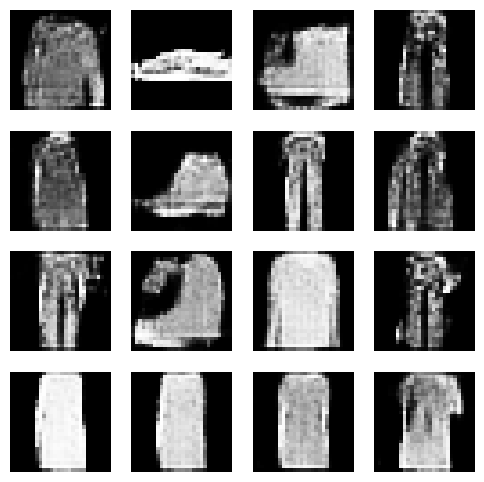

Epoch:  58


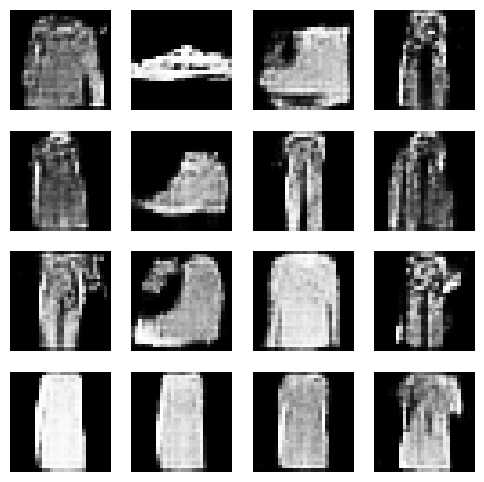

Epoch:  59


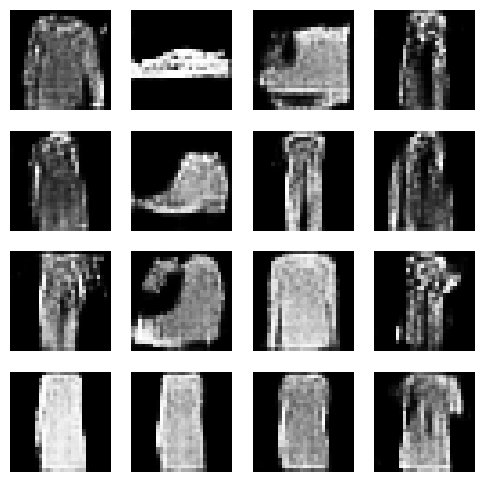

Epoch:  60


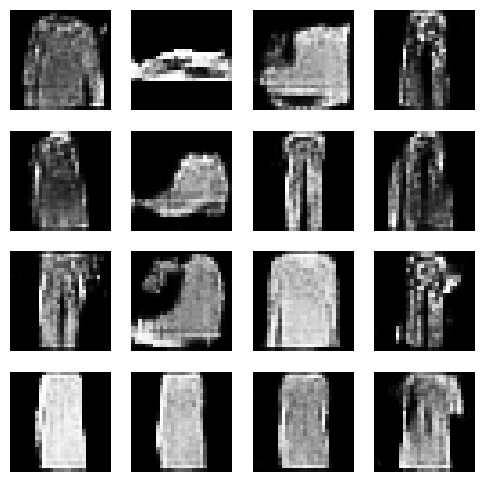

Epoch:  61


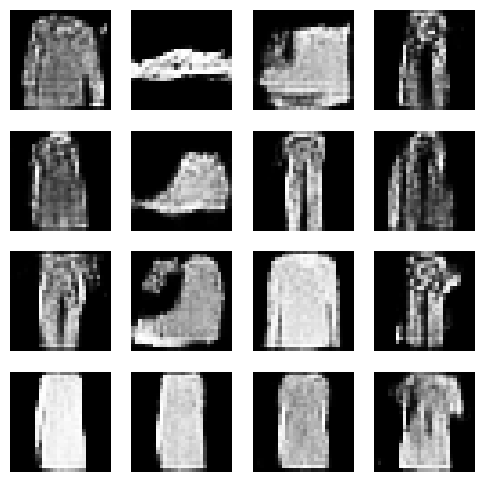

Epoch:  62


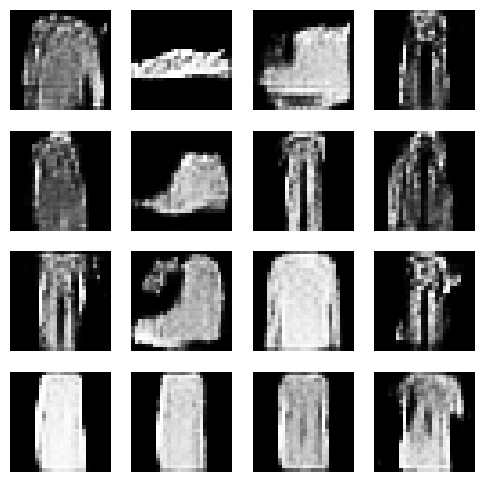

Epoch:  63


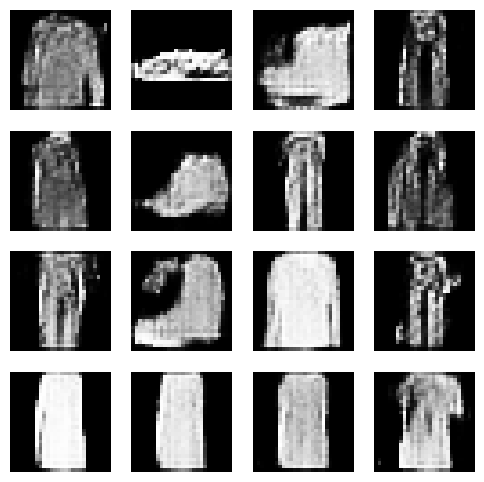

Epoch:  64


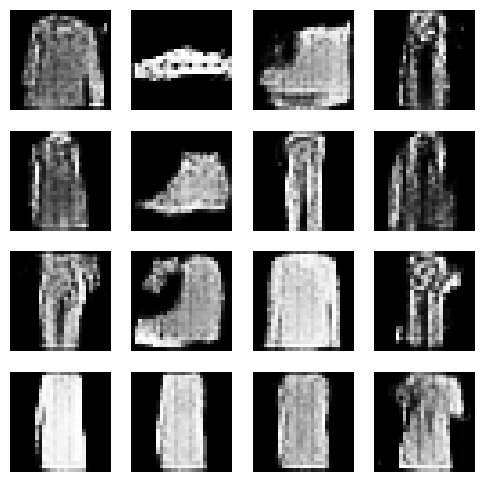

Epoch:  65


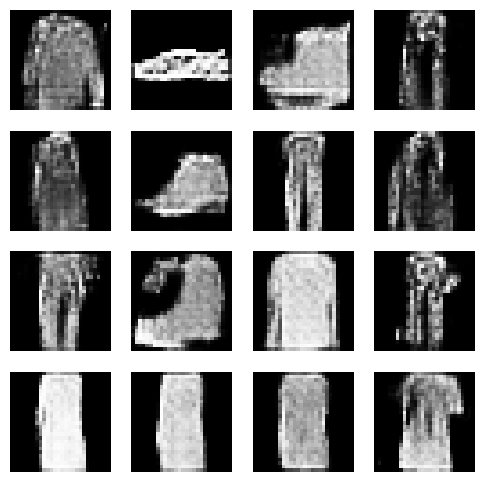

Epoch:  66


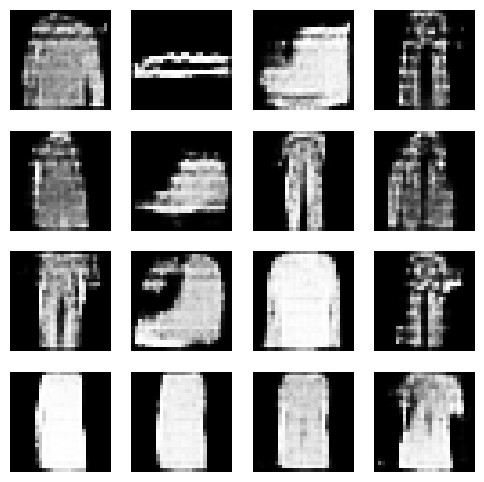

Epoch:  67


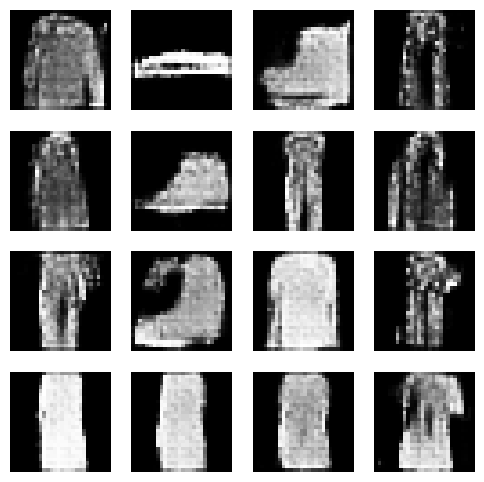

Epoch:  68


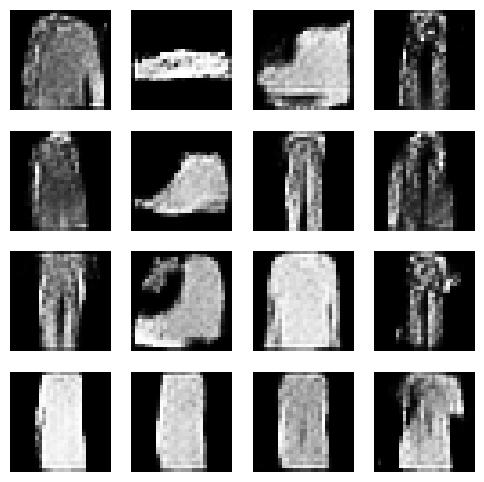

Epoch:  69


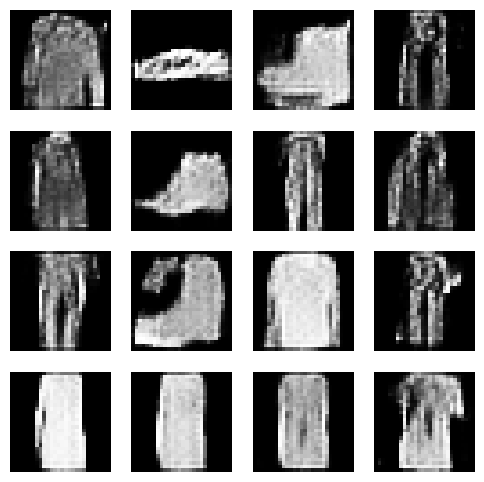

Epoch:  70


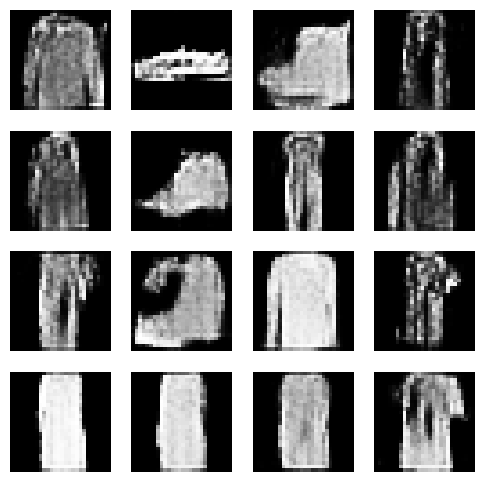

Epoch:  71


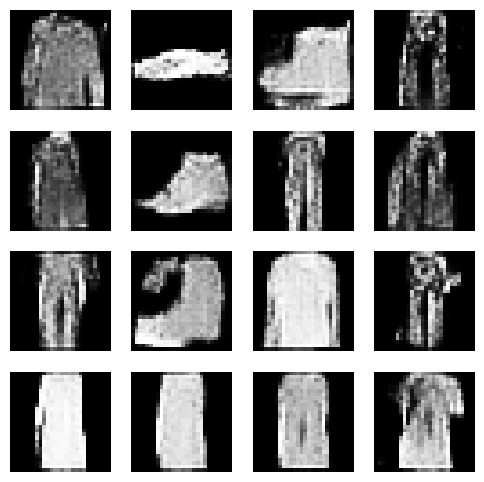

Epoch:  72


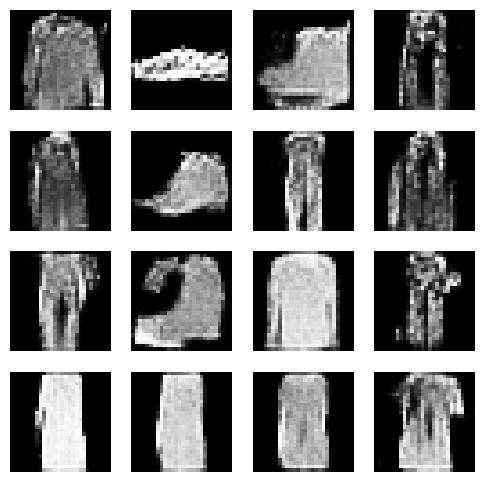

Epoch:  73


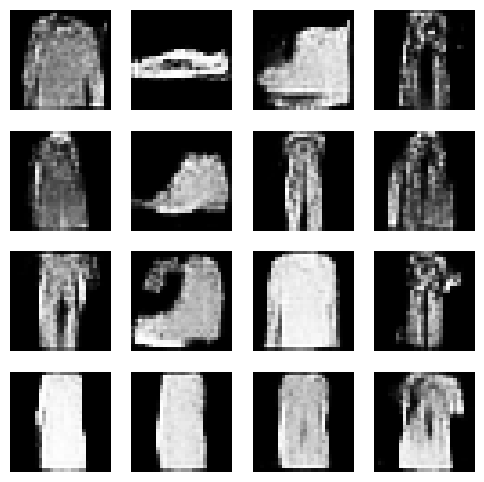

Epoch:  74


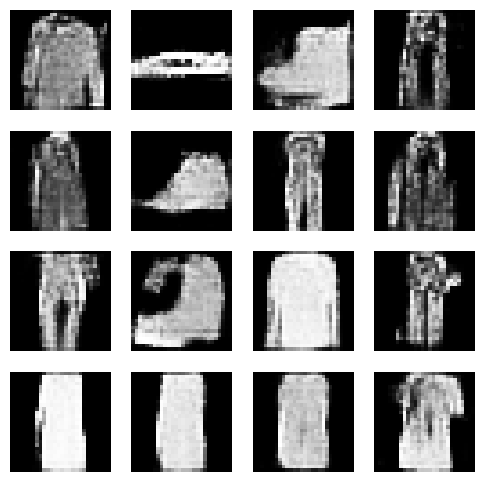

Epoch:  75


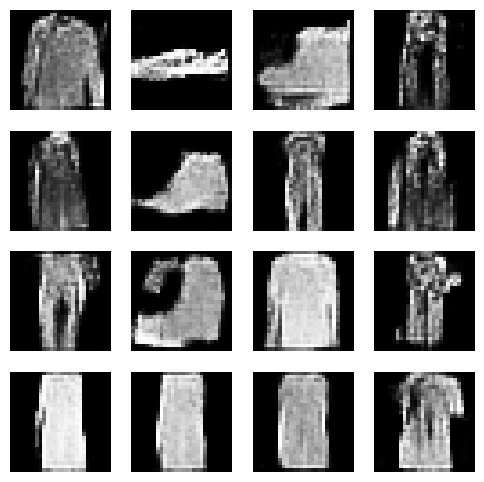

Epoch:  76


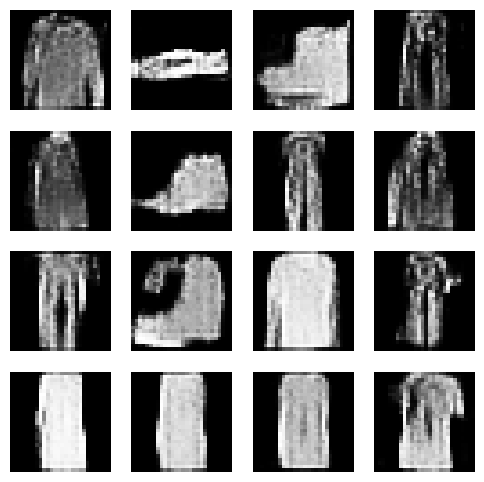

Epoch:  77


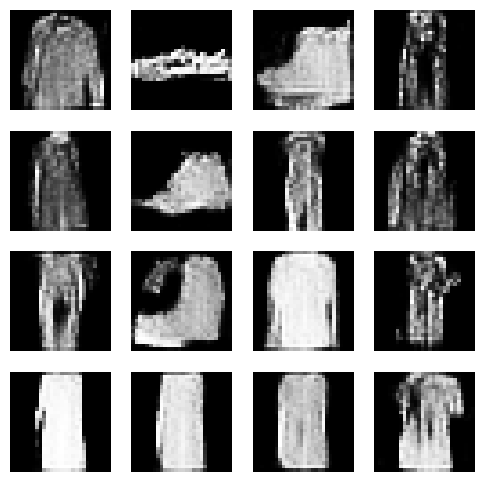

Epoch:  78


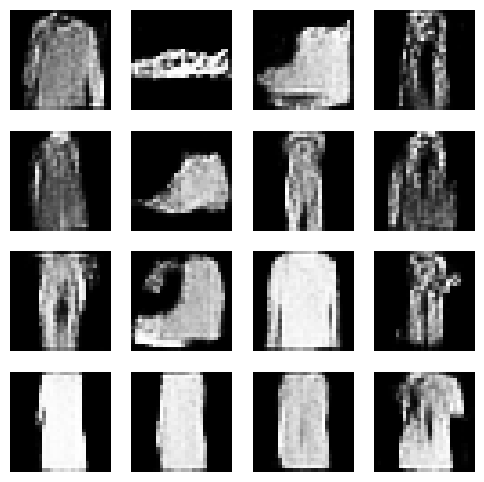

Epoch:  79


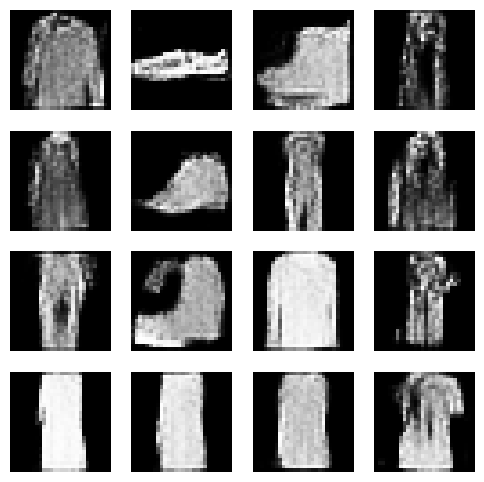

Epoch:  80


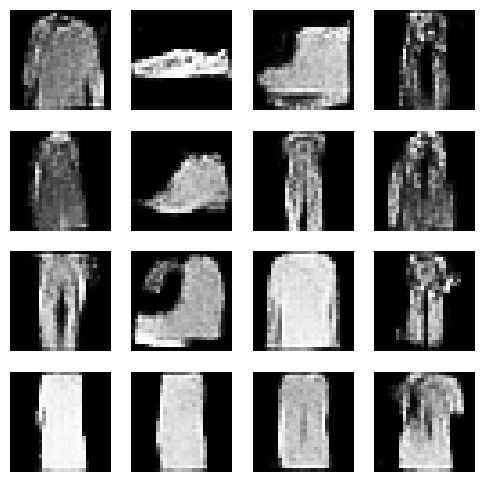

Epoch:  81


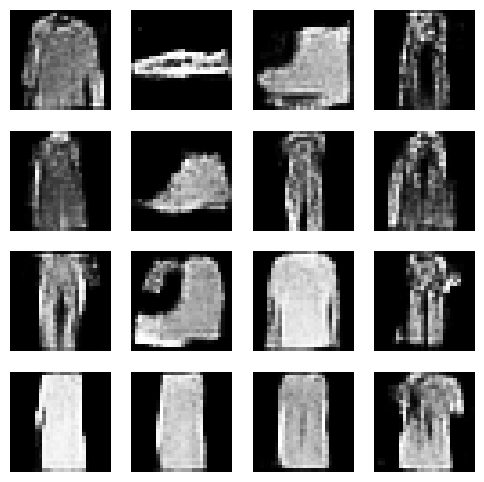

Epoch:  82


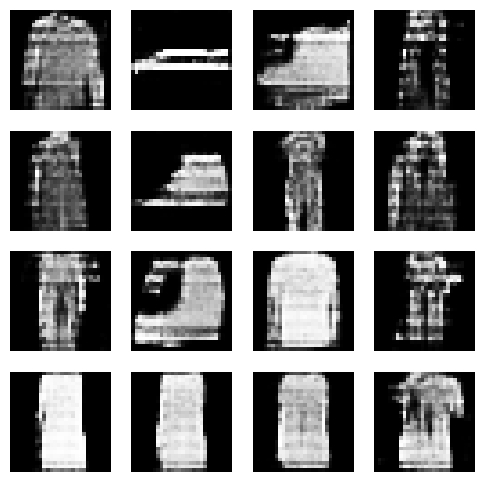

Epoch:  83


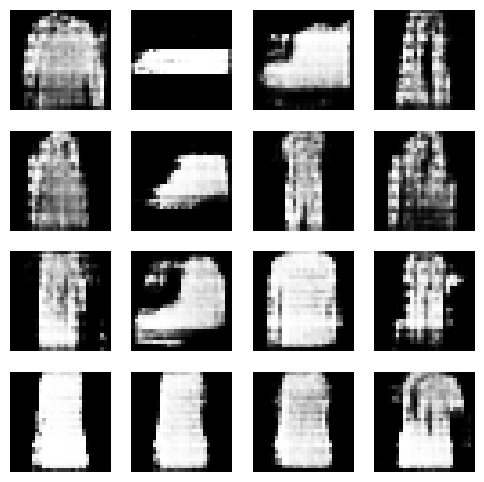

Epoch:  84


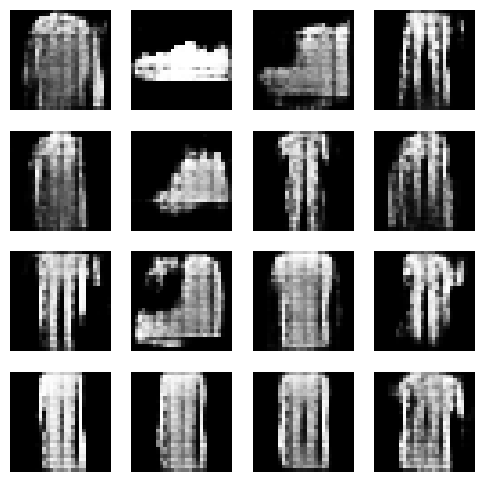

Epoch:  85


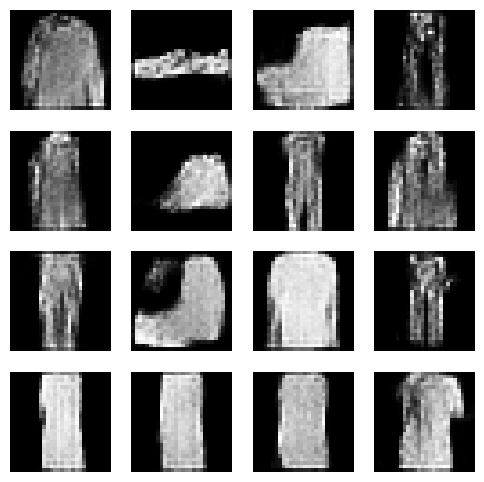

Epoch:  86


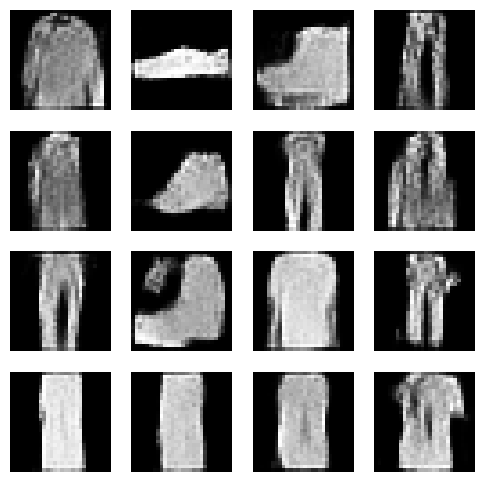

Epoch:  87


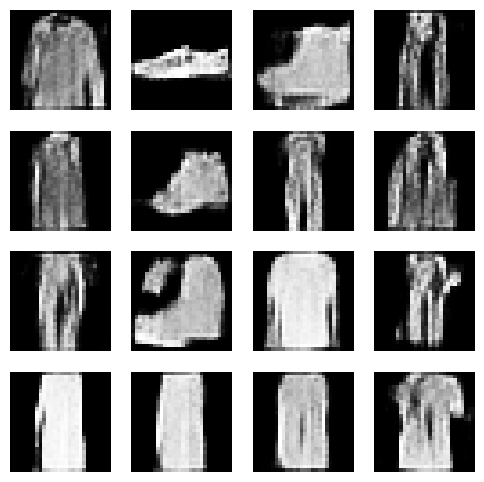

Epoch:  88


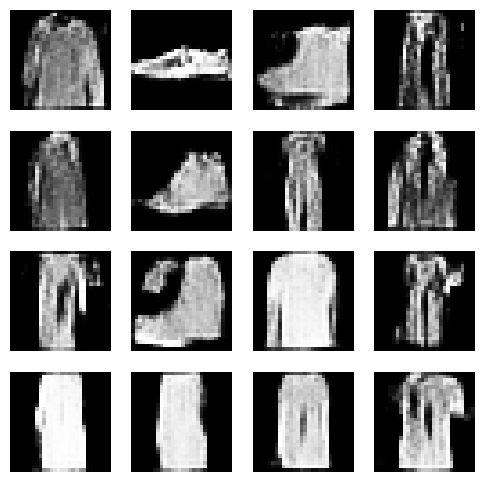

Epoch:  89


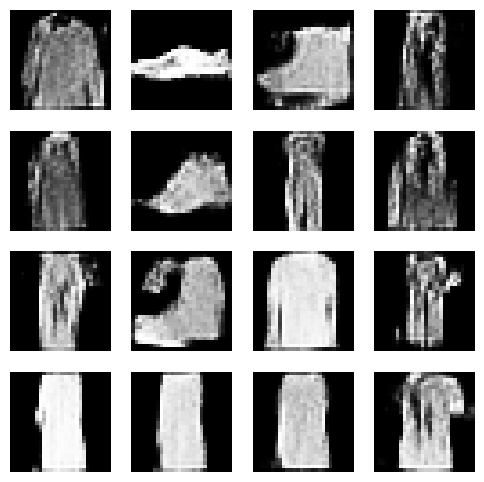

Epoch:  90


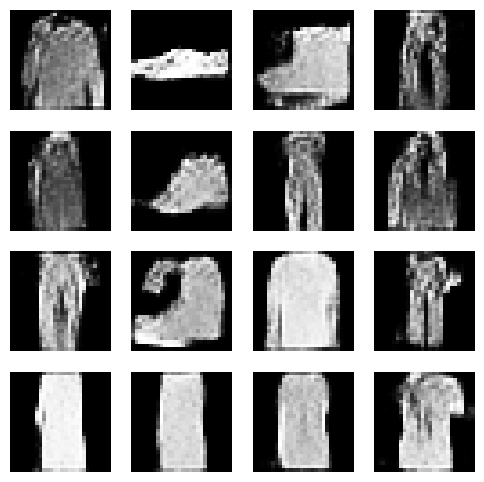

Epoch:  91


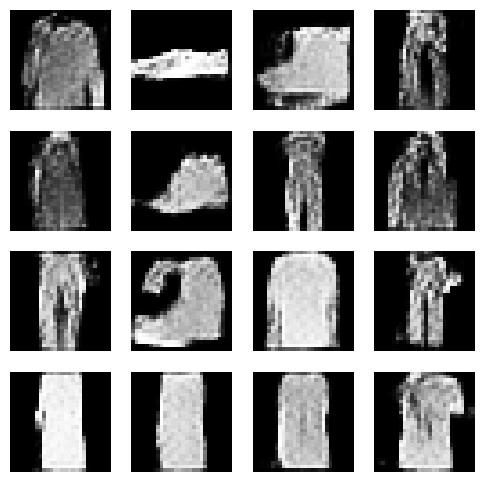

Epoch:  92


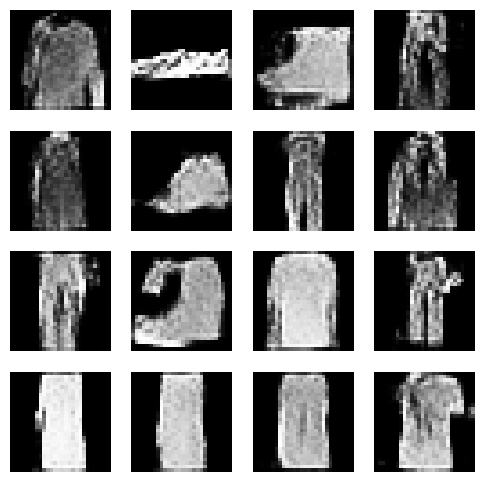

Epoch:  93


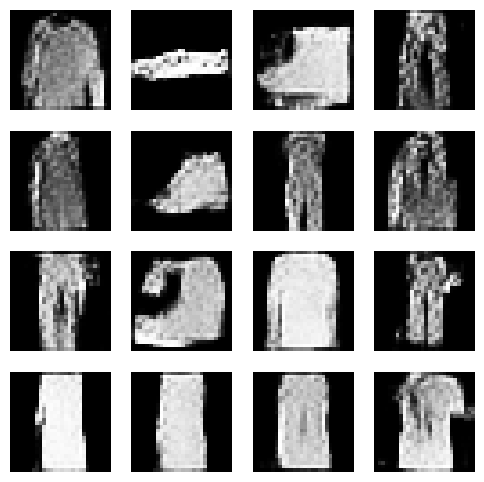

Epoch:  94


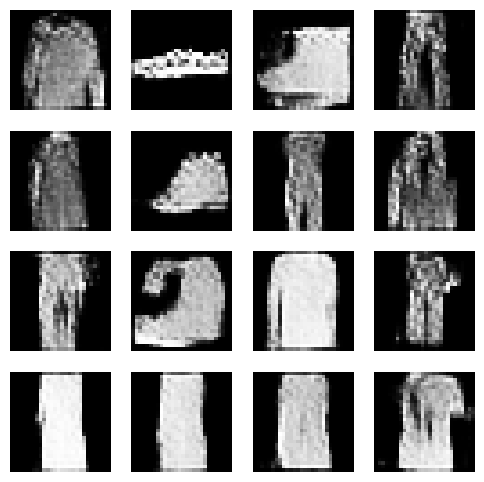

Epoch:  95


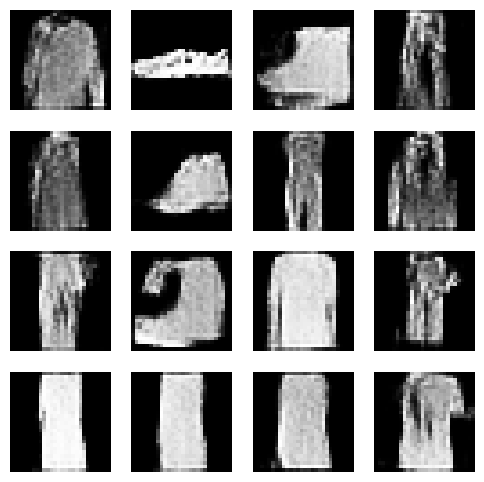

Epoch:  96


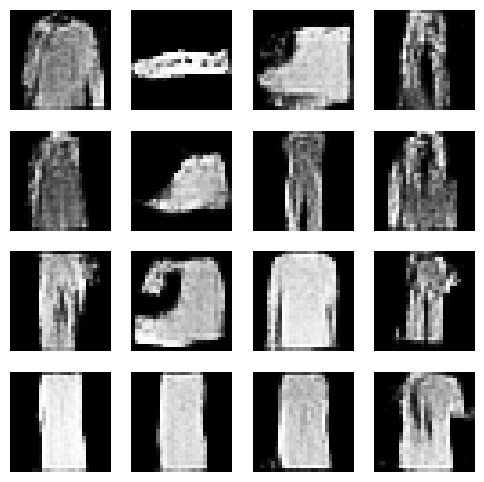

Epoch:  97


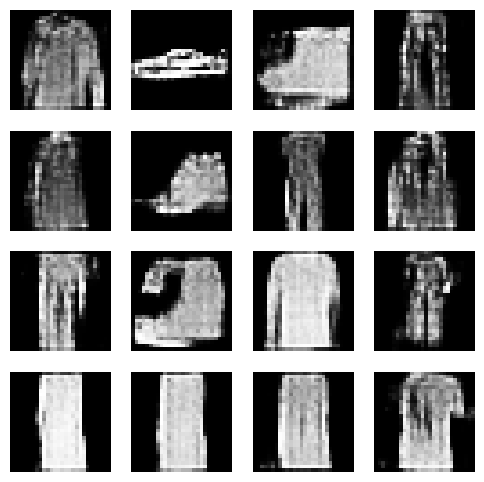

Epoch:  98


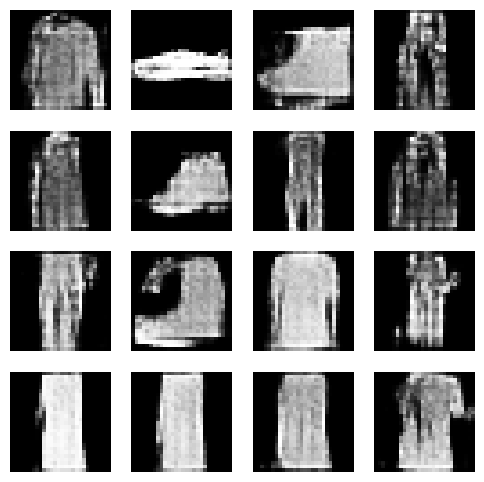

Epoch:  99


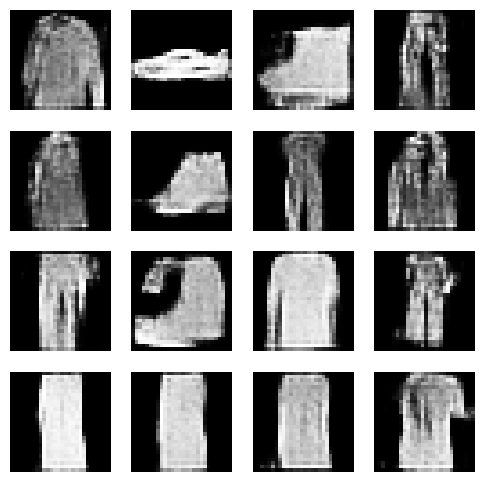

Epoch:  100


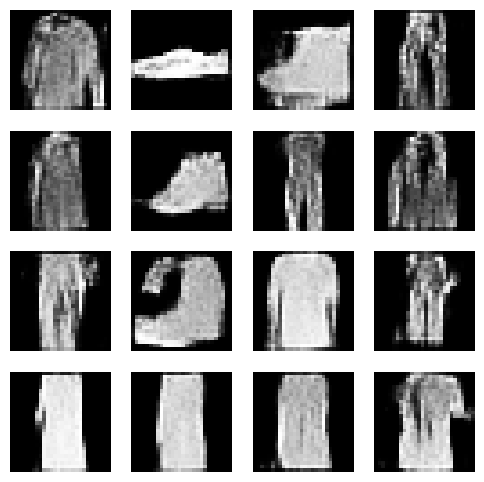

In [ ]:
train(X_train, epochs, test_images)